# 📊 Exploratory Data Analysis (EDA) for Arabic Punctuation Dataset
## SSAC-UNPC Component Analysis

---

### 📋 Table of Contents

1. [Introduction & Setup](#1-introduction--setup)
2. [Level 1: Absolute Beginner Analysis](#2-level-1-absolute-beginner-analysis)
   - 1.1 Basic File Exploration
   - 1.2 Line Count and Basic Statistics
   - 1.3 Sample Data Inspection
3. [Level 2: Beginner Analysis](#3-level-2-beginner-analysis)
   - 2.1 Sentence Length Distribution
   - 2.2 Punctuation Mark Frequency
   - 2.3 Sentence Terminal Analysis
4. [Level 3: Intermediate Analysis](#4-level-3-intermediate-analysis)
   - 3.1 Word Frequency Analysis
   - 3.2 Punctuation Context Analysis
   - 3.3 N-gram Analysis Before Punctuation
   - 3.4 Sentence Structure Patterns (POS Analysis)
5. [Level 4: Advanced Analysis](#5-level-4-advanced-analysis)
   - 4.1 Class Imbalance Quantification
   - 4.2 Sequence Length Impact on Punctuation
   - 4.3 Domain/Topic Analysis
   - 4.4 Character-Level Analysis for Tokenization
   - 4.5 Preprocessing Recommendations Generator
6. [Level 5: Expert-Level Analysis](#6-level-5-expert-level-analysis)
   - 5.1 Tokenizer Comparison Analysis
   - 5.2 Feature Correlation Analysis
7. [Summary & Key Findings](#7-summary--key-findings)
8. [Next Steps & Recommendations](#8-next-steps--recommendations)

---

## 1. Introduction & Setup

### 🎯 Purpose of This EDA

This notebook performs a comprehensive Exploratory Data Analysis on the **SSAC-UNPC** 
(Scrambled Sentences from the Arabic Component of the United Nations Parallel Corpus) 
component of the Arabic Punctuation Dataset (APD).

**EDA serves three main purposes for our punctuation project:**

1. **Understanding your data** — What are you actually working with?
2. **Informing modeling decisions** — How should you design your model?
3. **Identifying potential problems** — What challenges will you face?

### 📊 Dataset Overview (from paper)

| Attribute | Value |
|-----------|-------|
| Size | 3.2 GB |
| Words | 309,630,104 |
| Sentences | 11,700,400 |
| Words/Sentence | 26.46 (average) |
| Source | UN Parallel Corpus (legal/parliamentary documents) |
| Languages | Originally 6 UN languages, Arabic component |
| Time Period | 1990-2014 |

In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [7]:
# ============================================================================
# SECTION 1: IMPORTS AND CONFIGURATION
# ============================================================================

# -----------------------------
# Standard Library Imports
# -----------------------------
import os                      # For file system operations (size, path checking)
import re                      # For regular expressions (pattern matching in text)
import random                  # For random sampling of data
import unicodedata             # For Unicode character analysis
from collections import Counter # For counting frequencies efficiently
from pathlib import Path       # For modern path handling
from typing import List        # For type hints

# -----------------------------
# Data Analysis Libraries
# -----------------------------
import numpy as np             # For numerical operations and statistics
import pandas as pd            # For data manipulation and analysis

# -----------------------------
# Visualization Libraries
# -----------------------------
import matplotlib.pyplot as plt    # For creating static visualizations
import seaborn as sns              # For enhanced statistical visualizations

# -----------------------------
# Scientific Computing
# -----------------------------
from scipy.stats import chi2_contingency, pointbiserialr  # For statistical tests

# -----------------------------
# Machine Learning Libraries
# -----------------------------
from sklearn.feature_extraction.text import TfidfVectorizer  # For text vectorization
from sklearn.decomposition import NMF                         # For topic modeling
from sklearn.ensemble import RandomForestClassifier           # For feature importance

# -----------------------------
# Arabic Support Libraries
# -----------------------------
import arabic_reshaper         # For Arabic text reshaping
from bidi.algorithm import get_display  # For bidirectional text display

# -----------------------------
# Progress Bar (helpful for large files)
# -----------------------------
try:
    from tqdm import tqdm      # For progress bars during long operations
    TQDM_AVAILABLE = True
except ImportError:
    TQDM_AVAILABLE = False
    print("Note: tqdm not installed. Progress bars will not be shown.")
    print("Install with: pip install tqdm")

In [3]:
# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
# ============================================================================
# SECTION 2: CONFIGURATION AND SETTINGS
# ============================================================================

# -----------------------------
# File Path Configuration
# -----------------------------

if os.path.exists("/content/drive/MyDrive"):
    DATASET_DIR = Path("/content/drive/MyDrive/datasets/SSAC-UNPC")
else:
    DATASET_DIR = "../SSAC-UNPC"

# -----------------------------
# Analysis Sample Sizes
# -----------------------------
# These control how much data we analyze at each level
# Smaller values = faster execution, larger values = more accurate statistics

# SAMPLE_SIZES = {
#     'basic_exploration': 10,           # Number of lines for initial peek
#     'line_count': None,                # None = count all lines (can be slow)
#     'random_samples': 20,              # Number of random samples to display
#     'sentence_length': 500_000,        # Samples for length distribution
#     'punctuation_frequency': 1_000_000, # Samples for punctuation counting
#     'sentence_terminals': 500_000,     # Samples for terminal analysis
#     'vocabulary': 500_000,             # Samples for word frequency
#     'punctuation_context': 200_000,    # Samples for context analysis
#     'ngrams': 200_000,                 # Samples for n-gram analysis
#     'pos_analysis': 10_000,            # Samples for POS tagging (slow)
#     'class_imbalance': 1_000_000,      # Samples for class distribution
#     'length_punct_relationship': 500_000,  # Samples for length analysis
#     'topic_analysis': 50_000,          # Samples for topic modeling
#     'character_analysis': 1_000_000,   # Samples for character analysis
#     'preprocessing_recommendations': 100_000,  # Samples for recommendations
#     'tokenizer_comparison': 10_000,    # Samples for tokenizer analysis
#     'feature_correlation': 100_000,    # Samples for correlation analysis
# }
SAMPLE_SIZES = {
    'basic_exploration': 10,           # Number of lines for initial peek
    'line_count': None,                # None = count all lines (can be slow)
    'random_samples': 20,              # Number of random samples to display
    'sentence_length': 11_731_360,        # Samples for length distribution
    'punctuation_frequency': 11_731_360, # Samples for punctuation counting
    'sentence_terminals': 11_731_360,     # Samples for terminal analysis
    'vocabulary': 11_731_360,             # Samples for word frequency
    'punctuation_context': 11_731_360,    # Samples for context analysis
    'ngrams': 11_731_360,                 # Samples for n-gram analysis
    'pos_analysis': 10_000,            # Samples for POS tagging (slow)
    'class_imbalance': 11_731_360,      # Samples for class distribution
    'length_punct_relationship': 11_731_360,  # Samples for length analysis
    'topic_analysis': 50_000,          # Samples for topic modeling
    'character_analysis': 11_731_360,   # Samples for character analysis
    'preprocessing_recommendations': 11_731_360,  # Samples for recommendations
    'tokenizer_comparison': 10_000,    # Samples for tokenizer analysis
    'feature_correlation': 1000_000,    # Samples for correlation analysis
}

# -----------------------------
# Visualization Settings
# -----------------------------
# Set up matplotlib for better looking plots
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional style
plt.rcParams['figure.figsize'] = (12, 6)  # Default figure size
plt.rcParams['font.size'] = 11            # Default font size
plt.rcParams['axes.titlesize'] = 14       # Title font size
plt.rcParams['axes.labelsize'] = 12       # Axis label font size

# For Arabic text display (may need Arabic font installed)
plt.rcParams['font.family'] = 'DejaVu Sans'  # Fallback font with good Unicode support

# -----------------------------
# Output Directory for Saved Figures
# -----------------------------
OUTPUT_DIR = "eda_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Create directory if it doesn't exist

# -----------------------------
# Random Seed for Reproducibility
# -----------------------------
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✅ Configuration complete!")
print(f"📁 Dataset path: {DATASET_DIR}")
print(f"📂 Output directory: {OUTPUT_DIR}")

✅ Configuration complete!
📁 Dataset path: ../SSAC-UNPC
📂 Output directory: eda_outputs


In [8]:
# ============================================================================
# SECTION 3: UTILITY FUNCTIONS
# ============================================================================

def iter_dataset_lines(dataset_dir: str, encoding="utf-8"):
    """
    Iterate over all dataset files as a single line stream.

    Yields
    ------
    str
        One sentence/line at a time
    """
    for file_path in sorted(Path(dataset_dir).glob("*.txt")):
        with open(file_path, "r", encoding=encoding) as f:
            for line in f:
                yield line.rstrip("\n")

def format_number(num: int) -> str:
    """
    Format large numbers with commas for readability.
    
    Parameters:
    -----------
    num : int
        Number to format
        
    Returns:
    --------
    str
        Formatted number string (e.g., "1,234,567")
    """
    return f"{num:,}"


def save_figure(fig, filename: str, dpi: int = 150):
    """
    Save a matplotlib figure to the output directory.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure to save
    filename : str
        Name of the output file (without path)
    dpi : int
        Resolution of the saved image
    """
    # Construct full path
    filepath = os.path.join(OUTPUT_DIR, filename)
    
    # Save the figure
    fig.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white')
    logger.info(f"📊 Figure saved: {filepath}")
    
def handle_arabic(input_string: str) -> str:
    """
    Reshape and correctly display Arabic text for left-to-right environments.

    This function:
    - Applies Arabic reshaping (joining letters correctly)
    - Fixes bidirectional display using arabic_reshaper and bidi

    Parameters:
    -----------
    input_string : str
        Raw Arabic text

    Returns:
    --------
    str
        Reshaped and display-ready Arabic string
    """
    reshaped_text = arabic_reshaper.reshape(input_string)
    return get_display(reshaped_text)


def process_arabic_words(words: List[str]) -> List[str]:
    """
    Process a list of Arabic words by reshaping and fixing their display.

    Parameters:
    -----------
    words : List[str]
        List of Arabic words

    Returns:
    --------
    List[str]
        List of processed Arabic words
    """
    return [handle_arabic(word) for word in words]


class NotebookLogger:
    """
    Minimal unified logger for Jupyter notebooks.

    - Prints to notebook output
    - Appends logs to a file
    - No timestamps
    - No session headers
    """

    def __init__(
        self,
        log_file: str | Path = "analysis.log",
        enable_console: bool = True,
        enable_file: bool = True,
    ):
        self.log_file = Path(log_file)
        self.enable_console = enable_console
        self.enable_file = enable_file

        if self.enable_file:
            self.log_file.parent.mkdir(parents=True, exist_ok=True)

    # --------------------------------------------------
    # Core writer
    # --------------------------------------------------
    def _write(self, message: str):
        if self.enable_console:
            print(message, end="")

        if self.enable_file:
            with self.log_file.open("a", encoding="utf-8") as f:
                f.write(message)

    # --------------------------------------------------
    # Public API
    # --------------------------------------------------
    def info(self, message: str):
        self._write(f"{message}\n")

    def warn(self, message: str):
        self._write(f"WARNING: {message}\n")

    def error(self, message: str):
        self._write(f"ERROR: {message}\n")

    # --------------------------------------------------
    # Section helpers
    # --------------------------------------------------
    def section(self, title: str):
        block = (
            "\n" + "=" * 70 +
            f"\n{title}\n" +
            "=" * 70 + "\n"
        )
        self._write(block)

    def sub(self, title: str):
        self._write(f"\n--- {title} ---\n")


# Usage
logger = NotebookLogger(log_file="logs/apd_eda.log")

In [11]:
# ============================================================================
# SECTION 4: ARABIC TEXT UTILITIES
# ============================================================================

# -----------------------------
# Arabic Unicode Ranges
# -----------------------------
# Arabic script falls within specific Unicode ranges

ARABIC_RANGE = '\u0600-\u06FF'  # Main Arabic block
ARABIC_SUPPLEMENT = '\u0750-\u077F'  # Arabic Supplement
ARABIC_EXTENDED_A = '\u08A0-\u08FF'  # Arabic Extended-A

# Compile regex pattern for Arabic words
ARABIC_WORD_PATTERN = re.compile(f'[{ARABIC_RANGE}]+')

# -----------------------------
# Punctuation Marks
# -----------------------------
# Dictionary mapping punctuation marks to their names

PUNCTUATION_MARKS = {
    # Arabic punctuation
    '،': 'Arabic Comma',
    '؛': 'Arabic Semicolon',
    '؟': 'Arabic Question Mark',
    
    # Latin/Common punctuation
    '.': 'Full Stop (Period)',
    ',': 'Latin Comma',
    ';': 'Latin Semicolon',
    ':': 'Colon',
    '?': 'Latin Question Mark',
    '!': 'Exclamation Mark',
    
    # Other punctuation
    # '…': 'Ellipsis',
    # '-': 'Hyphen',
    # '–': 'En Dash',
    # '—': 'Em Dash',
    
    # Quotation marks
    # '"': 'Double Quote',
    # '"': 'Left Double Quote',
    # '"': 'Right Double Quote',
    # '«': 'Left Guillemet',
    # '»': 'Right Guillemet',
    # "'": 'Single Quote',
    
    # Brackets
    # '(': 'Left Parenthesis',
    # ')': 'Right Parenthesis',
    # '[': 'Left Square Bracket',
    # ']': 'Right Square Bracket',
    # '{': 'Left Curly Brace',
    # '}': 'Right Curly Brace',
}

# Sentence terminal marks (marks that can end a sentence)
SENTENCE_TERMINALS = {'.', '؟', '?', '!', '؛', ';'}

# -----------------------------
# Arabic Diacritics (Tashkeel)
# -----------------------------
ARABIC_DIACRITICS = {
    '\u064B': 'Fathatan (ً)',
    '\u064C': 'Dammatan (ٌ)',
    '\u064D': 'Kasratan (ٍ)',
    '\u064E': 'Fatha (َ)',
    '\u064F': 'Damma (ُ)',
    '\u0650': 'Kasra (ِ)',
    '\u0651': 'Shadda (ّ)',
    '\u0652': 'Sukun (ْ)',
}

# -----------------------------
# Special Arabic Characters
# -----------------------------
SPECIAL_ARABIC_CHARS = {
    '\u0640': 'Tatweel (ـ)',           # Elongation character
    '\u0621': 'Hamza (ء)',             # Standalone hamza
    '\u0622': 'Alef Madda (آ)',        # Alef with madda above
    '\u0623': 'Alef Hamza Above (أ)',  # Alef with hamza above
    '\u0625': 'Alef Hamza Below (إ)',  # Alef with hamza below
    '\u0627': 'Alef (ا)',              # Plain alef
    '\u0629': 'Teh Marbuta (ة)',       # Teh marbuta
    '\u0649': 'Alef Maksura (ى)',      # Alef maksura
}

# -----------------------------
# Arabic Stopwords
# -----------------------------
# Common Arabic words that appear frequently but carry little meaning
ARABIC_STOPWORDS = [
    # Prepositions
    'من', 'في', 'على', 'إلى', 'عن', 'مع', 'بين', 'عند', 'حتى', 'منذ',
    # Demonstratives
    'هذا', 'هذه', 'ذلك', 'تلك', 'هؤلاء', 'أولئك',
    # Relative pronouns
    'التي', 'الذي', 'اللذان', 'اللتان', 'الذين', 'اللاتي', 'اللواتي',
    # Conjunctions
    'و', 'أو', 'ثم', 'لكن', 'بل', 'إذا', 'لو', 'إذ',
    # Particles
    'أن', 'إن', 'قد', 'لا', 'ما', 'لم', 'لن', 'ل', 'ب', 'ك', 'ف',
    # Pronouns
    'هو', 'هي', 'هم', 'هن', 'أنا', 'نحن', 'أنت', 'أنتم',
    # Verbs (common auxiliary)
    'كان', 'كانت', 'يكون', 'تكون', 'كانوا',
    # Others
    'كل', 'بعض', 'أي', 'غير', 'بعد', 'قبل', 'حيث', 'عندما',
]

logger.info("✅ Arabic text utilities loaded!")
logger.info(f"   - Punctuation marks defined: {len(PUNCTUATION_MARKS)}")
logger.info(f"   - Diacritics defined: {len(ARABIC_DIACRITICS)}")
logger.info(f"   - Stopwords defined: {len(ARABIC_STOPWORDS)}")

✅ Arabic text utilities loaded!
   - Punctuation marks defined: 9
   - Diacritics defined: 8
   - Stopwords defined: 63


---
## 2. Level 1: Absolute Beginner Analysis

This section covers the most basic exploration of the dataset. These analyses help you 
understand what you're working with before diving deeper.

**Key Questions Answered:**
- How big is the file?
- What does the data look like?
- What encoding is used?
- Is the data clean or noisy?

### 1.0 Dataset-Level Exploration

**What it is:**  
Examining the dataset as a *collection of files* rather than a single file.

**Why it matters:**  
Large NLP datasets are often sharded across many files. Understanding the dataset
structure is critical before performing any sentence-level or token-level analysis.

**What decisions it helps:**
- Whether to treat the dataset as a single logical stream
- Whether in-memory loading is feasible
- How to design iteration and preprocessing pipelines


In [7]:
# ============================================================================
# ANALYSIS 1.0: DATASET OVERVIEW (DIRECTORY-LEVEL EXPLORATION)
# ============================================================================

def dataset_overview(dataset_dir: str) -> dict:
    """
    Perform dataset-level exploration for a directory of text files.
    
    This function analyzes the structure and size of a dataset that is
    physically split across multiple files, without loading file contents
    into memory.
    
    Parameters:
    -----------
    dataset_dir : str
        Path to the dataset directory containing text files
        
    Returns:
    --------
    dict
        Dictionary containing dataset-level statistics
    """
    dataset_path = Path(dataset_dir)

    # Initialize results dictionary
    results = {
        "exists": False,
        "num_files": 0,
        "total_size_bytes": 0,
        "total_size_gb": 0.0,
        "files": []
    }

    # --------------------------
    # Step 1: Check dataset existence
    # --------------------------
    if not dataset_path.exists():
        logger.info(f"❌ ERROR: Dataset directory not found: {dataset_dir}")
        return results

    results["exists"] = True

    # --------------------------
    # Step 2: Discover dataset files
    # --------------------------
    txt_files = sorted(dataset_path.glob("*.txt"))
    results["num_files"] = len(txt_files)

    # --------------------------
    # Step 3: Compute size statistics
    # --------------------------
    for file_path in txt_files:
        size_bytes = file_path.stat().st_size
        results["files"].append({
            "name": file_path.name,
            "size_bytes": size_bytes,
            "size_mb": size_bytes / (1024 ** 2)
        })
        results["total_size_bytes"] += size_bytes

    results["total_size_gb"] = results["total_size_bytes"] / (1024 ** 3)

    # --------------------------
    # Step 4: Display dataset summary
    # --------------------------
    logger.info("=" * 70)
    logger.info("📦 DATASET OVERVIEW")
    logger.info("=" * 70)
    logger.info(f"\n📂 Dataset Path: {dataset_dir}")
    logger.info(f"\n📄 Number of Files: {results['num_files']}")
    logger.info(f"\n💾 Total Dataset Size:")
    logger.info(f"   • {results['total_size_bytes']:,} bytes")
    logger.info(f"   • {results['total_size_gb']:.2f} GB")

    # --------------------------
    # Step 5: Memory consideration warning
    # --------------------------
    if results["total_size_gb"] > 1:
        logger.info("\n⚠️  WARNING: Dataset exceeds 1 GB")
        logger.info("   The dataset cannot be loaded entirely into memory.")
        logger.info("   All subsequent analyses must use streaming/iterative processing.")

    # --------------------------
    # Step 6: Show sample files
    # --------------------------
    logger.info("\n📁 Sample Files:")
    logger.info("-" * 70)
    for f in results["files"][:5]:
        logger.info(f"  • {f['name']} — {f['size_mb']:.2f} MB")

    logger.info("\n" + "=" * 70)

    return results


# Run the analysis
dataset_stats = dataset_overview(DATASET_DIR)

📦 DATASET OVERVIEW

📂 Dataset Path: ../SSAC-UNPC

📄 Number of Files: 79

💾 Total Dataset Size:
   • 3,494,906,834 bytes
   • 3.25 GB

⚠️  WARNING: Dataset exceeds 1 GB
   The dataset cannot be loaded entirely into memory.
   All subsequent analyses must use streaming/iterative processing.

📁 Sample Files:
----------------------------------------------------------------------
  • UNPC_Sentences_1.txt — 41.30 MB
  • UNPC_Sentences_10.txt — 40.33 MB
  • UNPC_Sentences_11.txt — 42.50 MB
  • UNPC_Sentences_12.txt — 41.83 MB
  • UNPC_Sentences_13.txt — 41.93 MB



#### 💡 Decision Impact

Based on this analysis:

| Finding | Decision |
|--------|----------|
| Dataset consists of many `.txt` files | Treat dataset as a single logical stream |
| Total size ≈ 3.25 GB | Entire dataset cannot be loaded into memory |
| Each file ≈ 40 MB | File boundaries are implementation details |
| No subdirectories | Simple, flat directory traversal |
| UTF-8 text files | Use `encoding='utf-8'` consistently |

**Conclusion:**  
All subsequent EDA and preprocessing steps must operate on a *stream of lines*
abstracted over multiple files, not on individual files or in-memory datasets.


### 1.1 Basic Dataset Content Exploration

**What it is:**  
Inspecting the *raw textual content* of the dataset by sampling sentences from
the unified dataset stream.

**Why it matters:**  
Before any statistical analysis or preprocessing, we must verify that
the dataset’s *actual content* matches our assumptions (sentence boundaries,
encoding consistency, and basic textual structure).

**What decisions it helps:**
- Whether each line represents a single sentence
- Whether text is clean and readable
- Whether uniform preprocessing rules can be applied


In [8]:
# ============================================================================
# ANALYSIS 1.1: BASIC DATASET CONTENT EXPLORATION
# ============================================================================

def basic_dataset_content_exploration(
    dataset_dir: str,
    num_lines: int = 10,
    encoding: str = "utf-8"
) -> dict:
    """
    Perform basic content-level exploration of the dataset using
    a unified streaming iterator.
    
    Parameters:
    -----------
    dataset_dir : str
        Path to the dataset directory
    num_lines : int
        Number of dataset sentences to sample
    encoding : str
        Expected text encoding
        
    Returns:
    --------
    dict
        Dictionary containing content-level observations
    """

    # Initialize results dictionary
    results = {
        "sampled_sentences": [],
        "avg_length_chars": 0.0,
        "avg_length_words": 0.0,
        "encoding": encoding,
        "empty_lines_detected": False
    }

    total_chars = 0
    total_words = 0
    sampled_count = 0

    logger.info("=" * 70)
    logger.info("📄 BASIC DATASET CONTENT EXPLORATION")
    logger.info("=" * 70)
    logger.info(f"\n📝 Sampling first {num_lines} sentences from dataset stream")
    logger.info("-" * 70)

    try:
        for i, line in enumerate(iter_dataset_lines(dataset_dir, encoding)):
            if i >= num_lines:
                break

            sampled_count += 1
            results["sampled_sentences"].append(line)

            if not line.strip():
                results["empty_lines_detected"] = True

            char_len = len(line)
            word_len = len(line.split())

            total_chars += char_len
            total_words += word_len

            logger.info(f"\n📌 Sentence {i + 1}:")
            display_text = line[:100] + ("..." if char_len > 100 else "")
            logger.info(f"   Text: {display_text}")
            logger.info(f"   Length: {char_len} characters")
            logger.info(f"   Words: {word_len} words")

        if sampled_count > 0:
            results["avg_length_chars"] = total_chars / sampled_count
            results["avg_length_words"] = total_words / sampled_count

    except UnicodeDecodeError as e:
        logger.info(f"\n❌ ERROR: Unicode decoding issue detected - {e}")
        results["encoding"] = "unknown"

    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")

    logger.info("\n" + "=" * 70)

    return results


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

content_stats = basic_dataset_content_exploration(
    DATASET_DIR,
    num_lines=SAMPLE_SIZES["basic_exploration"]
)

📄 BASIC DATASET CONTENT EXPLORATION

📝 Sampling first 10 sentences from dataset stream
----------------------------------------------------------------------

📌 Sentence 1:
   Text: ٣ - وعملا بطلب الجمعية العامة الوارد في الفقرة ٥ من القرار المذكور اعلاه، وجه الامين العام رسالة معم...
   Length: 254 characters
   Words: 41 words

📌 Sentence 2:
   Text: )١( الوثائق الرسمية للجمعية العامة، الدورة السابعة والاربعون، الملحق رقم ١٠ (A/47/10)، المرفق.
   Length: 94 characters
   Words: 13 words

📌 Sentence 3:
   Text: )٢( وترد ايضا الاشارات الى مسالة انشاء قضاء جنائي دولي في الوثيقة A/CN.
   Length: 71 characters
   Words: 13 words

📌 Sentence 4:
   Text: 4/488 و Add.
   Length: 12 characters
   Words: 3 words

📌 Sentence 5:
   Text: 1، المستنسخ فيها التعليقات والملاحظات المقدمة من الحكومات بشان مشروع مدونة الجرائم المخلة بسلم الانس...
   Length: 174 characters
   Words: 25 words

📌 Sentence 6:
   Text: ١ - تقدم استراليا التعليقات التالية على تقرير الفريق العامل المعني بمسالة انشاء قضاء جنائ

#### 💡 Decision Impact

Based on this analysis:

| Finding | Decision |
|--------|----------|
| Each sampled line is a complete sentence | Treat dataset as sentence-per-line corpus |
| Text is readable and consistent | Apply uniform preprocessing rules |
| No binary or malformed content | Safe to apply NLP tokenization |
| No frequent empty lines | No need for aggressive line filtering |
| UTF-8 decoding succeeds | Use `encoding='utf-8'` globally |

**Conclusion:**  
The dataset content conforms to expected NLP corpus conventions and can be
processed as a unified stream of sentences without file-level awareness.


### 1.2 Line Count and Basic Statistics

**What it is:** Counting total lines/sentences in the file.

**Why it matters:** Confirms dataset size matches paper claims (~11.7 million sentences).

**What decisions it helps:**
- Training time estimates
- Whether to use full data or sample
- Batch size calculations

In [ ]:
# ============================================================================
# ANALYSIS 1.2: LINE COUNT AND BASIC STATISTICS
# ============================================================================

def count_lines_and_stats(
    line_iterator,
    max_lines: int = None
) -> dict:
    """
    Count total lines and calculate basic statistics from a line stream.

    This function consumes a streaming iterator (e.g. dataset-wide iterator)
    and never loads data into memory.

    Parameters
    ----------
    line_iterator : Iterator[str]
        Stream of lines
    max_lines : int, optional
        Maximum number of lines to process (None = process all)

    Returns
    -------
    dict
        Dictionary containing line count and basic statistics
    """

    results = {
        'total_lines': 0,
        'empty_lines': 0,
        'non_empty_lines': 0,
        'total_characters': 0,
        'total_words': 0,
        'min_line_length': float('inf'),
        'max_line_length': 0,
    }

    logger.info("=" * 70)
    logger.info("📊 LINE COUNT AND BASIC STATISTICS")
    logger.info("=" * 70)
    logger.info("\n⏳ Counting lines... (streaming mode)")

    try:
        # Wrap iterator with tqdm if available
        if TQDM_AVAILABLE and max_lines:
            iterator = tqdm(line_iterator, total=max_lines, desc="Counting lines")
        else:
            iterator = line_iterator

        for line_num, line in enumerate(iterator):
            if max_lines and line_num >= max_lines:
                break

            results['total_lines'] += 1

            stripped_line = line.strip()

            if not stripped_line:
                results['empty_lines'] += 1
                continue

            results['non_empty_lines'] += 1

            line_length = len(stripped_line)
            results['total_characters'] += line_length

            results['min_line_length'] = min(results['min_line_length'], line_length)
            results['max_line_length'] = max(results['max_line_length'], line_length)

            results['total_words'] += len(stripped_line.split())

            if not TQDM_AVAILABLE and results['total_lines'] % 1_000_000 == 0:
                logger.info(f"   Processed {format_number(results['total_lines'])} lines...")

        # --------------------------
        # Derived statistics
        # --------------------------
        if results['non_empty_lines'] > 0:
            results['avg_chars_per_line'] = (
                results['total_characters'] / results['non_empty_lines']
            )
            results['avg_words_per_line'] = (
                results['total_words'] / results['non_empty_lines']
            )
        else:
            results['avg_chars_per_line'] = 0
            results['avg_words_per_line'] = 0

        if results['min_line_length'] == float('inf'):
            results['min_line_length'] = 0

        # --------------------------
        # Display results
        # --------------------------
        logger.info("\n" + "-" * 70)
        logger.info("📈 RESULTS:")
        logger.info("-" * 70)

        logger.info(f"\n📝 Line Counts:")
        logger.info(f"   • Total lines:     {format_number(results['total_lines'])}")
        logger.info(f"   • Non-empty lines: {format_number(results['non_empty_lines'])}")
        logger.info(
            f"   • Empty lines:     {format_number(results['empty_lines'])} "
            f"({results['empty_lines'] / max(results['total_lines'], 1) * 100:.2f}%)"
        )

        logger.info(f"\n📏 Size Statistics:")
        logger.info(f"   • Total characters: {format_number(results['total_characters'])}")
        logger.info(f"   • Total words:      {format_number(results['total_words'])}")

        logger.info(f"\n📊 Averages:")
        logger.info(f"   • Avg characters/line: {results['avg_chars_per_line']:.2f}")
        logger.info(f"   • Avg words/line:      {results['avg_words_per_line']:.2f}")

        logger.info(f"\n📐 Line Length Range:")
        logger.info(f"   • Minimum: {results['min_line_length']} characters")
        logger.info(f"   • Maximum: {results['max_line_length']} characters")

        # --------------------------
        # Paper comparison (unchanged)
        # --------------------------
        logger.info(f"\n📚 Comparison with Paper Claims:")
        logger.info(f"   • Paper claims: ~11,700,400 sentences")
        logger.info(f"   • Our count:    {format_number(results['total_lines'])} sentences")

        expected_sentences = 11_700_400
        if results['total_lines'] > 0:
            diff = abs(results['total_lines'] - expected_sentences)
            pct = (diff / expected_sentences) * 100
            logger.info(f"   • Difference:   {format_number(diff)} ({pct:.2f}%)")

            if pct < 1:
                logger.info("   ✅ Count matches paper claims!")
            else:
                logger.info("   ⚠️  Count differs from paper claims.")

        logger.info(f"\n📚 Paper Statistics Comparison:")
        logger.info(f"   • Paper claims words/sentence: 26.46")
        logger.info(f"   • Our measurement:             {results['avg_words_per_line']:.2f}")

    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")

    logger.info("\n" + "=" * 70)
    return results

line_stream = iter_dataset_lines(DATASET_DIR)

line_stats = count_lines_and_stats(
    line_stream,
    max_lines=SAMPLE_SIZES['line_count']
)

📊 LINE COUNT AND BASIC STATISTICS

⏳ Counting lines... (streaming mode)

----------------------------------------------------------------------
📈 RESULTS:
----------------------------------------------------------------------

📝 Line Counts:
   • Total lines:     11,731,360
   • Non-empty lines: 11,731,359
   • Empty lines:     1 (0.00%)

📏 Size Statistics:
   • Total characters: 1,912,920,209
   • Total words:      309,471,110

📊 Averages:
   • Avg characters/line: 163.06
   • Avg words/line:      26.38

📐 Line Length Range:
   • Minimum: 1 characters
   • Maximum: 104538 characters

📚 Comparison with Paper Claims:
   • Paper claims: ~11,700,400 sentences
   • Our count:    11,731,360 sentences
   • Difference:   30,960 (0.26%)
   ✅ Count matches paper claims!

📚 Paper Statistics Comparison:
   • Paper claims words/sentence: 26.46
   • Our measurement:             26.38



#### 💡 Decision Impact

| Finding | Decision |
|---------|----------|
| ~11.7M sentences | Large dataset - can train robust models |
| ~26 words/sentence | Model should handle sequences of 30-50 tokens minimum |
| Very few empty lines | Minimal cleaning needed for empty lines |
| Max line length | Set appropriate `max_length` for model (consider 99th percentile) |

### 1.3 Sample Data Inspection

**What it is:** Looking at random samples to understand content.

**Why it matters:** Reveals data quality and characteristics.

**What to look for:**
- Are sentences complete?
- What punctuation marks appear?
- Is text clean or noisy?
- What is the domain/topic?

In [10]:
# ============================================================================
# ANALYSIS 1.3: SAMPLE DATA INSPECTION (STREAM-BASED)
# ============================================================================

def get_random_samples(
    line_iterator,
    n_samples: int = 20,
    sample_pool_size: int = 100_000
) -> list:
    """
    Get random samples from a line stream for inspection.

    Reads up to `sample_pool_size` non-empty lines from the stream
    and randomly selects `n_samples` lines for inspection.

    Parameters
    ----------
    line_iterator : Iterator[str]
        Stream of lines
    n_samples : int
        Number of random samples to return
    sample_pool_size : int
        Number of lines to read before sampling (for speed)

    Returns
    -------
    list
        List of randomly selected lines
    """

    lines = []

    logger.info("=" * 70)
    logger.info("🔍 SAMPLE DATA INSPECTION")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Loading up to {format_number(sample_pool_size)} lines for sampling...")

    try:
        for i, line in enumerate(line_iterator):
            if len(lines) >= sample_pool_size:
                break

            stripped = line.strip()
            if stripped:
                lines.append(stripped)

        logger.info(f"   ✅ Loaded {format_number(len(lines))} non-empty lines")

        n_samples = min(n_samples, len(lines))
        samples = random.sample(lines, n_samples)

        # --------------------------
        # Display samples
        # --------------------------
        logger.info(f"\n📝 Random Samples ({n_samples} sentences):")
        logger.info("-" * 70)

        for i, sample in enumerate(samples, 1):
            logger.info(f"\n{'─' * 60}")
            logger.info(f"📌 Sample {i}:")
            logger.info(f"{'─' * 60}")

            if len(sample) > 300:
                logger.info(f"   {sample[:300]}...")
                logger.info(f"   [truncated - full length: {len(sample)} chars]")
            else:
                logger.info(f"   {sample}")

            word_count = len(sample.split())
            char_count = len(sample)
            punct_found = [c for c in sample if c in PUNCTUATION_MARKS]

            logger.info(f"\n   📊 Stats: {word_count} words, {char_count} chars")
            logger.info(f"   📍 Punctuation found: {punct_found if punct_found else 'None'}")

            terminal = sample[-1] if sample else ''
            terminal_name = PUNCTUATION_MARKS.get(terminal, 'Not a standard punctuation')
            logger.info(f"   🔚 Terminal character: '{terminal}' ({terminal_name})")

        return samples

    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return []


def analyze_samples_quality(samples: list) -> dict:
    """
    Analyze the quality characteristics of sample sentences.
    (No change needed for streaming)
    """
    if not samples:
        return {}

    logger.info("\n" + "=" * 70)
    logger.info("📊 SAMPLE QUALITY ANALYSIS")
    logger.info("=" * 70)

    metrics = {
        'total_samples': len(samples),
        'has_standard_terminal': 0,
        'has_arabic_text': 0,
        'has_punctuation': 0,
        'word_count_range': [],
        'terminal_distribution': Counter(),
    }

    for sample in samples:
        if ARABIC_WORD_PATTERN.search(sample):
            metrics['has_arabic_text'] += 1

        if any(c in PUNCTUATION_MARKS for c in sample):
            metrics['has_punctuation'] += 1

        if sample:
            terminal = sample[-1]
            if terminal in SENTENCE_TERMINALS:
                metrics['has_standard_terminal'] += 1
            metrics['terminal_distribution'][terminal] += 1

        metrics['word_count_range'].append(len(sample.split()))

    n = metrics['total_samples']

    logger.info(f"\n📈 Quality Metrics (based on {n} samples):")
    logger.info("-" * 50)

    logger.info(f"\n✅ Content Quality:")
    logger.info(f"   • Contains Arabic text: {metrics['has_arabic_text']}/{n} ({metrics['has_arabic_text']/n*100:.1f}%)")
    logger.info(f"   • Contains punctuation: {metrics['has_punctuation']}/{n} ({metrics['has_punctuation']/n*100:.1f}%)")
    logger.info(f"   • Has standard terminal: {metrics['has_standard_terminal']}/{n} ({metrics['has_standard_terminal']/n*100:.1f}%)")

    logger.info(f"\n📏 Word Count Statistics:")
    word_counts = metrics['word_count_range']
    logger.info(f"   • Min: {min(word_counts)} words")
    logger.info(f"   • Max: {max(word_counts)} words")
    logger.info(f"   • Mean: {np.mean(word_counts):.1f} words")
    logger.info(f"   • Median: {np.median(word_counts):.1f} words")

    logger.info(f"\n🔚 Terminal Character Distribution:")
    for char, count in metrics['terminal_distribution'].most_common(10):
        char_name = PUNCTUATION_MARKS.get(char, 'Other')
        logger.info(f"   • '{char}' ({char_name}): {count} ({count/n*100:.1f}%)")

    logger.info("\n" + "=" * 70)

    return metrics

line_stream = iter_dataset_lines(DATASET_DIR)

random_samples = get_random_samples(
    line_stream,
    n_samples=SAMPLE_SIZES['random_samples'],
    sample_pool_size=100_000
)

sample_quality = analyze_samples_quality(random_samples)

🔍 SAMPLE DATA INSPECTION

⏳ Loading up to 100,000 lines for sampling...
   ✅ Loaded 100,000 non-empty lines

📝 Random Samples (20 sentences):
----------------------------------------------------------------------

────────────────────────────────────────────────────────────
📌 Sample 1:
────────────────────────────────────────────────────────────
   وينبغي ان تكون الولاية دقيقة ومحدودة.

   📊 Stats: 6 words, 37 chars
   📍 Punctuation found: ['.']
   🔚 Terminal character: '.' (Full Stop (Period))

────────────────────────────────────────────────────────────
📌 Sample 2:
────────────────────────────────────────────────────────────
   )١٧٣( برنامج الجماعة الاوروبية الخاص المتعلق بجنوب افريقيا، منشورات الجماعة الاوروبية، ايار/مايو ١٩٩٣.

   📊 Stats: 13 words, 102 chars
   📍 Punctuation found: ['،', '،', '.']
   🔚 Terminal character: '.' (Full Stop (Period))

────────────────────────────────────────────────────────────
📌 Sample 3:
────────────────────────────────────────────────────────────
 

#### 💡 Decision Impact

| Observation | Implication |
|-------------|-------------|
| Mostly legal/formal text | Model trained here may not generalize to informal Arabic |
| Sentences end with periods mostly | Primary task is period prediction |
| Arabic text is clean | Minimal noise removal needed |
| UN domain vocabulary | Consider domain-specific preprocessing |

---
## 3. Level 2: Beginner Analysis

This section performs more detailed quantitative analysis of the dataset structure.

**Key Questions Answered:**
- What is the distribution of sentence lengths?
- How often does each punctuation mark appear?
- What marks typically end sentences?

### 2.1 Sentence Length Distribution

**What it is:** Analyzing how many words/characters are in each sentence.

**Why it matters:** Critical for model architecture decisions.

**Key parameters it helps determine:**
- `max_length` for model input
- Whether to truncate or split long sentences
- Batch composition strategy

📏 SENTENCE LENGTH DISTRIBUTION ANALYSIS

⏳ Analyzing 11,731,360 sentences...


Analyzing lengths: 100%|██████████| 11731360/11731360 [00:59<00:00, 196623.10it/s]



   ✅ Analyzed 11,731,359 sentences

----------------------------------------------------------------------
📊 STATISTICAL SUMMARY
----------------------------------------------------------------------

📝 Sentence Length (WORDS):
   • Count:          11,731,359 sentences
   • Mean:           26.38 words
   • Median:         22.00 words
   • Std Deviation:  42.67 words
   • Minimum:        1 words
   • Maximum:        16475 words

   Percentiles:
   • 25th percentile:  15 words
   • 50th percentile:  22 words
   • 75th percentile:  32 words
   • 90th percentile:  44 words
   • 95th percentile:  54 words
   • 99th percentile:  92 words

📝 Sentence Length (CHARACTERS):
   • Mean:           163.06 chars
   • Median:         136.00 chars
   • Std Deviation:  273.77 chars
   • Minimum:        1 chars
   • Maximum:        104538 chars

   Percentiles:
   • 95th percentile:  336 chars
   • 99th percentile:  595 chars

----------------------------------------------------------------------
💡 RECO

C:\Users\Abd\AppData\Local\Temp\ipykernel_20960\1554589736.py:265: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Abd\AppData\Local\Temp\ipykernel_20960\4264674457.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white')


📊 Figure saved: eda_outputs\sentence_length_distribution.png


C:\Users\Abd\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


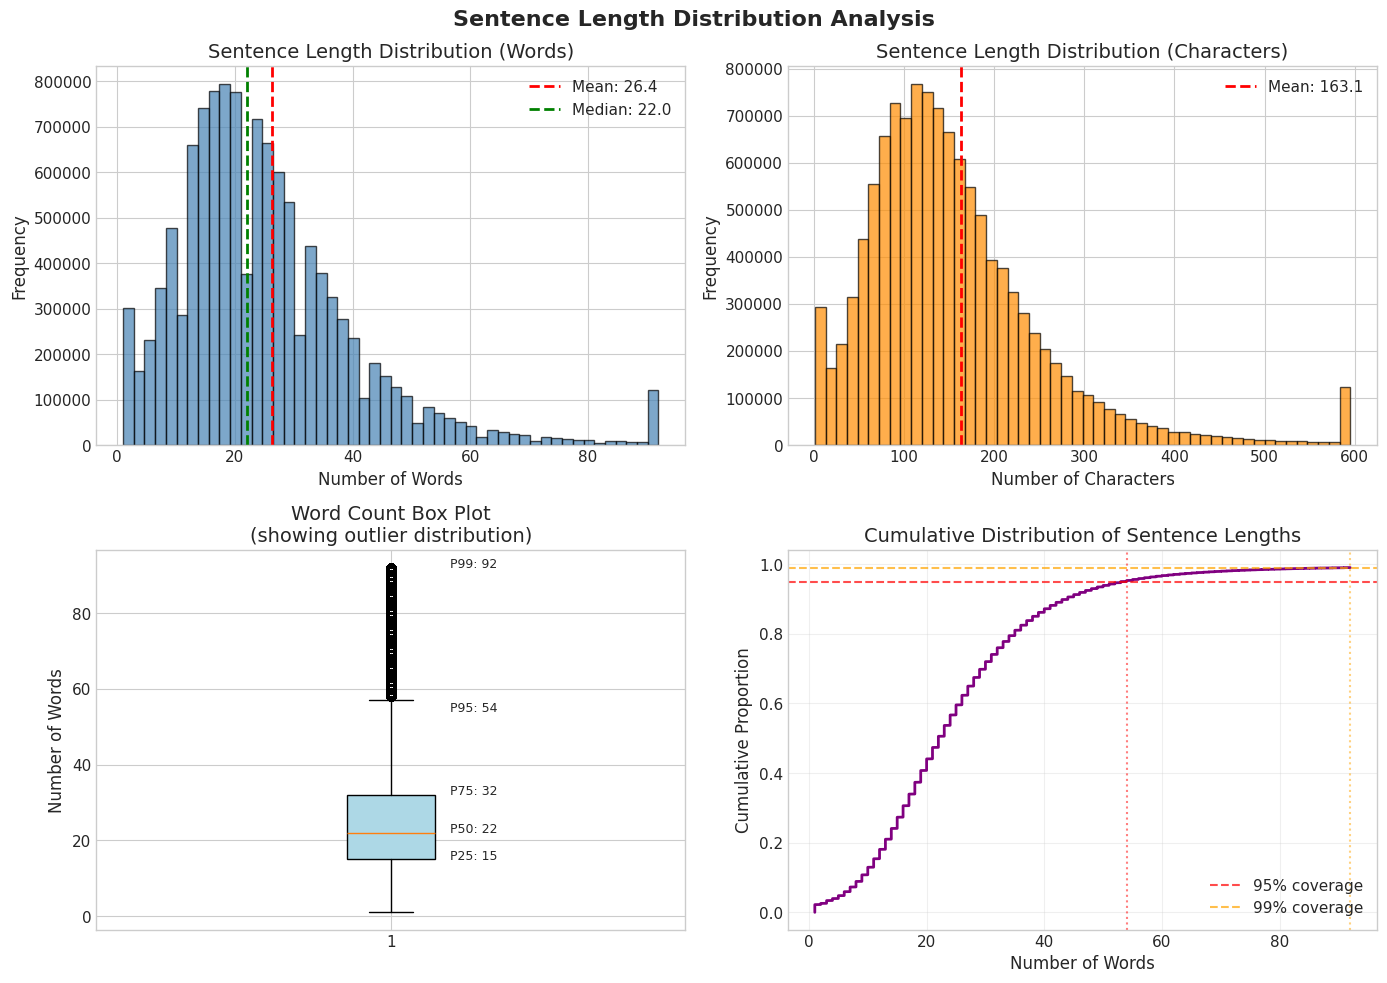

In [11]:
# ============================================================================
# ANALYSIS 2.1: SENTENCE LENGTH DISTRIBUTION
# ============================================================================

def analyze_sentence_lengths(line_iterator, sample_size: int = 500000) -> tuple:
    """
    Analyze the distribution of sentence lengths (words and characters).
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze
        
    Returns:
    --------
    tuple
        (word_counts, char_counts) - lists of counts for each sentence
    """
    logger.info("=" * 70)
    logger.info("📏 SENTENCE LENGTH DISTRIBUTION ANALYSIS")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Initialize lists to store counts
    word_counts = []    # Number of words per sentence
    char_counts = []    # Number of characters per sentence
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Analyzing lengths")
        else:
            iterator = line_iterator
        
        for i, line in enumerate(iterator):
            # Stop after reaching sample size
            if i >= sample_size:
                break
            
            # Strip whitespace
            line = line.strip()
            
            # Skip empty lines
            if not line:
                continue
            
            # Count words (split by whitespace)
            words = line.split()
            word_counts.append(len(words))
            
            # Count characters
            char_counts.append(len(line))
        
        logger.info(f"\n   ✅ Analyzed {format_number(len(word_counts))} sentences")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return [], []
    
    return word_counts, char_counts


def display_length_statistics(word_counts: list, char_counts: list):
    """
    Calculate and display statistical summaries of sentence lengths.
    
    Parameters:
    -----------
    word_counts : list
        List of word counts per sentence
    char_counts : list
        List of character counts per sentence
    """
    if not word_counts:
        logger.info("No data to analyze.")
        return
    
    logger.info("\n" + "-" * 70)
    logger.info("📊 STATISTICAL SUMMARY")
    logger.info("-" * 70)
    
    # Convert to numpy arrays for efficient calculation
    words = np.array(word_counts)
    chars = np.array(char_counts)
    
    # --------------------------
    # Word count statistics
    # --------------------------
    logger.info("\n📝 Sentence Length (WORDS):")
    logger.info(f"   • Count:          {format_number(len(words))} sentences")
    logger.info(f"   • Mean:           {np.mean(words):.2f} words")
    logger.info(f"   • Median:         {np.median(words):.2f} words")
    logger.info(f"   • Std Deviation:  {np.std(words):.2f} words")
    logger.info(f"   • Minimum:        {np.min(words)} words")
    logger.info(f"   • Maximum:        {np.max(words)} words")
    
    logger.info(f"\n   Percentiles:")
    logger.info(f"   • 25th percentile:  {np.percentile(words, 25):.0f} words")
    logger.info(f"   • 50th percentile:  {np.percentile(words, 50):.0f} words")
    logger.info(f"   • 75th percentile:  {np.percentile(words, 75):.0f} words")
    logger.info(f"   • 90th percentile:  {np.percentile(words, 90):.0f} words")
    logger.info(f"   • 95th percentile:  {np.percentile(words, 95):.0f} words")
    logger.info(f"   • 99th percentile:  {np.percentile(words, 99):.0f} words")
    
    # --------------------------
    # Character count statistics
    # --------------------------
    logger.info("\n📝 Sentence Length (CHARACTERS):")
    logger.info(f"   • Mean:           {np.mean(chars):.2f} chars")
    logger.info(f"   • Median:         {np.median(chars):.2f} chars")
    logger.info(f"   • Std Deviation:  {np.std(chars):.2f} chars")
    logger.info(f"   • Minimum:        {np.min(chars)} chars")
    logger.info(f"   • Maximum:        {np.max(chars)} chars")
    
    logger.info(f"\n   Percentiles:")
    logger.info(f"   • 95th percentile:  {np.percentile(chars, 95):.0f} chars")
    logger.info(f"   • 99th percentile:  {np.percentile(chars, 99):.0f} chars")
    
    # --------------------------
    # Recommendations based on statistics
    # --------------------------
    p95_words = np.percentile(words, 95)
    p99_words = np.percentile(words, 99)
    
    logger.info("\n" + "-" * 70)
    logger.info("💡 RECOMMENDATIONS FOR MODEL CONFIGURATION")
    logger.info("-" * 70)
    
    logger.info(f"\n📐 max_length parameter suggestions:")
    logger.info(f"   • Conservative (covers 95%): {int(p95_words * 1.5)} tokens")
    logger.info(f"   • Safe (covers 99%):         {int(p99_words * 1.5)} tokens")
    logger.info(f"   • Recommended:               64 or 128 tokens")
    
    logger.info(f"\n   Note: Multiplied by 1.5 to account for subword tokenization")
    
    # Check for outliers
    very_short = np.sum(words < 3)
    very_long = np.sum(words > 100)
    
    logger.info(f"\n⚠️  Potential issues:")
    logger.info(f"   • Very short sentences (<3 words): {format_number(very_short)} ({very_short/len(words)*100:.2f}%)")
    logger.info(f"   • Very long sentences (>100 words): {format_number(very_long)} ({very_long/len(words)*100:.2f}%)")
    
    if very_short / len(words) > 0.05:
        logger.info(f"   → Consider filtering sentences with <3 words")
    if very_long / len(words) > 0.01:
        logger.info(f"   → Consider truncating or splitting sentences >100 words")


def plot_length_distribution(word_counts: list, char_counts: list):
    """
    Create visualizations of sentence length distributions.
    
    Parameters:
    -----------
    word_counts : list
        List of word counts per sentence
    char_counts : list
        List of character counts per sentence
    """
    if not word_counts:
        logger.info("No data to plot.")
        return
    
    # Convert to numpy arrays
    words = np.array(word_counts)
    chars = np.array(char_counts)
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Sentence Length Distribution Analysis', fontsize=16, fontweight='bold')
    
    # --------------------------
    # Plot 1: Word count histogram
    # --------------------------
    ax1 = axes[0, 0]
    
    # Use 50 bins, clip extreme values for better visualization
    word_clip = np.clip(words, 0, np.percentile(words, 99))
    
    ax1.hist(word_clip, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    
    # Add mean and median lines
    mean_words = np.mean(words)
    median_words = np.median(words)
    ax1.axvline(mean_words, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_words:.1f}')
    ax1.axvline(median_words, color='green', linestyle='--', linewidth=2, 
                label=f'Median: {median_words:.1f}')
    
    ax1.set_xlabel('Number of Words')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Sentence Length Distribution (Words)')
    ax1.legend()
    
    # --------------------------
    # Plot 2: Character count histogram
    # --------------------------
    ax2 = axes[0, 1]
    
    # Clip extreme values
    char_clip = np.clip(chars, 0, np.percentile(chars, 99))
    
    ax2.hist(char_clip, bins=50, edgecolor='black', alpha=0.7, color='darkorange')
    
    mean_chars = np.mean(chars)
    ax2.axvline(mean_chars, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_chars:.1f}')
    
    ax2.set_xlabel('Number of Characters')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Sentence Length Distribution (Characters)')
    ax2.legend()
    
    # --------------------------
    # Plot 3: Box plot of word counts
    # --------------------------
    ax3 = axes[1, 0]
    
    # Create box plot
    bp = ax3.boxplot(word_clip, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    
    ax3.set_ylabel('Number of Words')
    ax3.set_title('Word Count Box Plot\n(showing outlier distribution)')
    
    # Add percentile annotations
    percentiles = [25, 50, 75, 95, 99]
    for p in percentiles:
        val = np.percentile(words, p)
        ax3.annotate(f'P{p}: {val:.0f}', xy=(1.1, val), fontsize=9)
    
    # --------------------------
    # Plot 4: Cumulative distribution
    # --------------------------
    ax4 = axes[1, 1]
    
    # Sort values for cumulative plot
    sorted_words = np.sort(words)
    cumulative = np.arange(1, len(sorted_words) + 1) / len(sorted_words)
    
    # Plot cumulative distribution (clip for visualization)
    mask = sorted_words <= np.percentile(words, 99)
    ax4.plot(sorted_words[mask], cumulative[mask], color='purple', linewidth=2)
    
    # Add reference lines
    ax4.axhline(0.95, color='red', linestyle='--', alpha=0.7, label='95% coverage')
    ax4.axhline(0.99, color='orange', linestyle='--', alpha=0.7, label='99% coverage')
    
    # Find x values where these are crossed
    p95 = np.percentile(words, 95)
    p99 = np.percentile(words, 99)
    ax4.axvline(p95, color='red', linestyle=':', alpha=0.5)
    ax4.axvline(p99, color='orange', linestyle=':', alpha=0.5)
    
    ax4.set_xlabel('Number of Words')
    ax4.set_ylabel('Cumulative Proportion')
    ax4.set_title('Cumulative Distribution of Sentence Lengths')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    save_figure(fig, 'sentence_length_distribution.png')
    
    plt.show()


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

word_counts, char_counts = analyze_sentence_lengths(
    line_stream,
    sample_size=SAMPLE_SIZES['sentence_length']
)

# Display statistics
display_length_statistics(word_counts, char_counts)

# Create visualizations
plot_length_distribution(word_counts, char_counts)

#### 💡 Decision Impact Summary

| Finding | Model Configuration Decision |
|---------|------------------------------|
| Mean ~26 words | Base `max_length` around 64 tokens |
| 99th percentile ~80 words | Safe `max_length` = 128 tokens |
| High variance in lengths | Consider dynamic batching by length |
| Some very short sentences | May need minimum length filter (e.g., 3 words) |
| Some very long sentences | Need truncation strategy |

### 2.2 Punctuation Mark Frequency

**What it is:** Counting occurrences of each punctuation mark.

**Why it matters:** Reveals class imbalance for your classification task.

**Critical for:**
- Defining output classes
- Understanding class imbalance severity
- Deciding whether to merge rare classes

📍 PUNCTUATION MARK FREQUENCY ANALYSIS

⏳ Analyzing 11,731,360 sentences...


Counting punctuation: 100%|██████████| 11731360/11731360 [04:09<00:00, 47098.03it/s]



   ✅ Analyzed 11,731,360 lines
   ✅ Processed 1,912,920,209 characters

----------------------------------------------------------------------
📊 PUNCTUATION FREQUENCY TABLE
----------------------------------------------------------------------

Mark     Name                                     Count   % of Punct   % of All
،        Arabic Comma                        14,519,556       50.94%    0.7590%
.        Full Stop (Period)                  11,708,896       41.08%    0.6121%
؛        Arabic Semicolon                     1,530,816        5.37%    0.0800%
:        Colon                                  570,090        2.00%    0.0298%
,        Latin Comma                            111,900        0.39%    0.0058%
؟        Arabic Question Mark                    53,544        0.19%    0.0028%
;        Latin Semicolon                          9,596        0.03%    0.0005%
!        Exclamation Mark                           778        0.00%    0.0000%
?        Latin Question Mark      

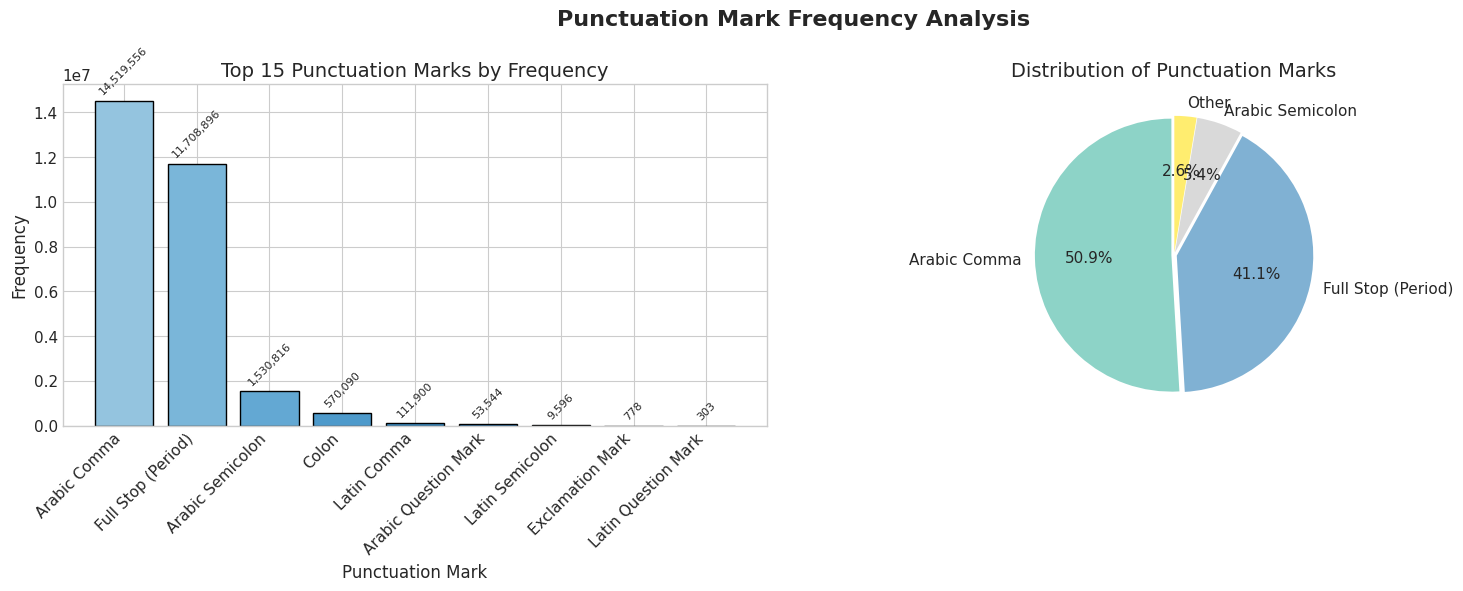

In [12]:
# ============================================================================
# ANALYSIS 2.2: PUNCTUATION MARK FREQUENCY
# ============================================================================

def analyze_punctuation_frequency(line_iterator, sample_size: int = 1000000) -> tuple:
    """
    Count the frequency of each punctuation mark in the corpus.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of lines to analyze
        
    Returns:
    --------
    tuple
        (punct_counts, total_chars) - Counter of punctuation and total character count
    """
    logger.info("=" * 70)
    logger.info("📍 PUNCTUATION MARK FREQUENCY ANALYSIS")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Initialize counter for punctuation marks
    punct_counts = Counter()
    
    # Track total characters for density calculation
    total_chars = 0
    total_lines = 0
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Counting punctuation")
        else:
            iterator = line_iterator
        
        for i, line in enumerate(iterator):
            # Stop after reaching sample size
            if i >= sample_size:
                break
            
            total_lines += 1
            
            # Count characters
            for char in line:
                total_chars += 1
                
                # Check if character is a known punctuation mark
                if char in PUNCTUATION_MARKS:
                    punct_counts[char] += 1
        
        logger.info(f"\n   ✅ Analyzed {format_number(total_lines)} lines")
        logger.info(f"   ✅ Processed {format_number(total_chars)} characters")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return Counter(), 0
    
    return punct_counts, total_chars


def display_punctuation_statistics(punct_counts: Counter, total_chars: int):
    """
    Display detailed statistics about punctuation marks.
    
    Parameters:
    -----------
    punct_counts : Counter
        Counter object with punctuation frequencies
    total_chars : int
        Total number of characters analyzed
    """
    if not punct_counts:
        logger.info("No punctuation data to display.")
        return
    
    # Calculate total punctuation marks
    total_punct = sum(punct_counts.values())
    
    logger.info("\n" + "-" * 70)
    logger.info("📊 PUNCTUATION FREQUENCY TABLE")
    logger.info("-" * 70)
    
    # Header
    logger.info(f"\n{'Mark':<8} {'Name':<30} {'Count':>15} {'% of Punct':>12} {'% of All':>10}")
    logger.info("=" * 80)
    
    # Display each punctuation mark
    for mark, count in punct_counts.most_common():
        name = PUNCTUATION_MARKS.get(mark, 'Unknown')
        pct_of_punct = (count / total_punct) * 100 if total_punct > 0 else 0
        pct_of_all = (count / total_chars) * 100 if total_chars > 0 else 0
        
        # Display mark (handle special characters)
        mark_display = repr(mark)[1:-1]  # Remove quotes from repr
        
        logger.info(f"{mark_display:<8} {name:<30} {count:>15,} {pct_of_punct:>11.2f}% {pct_of_all:>9.4f}%")
    
    # Summary statistics
    logger.info("\n" + "-" * 70)
    logger.info("📈 SUMMARY STATISTICS")
    logger.info("-" * 70)
    
    logger.info(f"\n   Total punctuation marks: {format_number(total_punct)}")
    logger.info(f"   Total characters analyzed: {format_number(total_chars)}")
    logger.info(f"   Punctuation density: {(total_punct/total_chars)*100:.2f}% of all characters")
    
    # --------------------------
    # Group by category
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📂 PUNCTUATION BY CATEGORY")
    logger.info("-" * 70)
    
    # Define categories
    categories = {
        'Sentence Terminals': ['.', '؟', '?', '!'],
        'Commas': ['،', ','],
        'Semicolons': ['؛', ';'],
        'Colons': [':'],
        'Quotation Marks': ['"', '"', '"', "'", '«', '»'],
        'Brackets': ['(', ')', '[', ']', '{', '}'],
        'Dashes': ['-', '–', '—'],
        'Other': ['…'],
    }
    
    logger.info(f"\n{'Category':<25} {'Count':>15} {'Percentage':>12}")
    logger.info("-" * 55)
    
    for category, marks in categories.items():
        category_count = sum(punct_counts.get(m, 0) for m in marks)
        if category_count > 0:
            pct = (category_count / total_punct) * 100
            logger.info(f"{category:<25} {category_count:>15,} {pct:>11.2f}%")
    
    # --------------------------
    # Arabic vs Latin punctuation
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("🔤 ARABIC VS LATIN PUNCTUATION")
    logger.info("-" * 70)
    
    arabic_punct = ['،', '؛', '؟']
    latin_punct = [',', ';', '?', '.', '!']
    
    arabic_count = sum(punct_counts.get(m, 0) for m in arabic_punct)
    latin_count = sum(punct_counts.get(m, 0) for m in latin_punct)
    
    logger.info(f"\n   Arabic punctuation (،؛؟): {format_number(arabic_count)} ({arabic_count/total_punct*100:.2f}%)")
    logger.info(f"   Latin punctuation (,;?.!): {format_number(latin_count)} ({latin_count/total_punct*100:.2f}%)")
    
    if arabic_count > 0 and latin_count > 0:
        ratio = latin_count / arabic_count
        logger.info(f"   Ratio (Latin/Arabic): {ratio:.2f}")
        
        if ratio > 0.1:
            logger.info("\n   ⚠️  Significant mix of Arabic and Latin punctuation.")
            logger.info("   → Consider normalizing to one system in preprocessing.")


def plot_punctuation_frequency(punct_counts: Counter):
    """
    Create visualizations of punctuation frequency distribution.
    
    Parameters:
    -----------
    punct_counts : Counter
        Counter object with punctuation frequencies
    """
    if not punct_counts:
        logger.info("No data to plot.")
        return
    
    # Get top 15 punctuation marks
    top_marks = punct_counts.most_common(15)
    
    # Prepare data for plotting
    marks = [PUNCTUATION_MARKS.get(m, m) for m, _ in top_marks]
    counts = [c for _, c in top_marks]
    
    # Calculate total for percentages
    total = sum(punct_counts.values())
    percentages = [(c / total) * 100 for c in counts]
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Punctuation Mark Frequency Analysis', fontsize=16, fontweight='bold')
    
    # --------------------------
    # Plot 1: Bar chart of counts
    # --------------------------
    ax1 = axes[0]
    
    # Create color palette
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(marks)))
    
    bars = ax1.bar(range(len(marks)), counts, color=colors, edgecolor='black')
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.annotate(f'{count:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, rotation=45)
    
    ax1.set_xticks(range(len(marks)))
    ax1.set_xticklabels(marks, rotation=45, ha='right')
    ax1.set_xlabel('Punctuation Mark')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Top 15 Punctuation Marks by Frequency')
    
    # --------------------------
    # Plot 2: Pie chart of distribution
    # --------------------------
    ax2 = axes[1]
    
    # Group small categories
    threshold = 2  # Percentage threshold
    main_marks = []
    main_pcts = []
    other_pct = 0
    
    for mark, pct in zip(marks, percentages):
        if pct >= threshold:
            main_marks.append(mark)
            main_pcts.append(pct)
        else:
            other_pct += pct
    
    if other_pct > 0:
        main_marks.append('Other')
        main_pcts.append(other_pct)
    
    # Create pie chart
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(main_marks)))
    wedges, texts, autotexts = ax2.pie(
        main_pcts, 
        labels=main_marks, 
        autopct='%1.1f%%',
        colors=colors_pie,
        explode=[0.02] * len(main_marks),
        startangle=90
    )
    
    ax2.set_title('Distribution of Punctuation Marks')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    save_figure(fig, 'punctuation_frequency.png')
    
    plt.show()


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

punct_counts, total_chars = analyze_punctuation_frequency(
    line_stream,
    sample_size=SAMPLE_SIZES['punctuation_frequency']
)

# Display statistics
display_punctuation_statistics(punct_counts, total_chars)

# Create visualizations
plot_punctuation_frequency(punct_counts)

#### 💡 Decision Impact Summary

| Finding | Decision |
|---------|----------|
| Comma most frequent (~50%) | Primary challenge is comma vs. period distinction |
| Full stop second (~40%) | Binary sentence boundary detection is viable |
| Question mark rare (<1%) | Severe class imbalance - need weighted loss |
| Exclamation very rare (<0.01%) | Consider merging with period or removing |
| Mixed Arabic/Latin punctuation | Need normalization in preprocessing |

### 2.3 Sentence Terminal Analysis

**What it is:** Analyzing specifically what marks end sentences.

**Why it matters:** Your primary task is sentence boundary detection.

**Key insight:** This tells us if each line truly represents a complete sentence.

🔚 SENTENCE TERMINAL ANALYSIS

⏳ Analyzing 11,731,360 sentences...


Analyzing terminals: 100%|██████████| 11731360/11731360 [00:47<00:00, 246247.49it/s]



   ✅ Analyzed 11,731,359 sentences

----------------------------------------------------------------------
📊 TERMINAL CHARACTER FREQUENCY
----------------------------------------------------------------------

Terminal     Name                                  Count Percentage

✅ STANDARD SENTENCE TERMINALS:
----------------------------------------------------------------------
'.'          Full Stop (Period)               11,708,758     99.81%
'؟'          Arabic Question Mark                 22,601      0.19%

----------------------------------------------------------------------
📈 SUMMARY
----------------------------------------------------------------------

   Sentences with standard terminals: 11,731,359 (100.00%)
   Sentences with other terminals:    0 (0.00%)

----------------------------------------------------------------------
📝 SAMPLE SENTENCES BY TERMINAL TYPE
----------------------------------------------------------------------

'.' (Full Stop (Period)):
   → ٣ - وعملا 

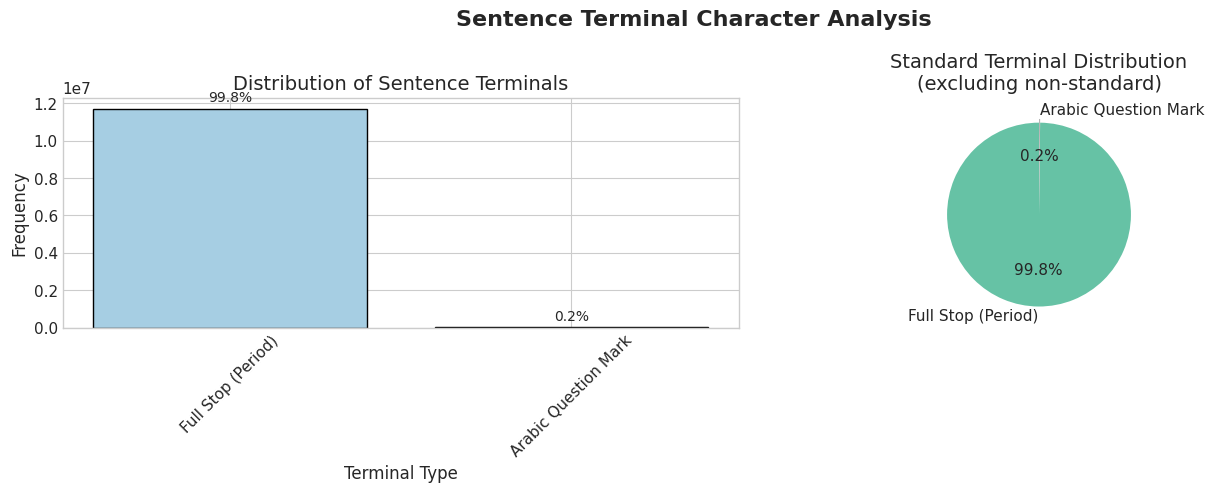

In [13]:
# ============================================================================
# ANALYSIS 2.3: SENTENCE TERMINAL ANALYSIS
# ============================================================================

def analyze_sentence_terminals(line_iterator, sample_size: int = 500000) -> tuple:
    """
    Analyze what punctuation marks end each sentence (line).
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze
        
    Returns:
    --------
    tuple
        (terminal_counts, samples_by_terminal) - Counter and sample sentences by terminal
    """
    logger.info("=" * 70)
    logger.info("🔚 SENTENCE TERMINAL ANALYSIS")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Initialize counters
    terminal_counts = Counter()
    
    # Store some example sentences for each terminal type
    samples_by_terminal = {}  # {terminal: [sample sentences]}
    max_samples_per_terminal = 3  # How many examples to keep
    
    # Track sentences without standard terminals
    no_standard_terminal = 0
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Analyzing terminals")
        else:
            iterator = line_iterator
        
        for i, line in enumerate(iterator):
            # Stop after reaching sample size
            if i >= sample_size:
                break
            
            # Strip whitespace
            line = line.strip()
            
            # Skip empty lines
            if not line:
                continue
            
            # Get the last character (terminal)
            terminal = line[-1]
            
            # Count this terminal
            terminal_counts[terminal] += 1
            
            # Check if it's a standard terminal
            if terminal not in SENTENCE_TERMINALS:
                no_standard_terminal += 1
            
            # Store sample sentences (limit to a few per terminal type)
            if terminal not in samples_by_terminal:
                samples_by_terminal[terminal] = []
            
            if len(samples_by_terminal[terminal]) < max_samples_per_terminal:
                # Store truncated version
                truncated = line[:100] + "..." if len(line) > 100 else line
                samples_by_terminal[terminal].append(truncated)
        
        logger.info(f"\n   ✅ Analyzed {format_number(sum(terminal_counts.values()))} sentences")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return Counter(), {}
    
    return terminal_counts, samples_by_terminal


def display_terminal_statistics(terminal_counts: Counter, samples_by_terminal: dict):
    """
    Display detailed statistics about sentence terminals.
    
    Parameters:
    -----------
    terminal_counts : Counter
        Counter of terminal characters
    samples_by_terminal : dict
        Dictionary mapping terminals to sample sentences
    """
    if not terminal_counts:
        logger.info("No data to display.")
        return
    
    total = sum(terminal_counts.values())
    
    logger.info("\n" + "-" * 70)
    logger.info("📊 TERMINAL CHARACTER FREQUENCY")
    logger.info("-" * 70)
    
    # Header
    logger.info(f"\n{'Terminal':<12} {'Name':<30} {'Count':>12} {'Percentage':>10}")
    logger.info("=" * 70)
    
    # Group terminals into standard and non-standard
    standard_terminals = []
    non_standard_terminals = []
    
    for terminal, count in terminal_counts.most_common():
        is_standard = terminal in SENTENCE_TERMINALS
        name = PUNCTUATION_MARKS.get(terminal, 'Other/Non-punctuation')
        pct = (count / total) * 100
        
        # Format terminal for display
        if terminal.isspace() or terminal == '':
            terminal_display = repr(terminal)
        else:
            terminal_display = f"'{terminal}'"
        
        row = (terminal, terminal_display, name, count, pct)
        
        if is_standard:
            standard_terminals.append(row)
        else:
            non_standard_terminals.append(row)
    
    # Display standard terminals first
    logger.info("\n✅ STANDARD SENTENCE TERMINALS:")
    logger.info("-" * 70)
    
    for terminal, display, name, count, pct in standard_terminals:
        logger.info(f"{display:<12} {name:<30} {count:>12,} {pct:>9.2f}%")
    
    # Display non-standard terminals
    if non_standard_terminals:
        logger.info("\n⚠️  NON-STANDARD TERMINALS (top 10):")
        logger.info("-" * 70)
        
        for terminal, display, name, count, pct in non_standard_terminals[:10]:
            logger.info(f"{display:<12} {name:<30} {count:>12,} {pct:>9.2f}%")
        
        if len(non_standard_terminals) > 10:
            remaining = len(non_standard_terminals) - 10
            remaining_count = sum(row[3] for row in non_standard_terminals[10:])
            logger.info(f"{'...':<12} {'[{} more types]'.format(remaining):<30} {remaining_count:>12,}")
    
    # --------------------------
    # Summary statistics
    # --------------------------
    standard_count = sum(row[3] for row in standard_terminals)
    non_standard_count = sum(row[3] for row in non_standard_terminals)
    
    logger.info("\n" + "-" * 70)
    logger.info("📈 SUMMARY")
    logger.info("-" * 70)
    
    logger.info(f"\n   Sentences with standard terminals: {format_number(standard_count)} ({standard_count/total*100:.2f}%)")
    logger.info(f"   Sentences with other terminals:    {format_number(non_standard_count)} ({non_standard_count/total*100:.2f}%)")
    
    # --------------------------
    # Sample sentences for each terminal
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📝 SAMPLE SENTENCES BY TERMINAL TYPE")
    logger.info("-" * 70)
    
    # Show samples for main terminal types
    main_terminals = ['.', '؟', '!', '،', '؛']
    
    for terminal in main_terminals:
        if terminal in samples_by_terminal and samples_by_terminal[terminal]:
            name = PUNCTUATION_MARKS.get(terminal, 'Unknown')
            logger.info(f"\n'{terminal}' ({name}):")
            for sample in samples_by_terminal[terminal]:
                logger.info(f"   → {sample}")
    
    # --------------------------
    # Recommendations
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("💡 RECOMMENDATIONS")
    logger.info("-" * 70)
    
    if non_standard_count / total > 0.05:
        logger.info("\n⚠️  More than 5% of sentences have non-standard terminals.")
        logger.info("   Consider:")
        logger.info("   1. Investigating these cases to understand why")
        logger.info("   2. Filtering them out if they represent noise")
        logger.info("   3. Including them as a separate class if meaningful")
    else:
        logger.info("\n✅ Most sentences have standard terminal punctuation.")
        logger.info("   The data quality is good for sentence boundary detection.")


def plot_terminal_distribution(terminal_counts: Counter):
    """
    Create visualizations of sentence terminal distribution.
    
    Parameters:
    -----------
    terminal_counts : Counter
        Counter of terminal characters
    """
    if not terminal_counts:
        logger.info("No data to plot.")
        return
    
    # Separate standard and non-standard terminals
    standard = {}
    other_count = 0
    
    for terminal, count in terminal_counts.items():
        if terminal in SENTENCE_TERMINALS:
            name = PUNCTUATION_MARKS.get(terminal, terminal)
            standard[name] = count
        else:
            other_count += count
    
    if other_count > 0:
        standard['Other'] = other_count
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Sentence Terminal Character Analysis', fontsize=16, fontweight='bold')
    
    # --------------------------
    # Plot 1: Bar chart
    # --------------------------
    ax1 = axes[0]
    
    names = list(standard.keys())
    counts = list(standard.values())
    total = sum(counts)
    
    # Sort by count
    sorted_pairs = sorted(zip(counts, names), reverse=True)
    counts_sorted = [c for c, n in sorted_pairs]
    names_sorted = [n for c, n in sorted_pairs]
    
    colors = plt.cm.Paired(np.linspace(0, 1, len(names_sorted)))
    bars = ax1.bar(names_sorted, counts_sorted, color=colors, edgecolor='black')
    
    # Add percentage labels
    for bar, count in zip(bars, counts_sorted):
        height = bar.get_height()
        pct = count / total * 100
        ax1.annotate(f'{pct:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
    
    ax1.set_xlabel('Terminal Type')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Sentence Terminals')
    ax1.tick_params(axis='x', rotation=45)
    
    # --------------------------
    # Plot 2: Pie chart (only standard terminals)
    # --------------------------
    ax2 = axes[1]
    
    # Filter to only standard terminals for pie
    standard_only = {k: v for k, v in standard.items() if k != 'Other'}
    
    if standard_only:
        names_pie = list(standard_only.keys())
        counts_pie = list(standard_only.values())
        
        colors_pie = plt.cm.Set2(np.linspace(0, 1, len(names_pie)))
        
        wedges, texts, autotexts = ax2.pie(
            counts_pie,
            labels=names_pie,
            autopct='%1.1f%%',
            colors=colors_pie,
            explode=[0.02] * len(names_pie),
            startangle=90
        )
        
        ax2.set_title('Standard Terminal Distribution\n(excluding non-standard)')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    save_figure(fig, 'sentence_terminals.png')
    
    plt.show()


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

terminal_counts, samples_by_terminal = analyze_sentence_terminals(
    line_stream,
    sample_size=SAMPLE_SIZES['sentence_terminals']
)

# Display statistics
display_terminal_statistics(terminal_counts, samples_by_terminal)

# Create visualizations
plot_terminal_distribution(terminal_counts)

#### 💡 Decision Impact Summary

| Finding | Decision |
|---------|----------|
| >95% end with standard terminals | Data quality is good for training |
| Full stop dominates | Primary focus should be period prediction |
| Some non-standard terminals | May need to filter or handle specially |
| Question marks present but rare | Class weighting needed |

---
## 4. Level 3: Intermediate Analysis

This section dives deeper into the linguistic patterns in the data.

**Key Questions Answered:**
- What vocabulary is used?
- What words appear near punctuation?
- What n-gram patterns precede punctuation?
- What parts of speech precede punctuation?

### 3.1 Word Frequency Analysis

**What it is:** Finding most common words in the corpus.

**Why it matters:** Understanding vocabulary helps with tokenization decisions.

**Key insights:**
- Vocabulary size affects tokenizer choice
- Common words may be stopwords
- Coverage analysis informs vocabulary size decisions

📚 VOCABULARY ANALYSIS

⏳ Analyzing 11,731,360 sentences...


Analyzing vocabulary: 100%|██████████| 11731360/11731360 [03:10<00:00, 61486.14it/s]



   ✅ Processed 301,161,206 words
   ✅ Found 1,268,199 unique words

----------------------------------------------------------------------
📊 VOCABULARY STATISTICS
----------------------------------------------------------------------

📈 Basic Metrics:
   • Total words (tokens):  301,161,206
   • Unique words (types):  1,268,199
   • Type-Token Ratio:      0.0042
   • Vocabulary richness:   0.42%

----------------------------------------------------------------------
📝 TOP 30 MOST COMMON WORDS
----------------------------------------------------------------------

Rank   Word                        Count Percentage Cumulative
1      في                     11,840,449      3.93%      3.93% 📍
2      من                      7,310,834      2.43%      6.36% 📍
3      على                     4,921,670      1.63%      7.99% 📍
4      ان                      3,862,400      1.28%      9.28% 
5      الى                     3,775,977      1.25%     10.53% 
6      التي                    2,415,701   

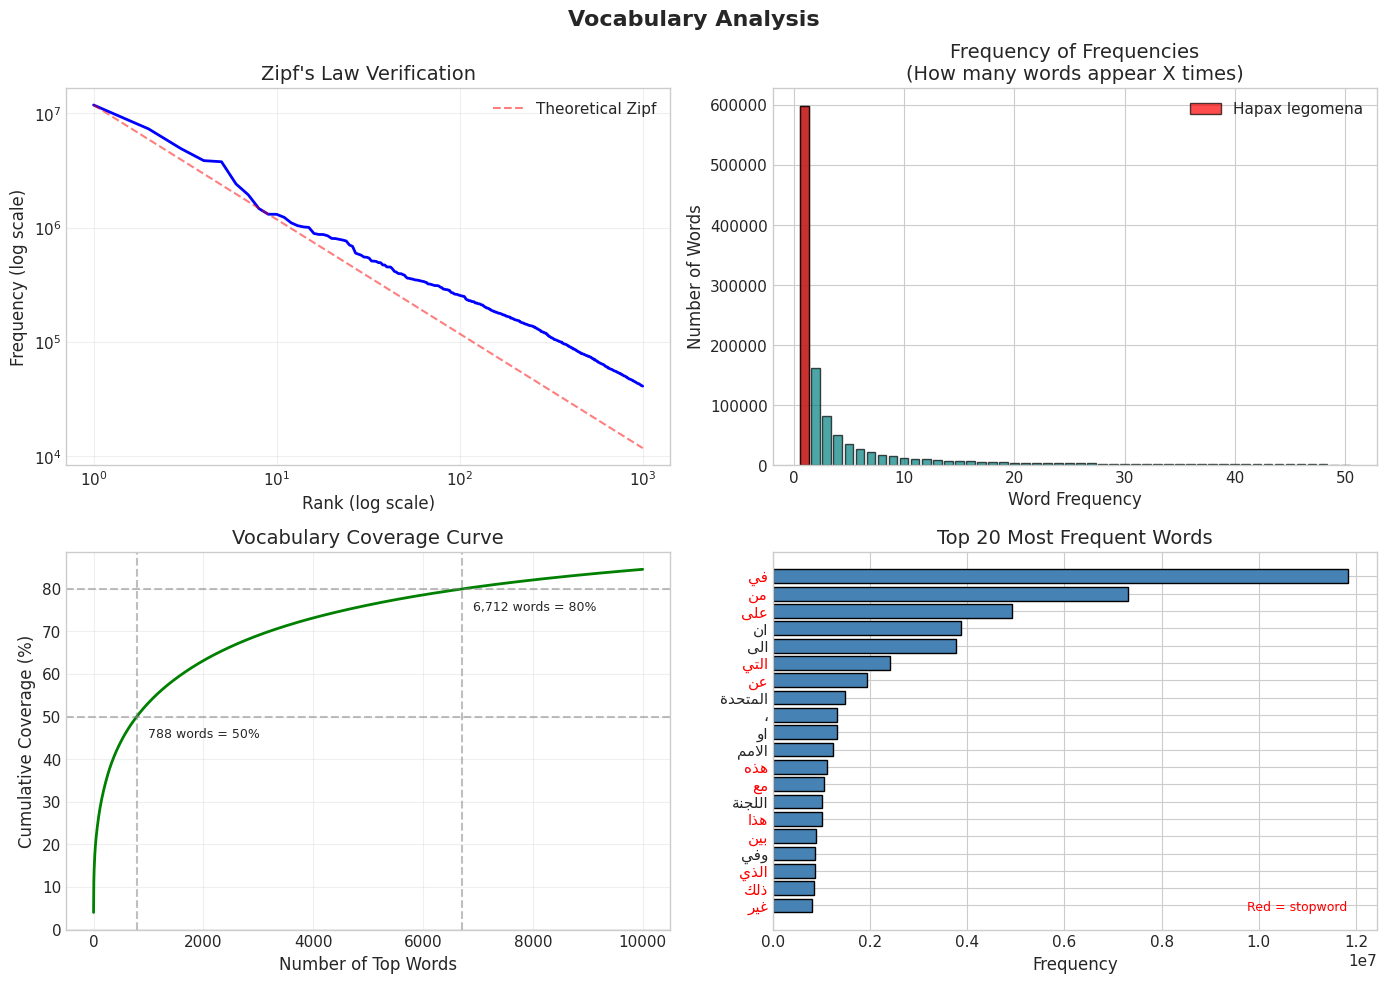

In [9]:
# ============================================================================
# ANALYSIS 3.1: WORD FREQUENCY ANALYSIS
# ============================================================================

def analyze_vocabulary(line_iterator, sample_size: int = 500000) -> tuple:
    """
    Analyze word frequencies in the corpus.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze
        
    Returns:
    --------
    tuple
        (word_freq, total_words) - Counter of word frequencies and total count
    """
    logger.info("=" * 70)
    logger.info("📚 VOCABULARY ANALYSIS")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Initialize word frequency counter
    word_freq = Counter()
    total_words = 0
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Analyzing vocabulary")
        else:
            iterator = line_iterator
        
        for i, line in enumerate(iterator):
            # Stop after reaching sample size
            if i >= sample_size:
                break
            
            # Extract Arabic words using regex pattern
            # This extracts only Arabic script characters as words
            words = ARABIC_WORD_PATTERN.findall(line)
            
            # Update frequency counter
            word_freq.update(words)
            
            # Count total words
            total_words += len(words)
        
        logger.info(f"\n   ✅ Processed {format_number(total_words)} words")
        logger.info(f"   ✅ Found {format_number(len(word_freq))} unique words")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return Counter(), 0
    
    return word_freq, total_words


def display_vocabulary_statistics(word_freq: Counter, total_words: int):
    """
    Display detailed vocabulary statistics.
    
    Parameters:
    -----------
    word_freq : Counter
        Counter of word frequencies
    total_words : int
        Total number of words
    """
    if not word_freq:
        logger.info("No vocabulary data to display.")
        return
    
    unique_words = len(word_freq)
    
    logger.info("\n" + "-" * 70)
    logger.info("📊 VOCABULARY STATISTICS")
    logger.info("-" * 70)
    
    # Basic statistics
    logger.info(f"\n📈 Basic Metrics:")
    logger.info(f"   • Total words (tokens):  {format_number(total_words)}")
    logger.info(f"   • Unique words (types):  {format_number(unique_words)}")
    logger.info(f"   • Type-Token Ratio:      {unique_words/total_words:.4f}")
    logger.info(f"   • Vocabulary richness:   {unique_words/total_words*100:.2f}%")
    
    # --------------------------
    # Top words
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📝 TOP 30 MOST COMMON WORDS")
    logger.info("-" * 70)
    
    logger.info(f"\n{'Rank':<6} {'Word':<20} {'Count':>12} {'Percentage':>10} {'Cumulative':>10}")
    logger.info("=" * 65)
    
    cumulative = 0
    for rank, (word, count) in enumerate(word_freq.most_common(30), 1):
        pct = (count / total_words) * 100
        cumulative += pct
        
        # Check if it's a stopword
        is_stopword = "📍" if word in ARABIC_STOPWORDS else ""
        
        logger.info(f"{rank:<6} {word:<20} {count:>12,} {pct:>9.2f}% {cumulative:>9.2f}% {is_stopword}")
    
    logger.info("\n   📍 = Known Arabic stopword")
    
    # --------------------------
    # Vocabulary coverage analysis
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📊 VOCABULARY COVERAGE ANALYSIS")
    logger.info("-" * 70)
    
    # Sort counts in descending order
    sorted_counts = sorted(word_freq.values(), reverse=True)
    
    # Calculate cumulative sum
    cumsum = np.cumsum(sorted_counts)
    
    # Find words needed for different coverage levels
    coverage_levels = [50, 80, 90, 95, 99]
    
    logger.info(f"\n   Words needed to cover X% of all text:")
    logger.info(f"   {'Coverage':<15} {'Words Needed':>15} {'% of Vocabulary':>18}")
    logger.info("   " + "-" * 50)
    
    for level in coverage_levels:
        target = total_words * (level / 100)
        words_needed = np.searchsorted(cumsum, target) + 1
        vocab_pct = (words_needed / unique_words) * 100
        logger.info(f"   {level}%{'':<12} {words_needed:>15,} {vocab_pct:>17.2f}%")
    
    # --------------------------
    # Hapax legomena analysis
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📊 WORD FREQUENCY DISTRIBUTION")
    logger.info("-" * 70)
    
    # Count words by frequency
    freq_of_freq = Counter(word_freq.values())
    
    hapax = freq_of_freq.get(1, 0)  # Words appearing exactly once
    dis_legomena = freq_of_freq.get(2, 0)  # Words appearing exactly twice
    
    logger.info(f"\n   Hapax legomena (words appearing once):   {format_number(hapax)} ({hapax/unique_words*100:.2f}% of vocabulary)")
    logger.info(f"   Dis legomena (words appearing twice):    {format_number(dis_legomena)} ({dis_legomena/unique_words*100:.2f}% of vocabulary)")
    logger.info(f"   Words appearing ≤5 times:                {sum(freq_of_freq[i] for i in range(1,6)):,}")
    logger.info(f"   Words appearing >100 times:              {sum(1 for w,c in word_freq.items() if c > 100):,}")
    
    # --------------------------
    # Recommendations
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("💡 RECOMMENDATIONS")
    logger.info("-" * 70)
    
    logger.info("\n   Based on vocabulary analysis:")
    
    if unique_words > 100000:
        logger.info("   1. ✅ Large vocabulary → Use subword tokenization (BPE/WordPiece)")
    else:
        logger.info("   1. Moderate vocabulary size → Could use word-level or subword tokenization")
    
    if hapax / unique_words > 0.4:
        logger.info("   2. ⚠️  Many rare words → Subword tokenization essential to handle OOV")
    
    logger.info("   3. Consider using a pre-trained Arabic tokenizer (AraBERT, CAMeLBERT)")


def plot_vocabulary_analysis(word_freq: Counter, total_words: int):
    """
    Create visualizations for vocabulary analysis.
    
    Parameters:
    -----------
    word_freq : Counter
        Counter of word frequencies
    total_words : int
        Total number of words
    """
    if not word_freq:
        logger.info("No data to plot.")
        return
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Vocabulary Analysis', fontsize=16, fontweight='bold')
    
    # --------------------------
    # Plot 1: Zipf's Law (log-log rank vs frequency)
    # --------------------------
    ax1 = axes[0, 0]
    
    # Get top 1000 words for Zipf's law plot
    top_words = word_freq.most_common(1000)
    ranks = range(1, len(top_words) + 1)
    frequencies = [count for _, count in top_words]
    
    ax1.loglog(ranks, frequencies, 'b-', linewidth=2)
    ax1.set_xlabel('Rank (log scale)')
    ax1.set_ylabel('Frequency (log scale)')
    ax1.set_title("Zipf's Law Verification")
    ax1.grid(True, alpha=0.3)
    
    # Add theoretical Zipf line for comparison
    zipf_theoretical = [frequencies[0] / r for r in ranks]
    ax1.loglog(ranks, zipf_theoretical, 'r--', alpha=0.5, label='Theoretical Zipf')
    ax1.legend()
    
    # --------------------------
    # Plot 2: Frequency of frequencies
    # --------------------------
    ax2 = axes[0, 1]
    
    freq_of_freq = Counter(word_freq.values())
    
    # Get frequencies up to 50 for visualization
    x_vals = sorted([f for f in freq_of_freq.keys() if f <= 50])
    y_vals = [freq_of_freq[x] for x in x_vals]
    
    ax2.bar(x_vals, y_vals, color='teal', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Word Frequency')
    ax2.set_ylabel('Number of Words')
    ax2.set_title('Frequency of Frequencies\n(How many words appear X times)')
    
    # Highlight hapax legomena
    if 1 in freq_of_freq:
        ax2.bar([1], [freq_of_freq[1]], color='red', edgecolor='black', alpha=0.7, label='Hapax legomena')
    ax2.legend()
    
    # --------------------------
    # Plot 3: Cumulative coverage
    # --------------------------
    ax3 = axes[1, 0]
    
    sorted_counts = sorted(word_freq.values(), reverse=True)
    cumsum = np.cumsum(sorted_counts) / total_words * 100
    
    # Plot up to 10000 words
    n_words = min(10000, len(cumsum))
    ax3.plot(range(1, n_words + 1), cumsum[:n_words], 'g-', linewidth=2)
    
    # Add reference lines
    for pct in [50, 80, 95]:
        idx = np.searchsorted(cumsum, pct)
        if idx < n_words:
            ax3.axhline(pct, color='gray', linestyle='--', alpha=0.5)
            ax3.axvline(idx, color='gray', linestyle='--', alpha=0.5)
            ax3.annotate(f'{idx:,} words = {pct}%', 
                        xy=(idx, pct), 
                        xytext=(idx + 200, pct - 5),
                        fontsize=9)
    
    ax3.set_xlabel('Number of Top Words')
    ax3.set_ylabel('Cumulative Coverage (%)')
    ax3.set_title('Vocabulary Coverage Curve')
    ax3.grid(True, alpha=0.3)
    
    # --------------------------
    # Plot 4: Top 20 words bar chart
    # --------------------------
    ax4 = axes[1, 1]
    
    top_20 = word_freq.most_common(20)
    words = [w for w, c in top_20]
    counts = [c for w, c in top_20]
    
    # Reverse for horizontal bar chart (most common at top)
    y_pos = range(len(words))
    ax4.barh(y_pos, counts[::-1], color='steelblue', edgecolor='black')
    ax4.set_yticks(y_pos)
    display_words = process_arabic_words(words[::-1])
    ax4.set_yticklabels(display_words)
    ax4.set_xlabel('Frequency')
    ax4.set_title('Top 20 Most Frequent Words')
    
    # Highlight stopwords
    for i, word in enumerate(words[::-1]):
        if word in ARABIC_STOPWORDS:
            ax4.get_yticklabels()[i].set_color('red')
    
    # Add note
    ax4.text(0.95, 0.05, 'Red = stopword', transform=ax4.transAxes, 
             fontsize=9, ha='right', color='red')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    save_figure(fig, 'vocabulary_analysis.png')
    
    plt.show()


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

word_freq, total_words = analyze_vocabulary(
    line_stream,
    sample_size=SAMPLE_SIZES['vocabulary']
)

# Display statistics
display_vocabulary_statistics(word_freq, total_words)

# Create visualizations
plot_vocabulary_analysis(word_freq, total_words)

#### 💡 Decision Impact Summary

| Finding | Decision |
|---------|----------|
| Large vocabulary (>100K words) | Use subword tokenization (BPE/WordPiece) |
| ~5000 words cover 80% of text | Could use limited vocabulary + UNK |
| Many hapax legomena | Subword tokenization handles rare words |
| Top words are mostly stopwords | Stopwords may not need punctuation prediction |
| Follows Zipf's law | Normal natural language distribution |

### 3.2 Punctuation Context Analysis

**What it is:** Analyzing what words appear before and after punctuation.

**Why it matters:** Reveals patterns that help models learn punctuation placement.

**Key insights:**
- Words that commonly precede punctuation are good predictors
- Words that follow punctuation can indicate sentence starts
- Can inform rule-based baselines

🔍 PUNCTUATION CONTEXT ANALYSIS

⏳ Analyzing 11,731,360 sentences...
   Context window: 3 words before/after


Analyzing contexts: 100%|██████████| 11731360/11731360 [05:38<00:00, 34694.05it/s]



   ✅ Analysis complete

📍 CONTEXT ANALYSIS FOR '،' (Arabic Comma)

🔹 Top 15 Words IMMEDIATELY BEFORE '،':
--------------------------------------------------
   عام                   176,869 (14.53%) 
   و                      48,252 ( 3.96%) 📍
   ديسمبر                 43,222 ( 3.55%) 
   يونيه                  35,084 ( 2.88%) 
   لعام                   28,826 ( 2.37%) 
   اكتوبر                 27,392 ( 2.25%) 
   نوفمبر                 27,203 ( 2.23%) 
   سبتمبر                 25,232 ( 2.07%) 
   مارس                   24,457 ( 2.01%) 
   يوليه                  23,782 ( 1.95%) 
   المادة                 23,307 ( 1.91%) 
   مايو                   22,646 ( 1.86%) 
   ابريل                  22,274 ( 1.83%) 
   يناير                  21,274 ( 1.75%) 
   القرار                 19,259 ( 1.58%) 

🔹 Top 15 Words IMMEDIATELY AFTER '،':
--------------------------------------------------
   و                      55,308 ( 4.29%) 📍
   الفقرة                 31,016 ( 2.40%) 
   في              

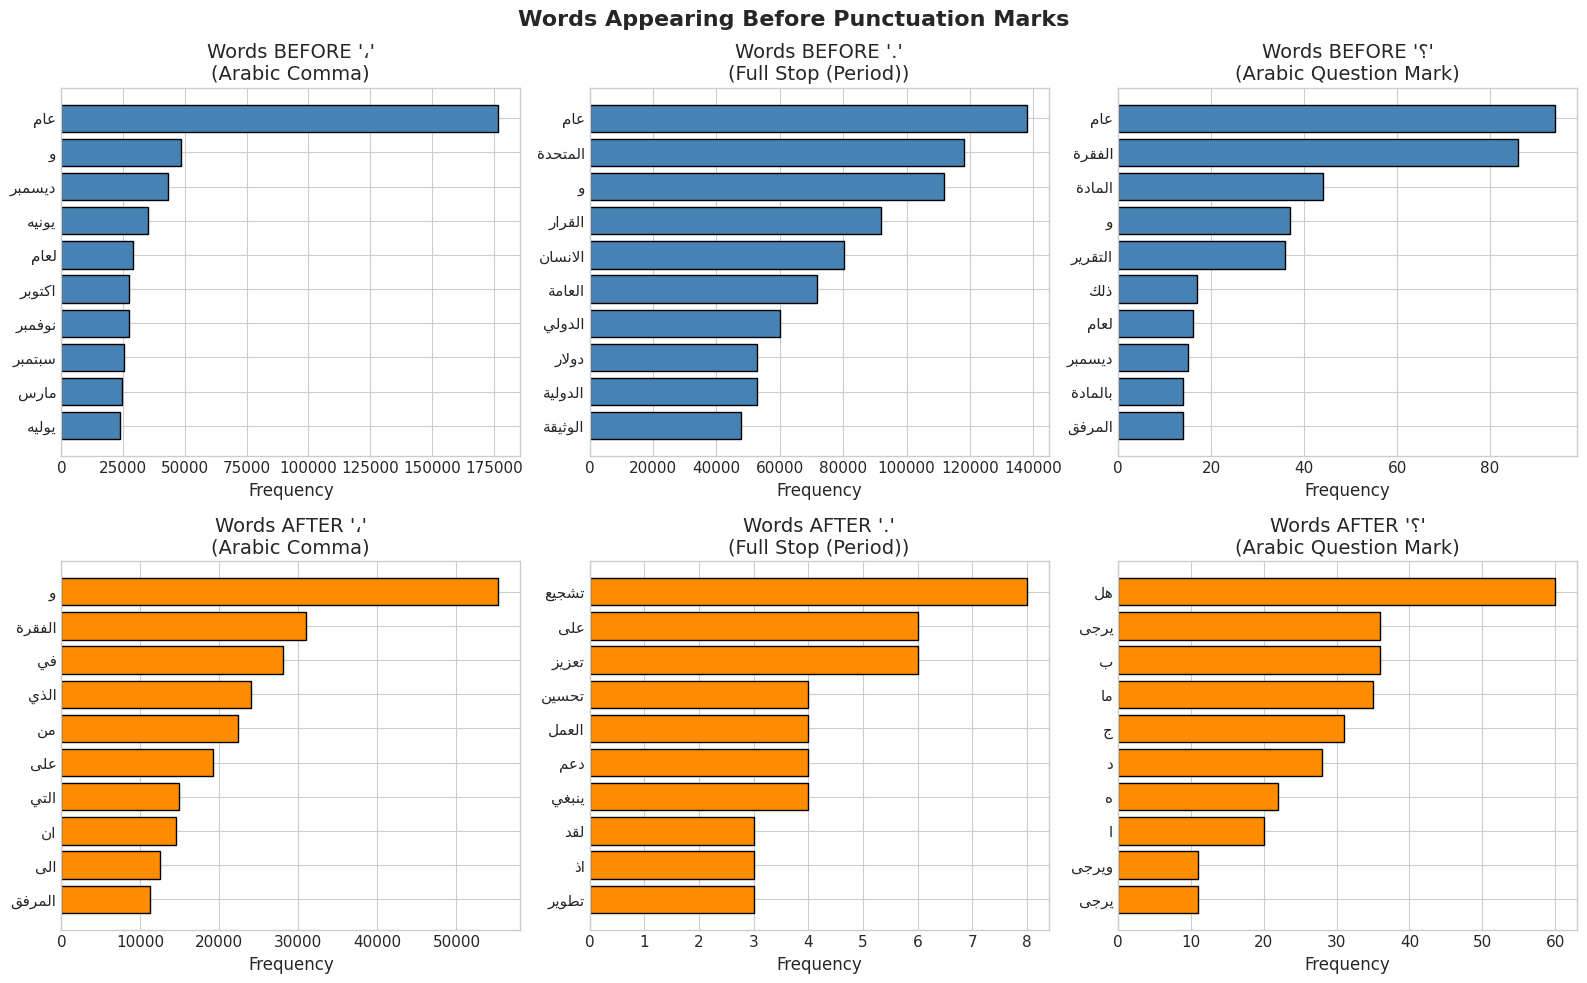

In [10]:
# ============================================================================
# ANALYSIS 3.2: PUNCTUATION CONTEXT ANALYSIS
# ============================================================================

def analyze_punctuation_context(line_iterator, sample_size: int = 200000, 
                                 context_size: int = 3) -> dict:
    """
    Analyze words appearing before and after punctuation marks.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze
    context_size : int
        Number of words before/after punctuation to consider
        
    Returns:
    --------
    dict
        Dictionary mapping punctuation to context word counts
    """
    logger.info("=" * 70)
    logger.info("🔍 PUNCTUATION CONTEXT ANALYSIS")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    logger.info(f"   Context window: {context_size} words before/after")
    
    # Define punctuation marks to analyze
    punct_marks_to_analyze = ['،', '.', '؟', '؛', ':', '!']
    
    # Initialize context storage
    # Structure: {punct: {'before': Counter, 'after': Counter, 'immediate_before': Counter}}
    contexts = {
        p: {
            'before': Counter(),      # All words in context window before
            'after': Counter(),       # All words in context window after
            'immediate_before': Counter(),  # Word immediately before
            'immediate_after': Counter(),   # Word immediately after
        } 
        for p in punct_marks_to_analyze
    }
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Analyzing contexts")
        else:
            iterator = line_iterator
        
        for line_num, line in enumerate(iterator):
            # Stop after reaching sample size
            if line_num >= sample_size:
                break
            
            # Tokenize the line, preserving punctuation positions
            tokens = []
            current_word = ""
            
            for char in line:
                # Check if character is part of an Arabic word
                if '\u0600' <= char <= '\u06FF':
                    current_word += char
                else:
                    # End of current word (if any)
                    if current_word:
                        tokens.append(current_word)
                        current_word = ""
                    
                    # Add punctuation mark as separate token
                    if char in punct_marks_to_analyze:
                        tokens.append(char)
            
            # Don't forget last word
            if current_word:
                tokens.append(current_word)
            
            # Extract contexts for each punctuation mark
            for j, token in enumerate(tokens):
                if token in punct_marks_to_analyze:
                    # Words BEFORE punctuation
                    for k in range(max(0, j - context_size), j):
                        if tokens[k] not in punct_marks_to_analyze:
                            contexts[token]['before'][tokens[k]] += 1
                            
                            # Track immediate word before
                            if k == j - 1:
                                contexts[token]['immediate_before'][tokens[k]] += 1
                    
                    # Words AFTER punctuation
                    for k in range(j + 1, min(len(tokens), j + context_size + 1)):
                        if tokens[k] not in punct_marks_to_analyze:
                            contexts[token]['after'][tokens[k]] += 1
                            
                            # Track immediate word after
                            if k == j + 1:
                                contexts[token]['immediate_after'][tokens[k]] += 1
        
        logger.info(f"\n   ✅ Analysis complete")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return {}
    
    return contexts


def display_context_analysis(contexts: dict):
    """
    Display detailed context analysis results.
    
    Parameters:
    -----------
    contexts : dict
        Dictionary mapping punctuation to context word counts
    """
    if not contexts:
        logger.info("No context data to display.")
        return
    
    # Analyze main punctuation marks
    main_puncts = ['،', '.', '؟']
    
    for punct in main_puncts:
        if punct not in contexts:
            continue
            
        name = PUNCTUATION_MARKS.get(punct, punct)
        ctx = contexts[punct]
        
        logger.info("\n" + "=" * 70)
        logger.info(f"📍 CONTEXT ANALYSIS FOR '{punct}' ({name})")
        logger.info("=" * 70)
        
        # --------------------------
        # Words immediately before
        # --------------------------
        logger.info(f"\n🔹 Top 15 Words IMMEDIATELY BEFORE '{punct}':")
        logger.info("-" * 50)
        
        if ctx['immediate_before']:
            total_before = sum(ctx['immediate_before'].values())
            for word, count in ctx['immediate_before'].most_common(15):
                pct = (count / total_before) * 100
                is_stopword = "📍" if word in ARABIC_STOPWORDS else ""
                logger.info(f"   {word:<20} {count:>8,} ({pct:>5.2f}%) {is_stopword}")
        else:
            logger.info("   [No data]")
        
        # --------------------------
        # Words immediately after
        # --------------------------
        logger.info(f"\n🔹 Top 15 Words IMMEDIATELY AFTER '{punct}':")
        logger.info("-" * 50)
        
        if ctx['immediate_after']:
            total_after = sum(ctx['immediate_after'].values())
            for word, count in ctx['immediate_after'].most_common(15):
                pct = (count / total_after) * 100
                is_stopword = "📍" if word in ARABIC_STOPWORDS else ""
                logger.info(f"   {word:<20} {count:>8,} ({pct:>5.2f}%) {is_stopword}")
        else:
            logger.info("   [No data]")
        
        # --------------------------
        # All words in context window before
        # --------------------------
        logger.info(f"\n🔹 Top 15 Words in {3}-Word Window BEFORE '{punct}':")
        logger.info("-" * 50)
        
        if ctx['before']:
            total_context = sum(ctx['before'].values())
            for word, count in ctx['before'].most_common(15):
                pct = (count / total_context) * 100
                logger.info(f"   {word:<20} {count:>8,} ({pct:>5.2f}%)")
        else:
            logger.info("   [No data]")
    
    # --------------------------
    # Cross-punctuation comparison
    # --------------------------
    logger.info("\n" + "=" * 70)
    logger.info("📊 CROSS-PUNCTUATION COMPARISON")
    logger.info("=" * 70)
    
    logger.info("\n   Words that commonly precede PERIODS but not COMMAS:")
    
    period_before = set(w for w, c in contexts.get('.', {}).get('immediate_before', Counter()).most_common(50))
    comma_before = set(w for w, c in contexts.get('،', {}).get('immediate_before', Counter()).most_common(50))
    
    period_unique = period_before - comma_before
    if period_unique:
        logger.info(f"   {list(period_unique)[:10]}")
    else:
        logger.info("   [No distinctive patterns found]")
    
    logger.info("\n   Words that commonly precede COMMAS but not PERIODS:")
    comma_unique = comma_before - period_before
    if comma_unique:
        logger.info(f"   {list(comma_unique)[:10]}")
    else:
        logger.info("   [No distinctive patterns found]")


def plot_context_analysis(contexts: dict):
    """
    Create visualizations for punctuation context analysis.
    
    Parameters:
    -----------
    contexts : dict
        Dictionary mapping punctuation to context word counts
    """
    if not contexts:
        logger.info("No data to plot.")
        return
    
    # Create figure with subplots for main punctuation marks
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle('Words Appearing Before Punctuation Marks', fontsize=16, fontweight='bold')
    
    puncts = ['،', '.', '؟']
    
    for idx, punct in enumerate(puncts):
        if punct not in contexts:
            continue
            
        name = PUNCTUATION_MARKS.get(punct, punct)
        ctx = contexts[punct]
        
        # Plot for words before
        ax_before = axes[0, idx]
        if ctx['immediate_before']:
            top_words = ctx['immediate_before'].most_common(10)
            words = [w for w, c in top_words]
            counts = [c for w, c in top_words]
            
            y_pos = range(len(words))
            ax_before.barh(y_pos, counts[::-1], color='steelblue', edgecolor='black')
            ax_before.set_yticks(y_pos)
            display_words = process_arabic_words(words[::-1])
            ax_before.set_yticklabels(display_words)
            ax_before.set_xlabel('Frequency')
            ax_before.set_title(f"Words BEFORE '{punct}'\n({name})")
        
        # Plot for words after
        ax_after = axes[1, idx]
        if ctx['immediate_after']:
            top_words = ctx['immediate_after'].most_common(10)
            words = [w for w, c in top_words]
            counts = [c for w, c in top_words]
            
            y_pos = range(len(words))
            ax_after.barh(y_pos, counts[::-1], color='darkorange', edgecolor='black')
            ax_after.set_yticks(y_pos)
            display_words = process_arabic_words(words[::-1])
            ax_after.set_yticklabels(display_words)
            ax_after.set_xlabel('Frequency')
            ax_after.set_title(f"Words AFTER '{punct}'\n({name})")
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    save_figure(fig, 'punctuation_context.png')
    
    plt.show()


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

contexts = analyze_punctuation_context(
    line_stream,
    sample_size=SAMPLE_SIZES['punctuation_context'],
    context_size=3
)

# Display results
display_context_analysis(contexts)

# Create visualizations
plot_context_analysis(contexts)

#### 💡 Decision Impact Summary

| Finding | Decision |
|---------|----------|
| Certain words strongly predict punctuation | Use as features in model |
| Different words precede different punctuation | Multi-class is distinguishable |
| Many stopwords in context | May need to look beyond immediate word |
| "و" (and) often follows punctuation | Sentence often starts with conjunctions |

### 3.3 N-gram Analysis Before Punctuation

**What it is:** Analyzing multi-word patterns before punctuation marks.

**Why it matters:** Captures phrasal patterns that trigger punctuation.

**Key insights:**
- Bigrams and trigrams can be more predictive than single words
- Common phrases before punctuation can inform rules
- Useful for feature engineering

In [16]:
# ============================================================================
# ANALYSIS 3.3: N-GRAM ANALYSIS BEFORE PUNCTUATION
# ============================================================================

def analyze_ngrams_before_punct(line_iterator, n: int = 3, 
                                 sample_size: int = 200000) -> dict:
    """
    Analyze n-grams appearing before punctuation marks.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    n : int
        Size of n-gram (2=bigram, 3=trigram, etc.)
    sample_size : int
        Number of sentences to analyze
        
    Returns:
    --------
    dict
        Dictionary mapping punctuation to n-gram counts
    """
    logger.info("=" * 70)
    logger.info(f"📊 {n}-GRAM ANALYSIS BEFORE PUNCTUATION")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Define punctuation marks to analyze
    punct_marks = ['،', '.', '؟', '؛']
    
    # Initialize n-gram counters for each punctuation
    ngram_counts = {p: Counter() for p in punct_marks}
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc=f"Analyzing {n}-grams")
        else:
            iterator = line_iterator
        
        for line_num, line in enumerate(iterator):
            # Stop after reaching sample size
            if line_num >= sample_size:
                break
            
            # Extract Arabic words
            words = ARABIC_WORD_PATTERN.findall(line)
            
            # For each punctuation mark, find n-grams before it
            for punct in punct_marks:
                # Split line by this punctuation mark
                parts = line.split(punct)
                
                # For each part (except the last), get the n-gram before the split
                for part in parts[:-1]:  # Exclude last part (no punct after it)
                    # Get words in this part
                    part_words = ARABIC_WORD_PATTERN.findall(part)
                    
                    # If we have enough words for the n-gram
                    if len(part_words) >= n:
                        # Get the last n words
                        ngram = ' '.join(part_words[-n:])
                        ngram_counts[punct][ngram] += 1
        
        logger.info(f"\n   ✅ Analysis complete")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return {}
    
    return ngram_counts


def display_ngram_analysis(ngram_counts: dict, n: int):
    """
    Display n-gram analysis results.
    
    Parameters:
    -----------
    ngram_counts : dict
        Dictionary mapping punctuation to n-gram counts
    n : int
        Size of n-grams
    """
    if not ngram_counts:
        logger.info("No n-gram data to display.")
        return
    
    # Display for each punctuation mark
    for punct in ['،', '.', '؟']:
        if punct not in ngram_counts:
            continue
            
        name = PUNCTUATION_MARKS.get(punct, punct)
        counts = ngram_counts[punct]
        
        if not counts:
            continue
        
        logger.info("\n" + "=" * 70)
        logger.info(f"📊 TOP {n}-GRAMS BEFORE '{punct}' ({name})")
        logger.info("=" * 70)
        
        total = sum(counts.values())
        logger.info(f"\n   Total {n}-grams found: {format_number(total)}")
        logger.info(f"\n   Top 20 most common {n}-grams:")
        logger.info("-" * 60)
        
        for rank, (ngram, count) in enumerate(counts.most_common(20), 1):
            pct = (count / total) * 100
            logger.info(f"   {rank:>2}. {ngram:<40} {count:>8,} ({pct:>5.2f}%)")
    
    # --------------------------
    # Compare n-grams across punctuation
    # --------------------------
    logger.info("\n" + "=" * 70)
    logger.info(f"📊 {n}-GRAM OVERLAP ANALYSIS")
    logger.info("=" * 70)
    
    # Get top n-grams for period and comma
    period_ngrams = set(ng for ng, c in ngram_counts.get('.', Counter()).most_common(100))
    comma_ngrams = set(ng for ng, c in ngram_counts.get('،', Counter()).most_common(100))
    
    overlap = period_ngrams & comma_ngrams
    period_only = period_ngrams - comma_ngrams
    comma_only = comma_ngrams - period_ngrams
    
    logger.info(f"\n   Among top 100 {n}-grams for each:")
    logger.info(f"   • {n}-grams appearing before BOTH period and comma: {len(overlap)}")
    logger.info(f"   • {n}-grams unique to period: {len(period_only)}")
    logger.info(f"   • {n}-grams unique to comma: {len(comma_only)}")
    
    logger.info(f"\n   Examples of {n}-grams unique to PERIOD (sentence boundaries):")
    for ng in list(period_only)[:5]:
        logger.info(f"      {ng}")
    
    logger.info(f"\n   Examples of {n}-grams unique to COMMA (clause boundaries):")
    for ng in list(comma_only)[:5]:
        logger.info(f"      {ng}")


# Run the analysis for trigrams
line_stream = iter_dataset_lines(DATASET_DIR)

ngrams_3 = analyze_ngrams_before_punct(
    line_stream,
    n=3,
    sample_size=SAMPLE_SIZES['ngrams']
)

# Display results
display_ngram_analysis(ngrams_3, n=3)

# Also analyze bigrams
logger.info("\n" + "#" * 70)
logger.info("# BIGRAM ANALYSIS")
logger.info("#" * 70)

line_stream = iter_dataset_lines(DATASET_DIR)

ngrams_2 = analyze_ngrams_before_punct(
    line_stream,
    n=2,
    sample_size=SAMPLE_SIZES['ngrams']
)

display_ngram_analysis(ngrams_2, n=2)

📊 3-GRAM ANALYSIS BEFORE PUNCTUATION

⏳ Analyzing 11,731,360 sentences...


Analyzing 3-grams: 100%|██████████| 11731360/11731360 [04:38<00:00, 42067.24it/s]



   ✅ Analysis complete

📊 TOP 3-GRAMS BEFORE '،' (Arabic Comma)

   Total 3-grams found: 11,882,824

   Top 20 most common 3-grams:
------------------------------------------------------------
    1. كانون الاول ديسمبر                         49,249 ( 0.41%)
    2. وعلاوة على ذلك                             48,999 ( 0.41%)
    3. وفي هذا الصدد                              45,867 ( 0.39%)
    4. وبالاضافة الى ذلك                          42,043 ( 0.35%)
    5. تشرين الاول اكتوبر                         35,685 ( 0.30%)
    6. تشرين الثاني نوفمبر                        35,558 ( 0.30%)
    7. كانون الثاني يناير                         25,320 ( 0.21%)
    8. على سبيل المثال                            18,638 ( 0.16%)
    9. في هذا الصدد                               18,279 ( 0.15%)
   10. وفي هذا السياق                             16,263 ( 0.14%)
   11. في جملة امور                               16,209 ( 0.14%)
   12. الامم المتحدة الانمائي                     15,042 ( 0.13%)
   13. في حزير

Analyzing 2-grams: 100%|██████████| 11731360/11731360 [04:37<00:00, 42257.02it/s]



   ✅ Analysis complete

📊 TOP 2-GRAMS BEFORE '،' (Arabic Comma)

   Total 2-grams found: 13,037,830

   Top 20 most common 2-grams:
------------------------------------------------------------
    1. الامم المتحدة                              92,863 ( 0.71%)
    2. على ذلك                                    74,288 ( 0.57%)
    3. في عام                                     70,601 ( 0.54%)
    4. الى ذلك                                    70,246 ( 0.54%)
    5. هذا الصدد                                  64,311 ( 0.49%)
    6. حقوق الانسان                               55,011 ( 0.42%)
    7. الاول ديسمبر                               49,770 ( 0.38%)
    8. الجمعية العامة                             44,113 ( 0.34%)
    9. حزيران يونيه                               42,073 ( 0.32%)
   10. سبيل المثال                                39,518 ( 0.30%)
   11. ومع ذلك                                    36,394 ( 0.28%)
   12. الاول اكتوبر                               36,135 ( 0.28%)
   13. الثاني 

#### 💡 Decision Impact Summary

| Finding | Decision |
|---------|----------|
| Common n-grams before punctuation | Can use as features in model |
| Some n-grams unique to period vs comma | Multi-class prediction is feasible |
| Legal phrases common | Reflects UN document domain |
| Could create rule-based baseline | Useful for comparison with ML models |

### 3.4 Sentence Structure Patterns (POS Analysis)

**What it is:** Analyzing POS tag patterns and syntactic structures.

**Why it matters:** Punctuation often depends on grammatical structure (theme-rheme completion).

**Note:** This analysis requires the CAMeL Tools library. If not installed, we'll provide
a simplified version.

In [17]:
%pip install camel-tools

In [18]:
!camel_data -i morphology-db-msa-r13

No new packages will be installed.


In [19]:
# ============================================================================
# ANALYSIS 3.4: SENTENCE STRUCTURE PATTERNS (POS ANALYSIS)
# ============================================================================

# Check if CAMeL Tools is available
CAMEL_AVAILABLE = False
try:
    from camel_tools.morphology.analyzer import Analyzer
    from camel_tools.morphology.database import MorphologyDB
    from camel_tools.tokenizers.word import simple_word_tokenize
    CAMEL_AVAILABLE = True
    logger.info("✅ CAMeL Tools is available - Full POS analysis will be performed")
except ImportError:
    logger.info("⚠️  CAMeL Tools not installed - Simplified analysis will be performed")
    logger.info("   To install: pip install camel-tools")
    logger.info("   Then download data: camel_data -i morphology-db-msa-s31")


def analyze_pos_patterns_full(line_iterator, sample_size: int = 10000) -> dict:
    """
    Analyze POS tag patterns before punctuation using CAMeL Tools.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze (keep small - POS tagging is slow)
        
    Returns:
    --------
    dict
        Dictionary mapping punctuation to POS tag counts
    """
    logger.info("=" * 70)
    logger.info("🏷️  POS TAG ANALYSIS BEFORE PUNCTUATION")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    logger.info("   (Note: POS tagging is computationally intensive)")
    
    # Initialize CAMeL analyzer
    try:
        db = MorphologyDB.builtin_db()
        analyzer = Analyzer(db)
    except Exception as e:
        logger.info(f"\n❌ ERROR initializing CAMeL analyzer: {e}")
        return {}
    
    # Define punctuation marks to analyze
    punct_marks = ['،', '.', '؟']
    
    # Initialize POS counters
    pos_before_punct = {p: Counter() for p in punct_marks}
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="POS analysis")
        else:
            iterator = line_iterator
        
        for line_num, line in enumerate(iterator):
            # Stop after reaching sample size
            if line_num >= sample_size:
                break
            
            # Tokenize the line
            tokens = simple_word_tokenize(line)
            
            # Find punctuation and get POS of word before
            for j, token in enumerate(tokens):
                if token in punct_marks and j > 0:
                    # Get the word before punctuation
                    prev_token = tokens[j - 1]
                    
                    # Analyze the word
                    analyses = analyzer.analyze(prev_token)
                    
                    if analyses:
                        # Get POS from first analysis
                        pos = analyses[0].get('pos', 'UNK')
                        pos_before_punct[token][pos] += 1
                    else:
                        pos_before_punct[token]['UNK'] += 1
        
        logger.info(f"\n   ✅ Analysis complete")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return {}
    
    return pos_before_punct


def analyze_pos_patterns_simplified(line_iterator, sample_size: int = 50000) -> dict:
    """
    Simplified POS-like analysis using morphological patterns.
    
    This function uses heuristics based on Arabic word endings and patterns
    to approximate POS tags without requiring external libraries.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze
        
    Returns:
    --------
    dict
        Dictionary mapping punctuation to morphological pattern counts
    """
    logger.info("=" * 70)
    logger.info("🏷️  MORPHOLOGICAL PATTERN ANALYSIS (Simplified POS)")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Define punctuation marks to analyze
    punct_marks = ['،', '.', '؟']
    
    # Initialize pattern counters
    pattern_before_punct = {p: Counter() for p in punct_marks}
    
    # Define morphological patterns (simplified heuristics)
    def get_morphological_pattern(word):
        """
        Get a simplified morphological pattern for an Arabic word.
        This is a heuristic-based approach.
        """
        if not word:
            return 'EMPTY'
        
        # Check for common endings
        if word.endswith('ة'):  # Taa marbuta - often nouns
            return 'NOUN_FEMININE'
        elif word.endswith('ون') or word.endswith('ين'):  # Masculine plural
            return 'NOUN_MASC_PLURAL'
        elif word.endswith('ات'):  # Feminine plural
            return 'NOUN_FEM_PLURAL'
        elif word.endswith('ي'):  # Nisba adjective or possessive
            return 'ADJECTIVE_NISBA'
        elif word.endswith('ا'):  # Alef ending
            if len(word) > 3:
                return 'NOUN_OR_VERB'
            return 'PARTICLE'
        elif word.startswith('ال'):  # Definite article
            return 'NOUN_DEFINITE'
        elif word.startswith('و') or word.startswith('ف'):  # Conjunctions
            if len(word) == 1:
                return 'CONJUNCTION'
            return 'CONJ_PREFIX'
        elif word.startswith('ب') or word.startswith('ل') or word.startswith('ك'):
            if len(word) <= 3:
                return 'PREPOSITION'
            return 'PREP_PREFIX'
        elif len(word) <= 2:
            return 'PARTICLE'
        elif len(word) >= 5 and word.startswith('است'):  # Form X verb
            return 'VERB_FORM_X'
        elif len(word) >= 4:
            # Check for verb patterns
            if word[1] in 'او':  # Second letter is waw/alef - possible verb
                return 'VERB_POSSIBLE'
            return 'NOUN_OR_ADJ'
        else:
            return 'OTHER'
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Pattern analysis")
        else:
            iterator = line_iterator
        
        for line_num, line in enumerate(iterator):
            # Stop after reaching sample size
            if line_num >= sample_size:
                break
            
            # Tokenize preserving punctuation
            tokens = []
            current_word = ""
            
            for char in line:
                if '\u0600' <= char <= '\u06FF':
                    current_word += char
                else:
                    if current_word:
                        tokens.append(current_word)
                        current_word = ""
                    if char in punct_marks:
                        tokens.append(char)
            
            if current_word:
                tokens.append(current_word)
            
            # Find punctuation and get pattern of word before
            for j, token in enumerate(tokens):
                if token in punct_marks and j > 0:
                    prev_token = tokens[j - 1]
                    pattern = get_morphological_pattern(prev_token)
                    pattern_before_punct[token][pattern] += 1
        
        logger.info(f"\n   ✅ Analysis complete")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return {}
    
    return pattern_before_punct


def display_pos_analysis(pos_counts: dict, analysis_type: str = "POS"):
    """
    Display POS/pattern analysis results.
    
    Parameters:
    -----------
    pos_counts : dict
        Dictionary mapping punctuation to POS/pattern counts
    analysis_type : str
        Type of analysis ("POS" or "Pattern")
    """
    if not pos_counts:
        logger.info("No POS data to display.")
        return
    
    for punct in ['،', '.', '؟']:
        if punct not in pos_counts:
            continue
            
        name = PUNCTUATION_MARKS.get(punct, punct)
        counts = pos_counts[punct]
        
        if not counts:
            continue
        
        total = sum(counts.values())
        
        logger.info("\n" + "=" * 70)
        logger.info(f"🏷️  {analysis_type} TAGS BEFORE '{punct}' ({name})")
        logger.info("=" * 70)
        
        logger.info(f"\n   Total instances: {format_number(total)}")
        logger.info(f"\n   {'Tag/Pattern':<25} {'Count':>12} {'Percentage':>10}")
        logger.info("   " + "-" * 50)
        
        for tag, count in counts.most_common(15):
            pct = (count / total) * 100
            logger.info(f"   {tag:<25} {count:>12,} {pct:>9.2f}%")
    
    # --------------------------
    # Pattern comparison
    # --------------------------
    logger.info("\n" + "=" * 70)
    logger.info(f"📊 {analysis_type} PATTERN COMPARISON")
    logger.info("=" * 70)
    
    # Compare period vs comma
    if '.' in pos_counts and '،' in pos_counts:
        period_total = sum(pos_counts['.'].values())
        comma_total = sum(pos_counts['،'].values())
        
        logger.info(f"\n   Comparing patterns before PERIOD vs COMMA:")
        logger.info(f"\n   {'Pattern':<25} {'Before Period':>15} {'Before Comma':>15}")
        logger.info("   " + "-" * 60)
        
        all_patterns = set(pos_counts['.'].keys()) | set(pos_counts['،'].keys())
        
        for pattern in sorted(all_patterns):
            period_count = pos_counts['.'].get(pattern, 0)
            comma_count = pos_counts['،'].get(pattern, 0)
            
            period_pct = (period_count / period_total * 100) if period_total > 0 else 0
            comma_pct = (comma_count / comma_total * 100) if comma_total > 0 else 0
            
            # Only show if there's meaningful data
            if period_count > 100 or comma_count > 100:
                logger.info(f"   {pattern:<25} {period_pct:>14.1f}% {comma_pct:>14.1f}%")


# Run the appropriate analysis
if CAMEL_AVAILABLE:
    line_stream = iter_dataset_lines(DATASET_DIR)

    pos_patterns = analyze_pos_patterns_full(
        line_stream,
        sample_size=SAMPLE_SIZES['pos_analysis']
    )
    display_pos_analysis(pos_patterns, "POS")
else:
    # Use simplified analysis
    line_stream = iter_dataset_lines(DATASET_DIR)

    morph_patterns = analyze_pos_patterns_simplified(
        line_stream,
        sample_size=SAMPLE_SIZES['pos_analysis'] * 5  # Can handle more without CAMeL
    )
    display_pos_analysis(morph_patterns, "Morphological Pattern")

✅ CAMeL Tools is available - Full POS analysis will be performed
🏷️  POS TAG ANALYSIS BEFORE PUNCTUATION

⏳ Analyzing 10,000 sentences...
   (Note: POS tagging is computationally intensive)


POS analysis: 100%|██████████| 10000/10000 [01:50<00:00, 90.72it/s]



   ✅ Analysis complete

🏷️  POS TAGS BEFORE '،' (Arabic Comma)

   Total instances: 12,066

   Tag/Pattern                      Count Percentage
   --------------------------------------------------
   noun                             5,505     45.62%
   adj                              2,250     18.65%
   digit                            1,193      9.89%
   noun_prop                          966      8.01%
   punc                               775      6.42%
   verb                               684      5.67%
   UNK                                381      3.16%
   adv                                146      1.21%
   prep                                90      0.75%
   pron_dem                            36      0.30%
   conj_sub                            12      0.10%
   foreign                             11      0.09%
   conj                                 8      0.07%
   pron_rel                             5      0.04%
   pron                                 2      0.02%

🏷️  

#### 💡 Decision Impact Summary

| Finding | Decision |
|---------|----------|
| Nouns often precede periods | Validates theme-rheme completion theory |
| Different patterns for comma vs period | POS features can improve model |
| Definite nouns common before punctuation | Consider adding POS embeddings |
| Pattern analysis shows structure | Could incorporate syntactic features |

---
## 5. Level 4: Advanced Analysis

This section performs deeper analyses for machine learning model design.

**Key Questions Answered:**
- How severe is class imbalance?
- How does sentence length affect punctuation?
- What topics/domains are in the data?
- What preprocessing is needed?

### 4.1 Class Imbalance Quantification

**What it is:** Detailed analysis of label distribution for ML.

**Why it matters:** Directly impacts loss function and sampling strategy.

**Critical for:**
- Choosing appropriate loss function
- Deciding on sampling strategy
- Setting class weights

⚖️  CLASS IMBALANCE QUANTIFICATION

⏳ Analyzing 11,731,360 sentences...


Counting labels: 100%|██████████| 11731360/11731360 [05:14<00:00, 37247.40it/s]



   ✅ Analysis complete

----------------------------------------------------------------------
📊 CLASS DISTRIBUTION
----------------------------------------------------------------------

   Label                     Count   Percentage    Ratio to Max
   NONE                291,003,448       96.63%              1:1
   PERIOD                9,721,625        3.23%             30:1
   COLON                   357,606        0.12%            814:1
   COMMA                    55,157        0.02%           5276:1
   EXCLAMATION                 731        0.00%         398090:1
   SEMICOLON                    30        0.00%        9700115:1
   QUESTION                      8        0.00%       36375431:1

----------------------------------------------------------------------
📈 IMBALANCE METRICS
----------------------------------------------------------------------

   • Total labels: 301,138,605
   • Number of classes: 7
   • Most common class: NONE (291,003,448)
   • Least common class: QUE

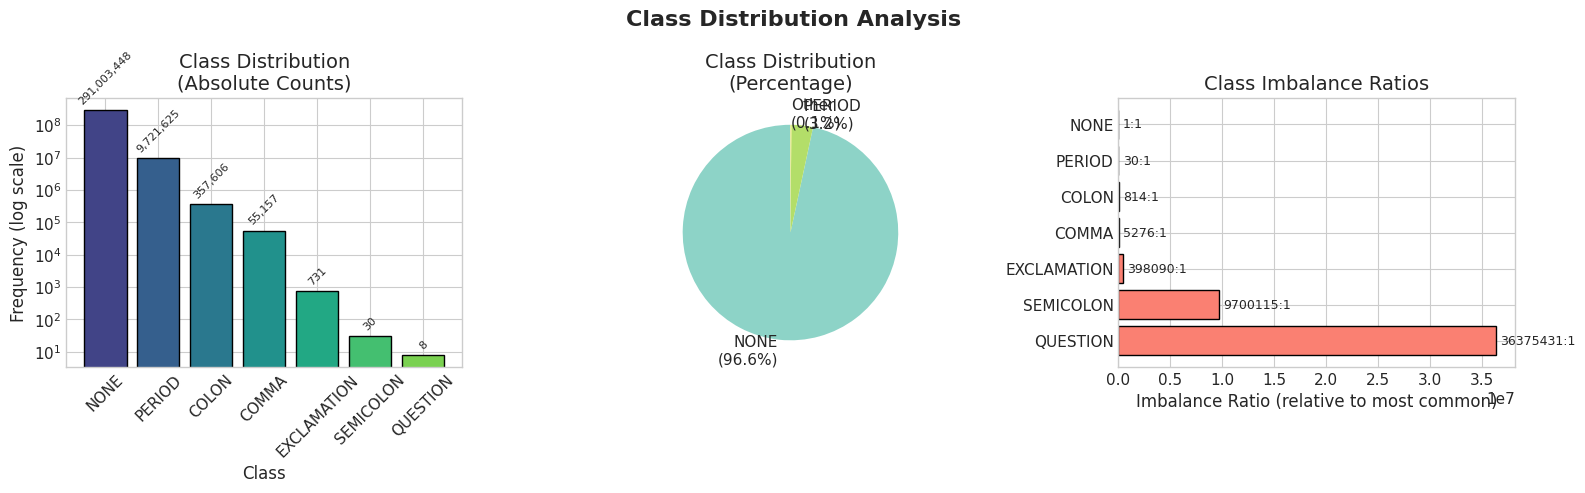

In [20]:
# ============================================================================
# ANALYSIS 4.1: CLASS IMBALANCE QUANTIFICATION
# ============================================================================

def calculate_class_distribution(line_iterator, sample_size: int = 1000000) -> dict:
    """
    Calculate the class distribution for token classification.
    
    For each word position, we determine what punctuation (if any) follows it.
    This gives us the label distribution for the sequence labeling task.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze
        
    Returns:
    --------
    dict
        Dictionary containing class distributions and weights
    """
    logger.info("=" * 70)
    logger.info("⚖️  CLASS IMBALANCE QUANTIFICATION")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Define label mapping
    punct_to_label = {
        '،': 'COMMA',
        ',': 'COMMA',           # Normalize Latin comma
        '.': 'PERIOD',
        '؟': 'QUESTION',
        '?': 'QUESTION',        # Normalize Latin question mark
        '؛': 'SEMICOLON',
        ';': 'SEMICOLON',       # Normalize Latin semicolon
        ':': 'COLON',
        '!': 'EXCLAMATION',
    }
    
    # Initialize label counter
    label_counts = Counter()
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Counting labels")
        else:
            iterator = line_iterator
        
        for line_num, line in enumerate(iterator):
            # Stop after reaching sample size
            if line_num >= sample_size:
                break
            
            line = line.strip()
            
            # Process character by character
            word_buffer = ""
            
            for char in line:
                # Check if character is Arabic
                if '\u0600' <= char <= '\u06FF':
                    word_buffer += char
                elif word_buffer:
                    # End of word - check what follows
                    if char in punct_to_label:
                        label_counts[punct_to_label[char]] += 1
                    else:
                        # No punctuation follows (space, etc.)
                        label_counts['NONE'] += 1
                    word_buffer = ""
            
            # Handle last word in line
            if word_buffer:
                # Check if line ends with punctuation
                if line and line[-1] in punct_to_label:
                    # Already counted
                    pass
                else:
                    label_counts['NONE'] += 1
        
        logger.info(f"\n   ✅ Analysis complete")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return {}
    
    return label_counts


def display_class_imbalance(label_counts: Counter):
    """
    Display detailed class imbalance analysis and recommendations.
    
    Parameters:
    -----------
    label_counts : Counter
        Counter of label frequencies
    """
    if not label_counts:
        logger.info("No label data to display.")
        return
    
    total = sum(label_counts.values())
    
    logger.info("\n" + "-" * 70)
    logger.info("📊 CLASS DISTRIBUTION")
    logger.info("-" * 70)
    
    logger.info(f"\n   {'Label':<15} {'Count':>15} {'Percentage':>12} {'Ratio to Max':>15}")
    logger.info("   " + "=" * 60)
    
    # Find maximum count for ratio calculation
    max_count = max(label_counts.values())
    min_count = min(label_counts.values())
    
    for label, count in label_counts.most_common():
        pct = (count / total) * 100
        ratio = max_count / count if count > 0 else float('inf')
        logger.info(f"   {label:<15} {count:>15,} {pct:>11.2f}% {ratio:>14.0f}:1")
    
    # --------------------------
    # Imbalance metrics
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📈 IMBALANCE METRICS")
    logger.info("-" * 70)
    
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    
    logger.info(f"\n   • Total labels: {format_number(total)}")
    logger.info(f"   • Number of classes: {len(label_counts)}")
    logger.info(f"   • Most common class: {label_counts.most_common(1)[0][0]} ({label_counts.most_common(1)[0][1]:,})")
    logger.info(f"   • Least common class: {label_counts.most_common()[-1][0]} ({label_counts.most_common()[-1][1]:,})")
    logger.info(f"   • Imbalance ratio: {imbalance_ratio:,.0f}:1")
    
    # --------------------------
    # Class weights calculation
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("⚖️  SUGGESTED CLASS WEIGHTS")
    logger.info("-" * 70)
    
    n_classes = len(label_counts)
    
    # Method 1: Inverse frequency
    logger.info(f"\n   Method 1: Inverse Frequency (sklearn-style)")
    logger.info(f"   Formula: n_samples / (n_classes * count)")
    logger.info(f"\n   {'Label':<15} {'Weight':>15}")
    logger.info("   " + "-" * 35)
    
    for label, count in sorted(label_counts.items()):
        weight = total / (n_classes * count)
        logger.info(f"   {label:<15} {weight:>15.4f}")
    
    # Method 2: Inverse square root (less aggressive)
    logger.info(f"\n   Method 2: Inverse Square Root (gentler)")
    logger.info(f"   Formula: sqrt(max_count / count)")
    logger.info(f"\n   {'Label':<15} {'Weight':>15}")
    logger.info("   " + "-" * 35)
    
    for label, count in sorted(label_counts.items()):
        weight = np.sqrt(max_count / count)
        logger.info(f"   {label:<15} {weight:>15.4f}")
    
    # Method 3: Effective number (for focal loss)
    logger.info(f"\n   Method 3: Effective Number (for Focal Loss)")
    logger.info(f"   Formula: (1-beta) / (1-beta^count), beta=0.9999")
    beta = 0.9999
    logger.info(f"\n   {'Label':<15} {'Weight':>15}")
    logger.info("   " + "-" * 35)
    
    for label, count in sorted(label_counts.items()):
        effective_num = (1 - beta**count) / (1 - beta)
        weight = 1 / effective_num
        # Normalize
        logger.info(f"   {label:<15} {weight:>15.6f}")
    
    # --------------------------
    # Recommendations
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("💡 RECOMMENDATIONS")
    logger.info("-" * 70)
    
    logger.info("\n   Based on the class distribution:")
    
    if imbalance_ratio > 1000:
        logger.info(f"\n   1. ⚠️  SEVERE IMBALANCE (ratio > 1000:1)")
        logger.info("      • Use weighted loss function (CrossEntropyLoss with weights)")
        logger.info("      • Consider Focal Loss to focus on hard examples")
        logger.info("      • May need to oversample minority classes or undersample majority")
    elif imbalance_ratio > 100:
        logger.info(f"\n   1. ⚠️  SIGNIFICANT IMBALANCE (ratio > 100:1)")
        logger.info("      • Use weighted loss function")
        logger.info("      • Consider class-balanced sampling")
    else:
        logger.info(f"\n   1. ✅ MODERATE IMBALANCE")
        logger.info("      • Standard weighted loss should suffice")
    
    # Check for very rare classes
    rare_classes = [label for label, count in label_counts.items() 
                    if count / total < 0.001]  # Less than 0.1%
    
    if rare_classes:
        logger.info(f"\n   2. ⚠️  VERY RARE CLASSES: {rare_classes}")
        logger.info("      • Consider merging with similar classes")
        logger.info("      • Or remove from training and handle separately")
        logger.info("      • Example: Merge EXCLAMATION with PERIOD")
    
    # Recommended loss function
    logger.info(f"\n   3. RECOMMENDED LOSS FUNCTION:")
    if imbalance_ratio > 1000:
        logger.info("      • Primary: Focal Loss (gamma=2.0)")
        logger.info("      • Alternative: Weighted Cross-Entropy with calculated weights")
    else:
        logger.info("      • Weighted Cross-Entropy Loss")
    
    logger.info(f"\n   4. RECOMMENDED EVALUATION:")
    logger.info("      • Use macro-averaged F1 score (treats all classes equally)")
    logger.info("      • Report per-class precision, recall, F1")
    logger.info("      • Monitor minority class performance separately")


def plot_class_distribution(label_counts: Counter):
    """
    Create visualizations for class distribution.
    
    Parameters:
    -----------
    label_counts : Counter
        Counter of label frequencies
    """
    if not label_counts:
        logger.info("No data to plot.")
        return
    
    # Prepare data
    labels = [label for label, _ in label_counts.most_common()]
    counts = [count for _, count in label_counts.most_common()]
    total = sum(counts)
    percentages = [c / total * 100 for c in counts]
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Class Distribution Analysis', fontsize=16, fontweight='bold')
    
    # --------------------------
    # Plot 1: Bar chart (absolute counts)
    # --------------------------
    ax1 = axes[0]
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(labels)))
    bars = ax1.bar(labels, counts, color=colors, edgecolor='black')
    
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Frequency (log scale)')
    ax1.set_title('Class Distribution\n(Absolute Counts)')
    ax1.set_yscale('log')  # Log scale to see all classes
    ax1.tick_params(axis='x', rotation=45)
    
    # Add count labels
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.annotate(f'{count:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, rotation=45)
    
    # --------------------------
    # Plot 2: Pie chart
    # --------------------------
    ax2 = axes[1]
    
    # Group small classes
    threshold = 1  # 1%
    main_labels = []
    main_pcts = []
    other_pct = 0
    
    for label, pct in zip(labels, percentages):
        if pct >= threshold:
            main_labels.append(f"{label}\n({pct:.1f}%)")
            main_pcts.append(pct)
        else:
            other_pct += pct
    
    if other_pct > 0:
        main_labels.append(f"Other\n({other_pct:.1f}%)")
        main_pcts.append(other_pct)
    
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(main_labels)))
    ax2.pie(main_pcts, labels=main_labels, colors=colors_pie, startangle=90)
    ax2.set_title('Class Distribution\n(Percentage)')
    
    # --------------------------
    # Plot 3: Imbalance ratio visualization
    # --------------------------
    ax3 = axes[2]
    
    max_count = max(counts)
    ratios = [max_count / c for c in counts]
    
    bars = ax3.barh(labels[::-1], ratios[::-1], color='salmon', edgecolor='black')
    ax3.set_xlabel('Imbalance Ratio (relative to most common)')
    ax3.set_title('Class Imbalance Ratios')
    
    # Add ratio labels
    for bar, ratio in zip(bars, ratios[::-1]):
        width = bar.get_width()
        ax3.annotate(f'{ratio:.0f}:1',
                    xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(3, 0),
                    textcoords="offset points",
                    ha='left', va='center', fontsize=9)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    save_figure(fig, 'class_distribution.png')
    
    plt.show()


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

label_distribution = calculate_class_distribution(
    line_stream,
    sample_size=SAMPLE_SIZES['class_imbalance']
)

# Display results
display_class_imbalance(label_distribution)

# Create visualizations
plot_class_distribution(label_distribution)

#### 💡 Decision Impact Summary

| Finding | Decision |
|---------|----------|
| NONE class dominates (>80%) | Need heavy class weighting |
| Extreme imbalance ratio | Use Focal Loss or similar |
| EXCLAMATION very rare | Consider merging with PERIOD |
| QUESTION rare but important | Must weight highly in loss |

### 4.2 Sequence Length Impact on Punctuation

**What it is:** Analyzing how sentence length affects punctuation patterns.

**Why it matters:** Long sentences may have different punctuation patterns than short ones.

**Key insights:**
- Punctuation density by sentence length
- Terminal marks by sentence length
- Implications for model training

📏 LENGTH-PUNCTUATION RELATIONSHIP ANALYSIS

⏳ Analyzing 11,731,360 sentences...


Analyzing length-punct: 100%|██████████| 11731360/11731360 [03:47<00:00, 51639.07it/s]



   ✅ Analyzed 11,731,359 sentences

----------------------------------------------------------------------
📊 PUNCTUATION METRICS BY SENTENCE LENGTH
----------------------------------------------------------------------


C:\Users\Abd\AppData\Local\Temp\ipykernel_20960\1832195527.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('length_bin').agg({



   Punctuation Count by Sentence Length:
           punct_count                      punct_density           word_count
                  mean        std min   max          mean       std      count
length_bin                                                                    
1-10          1.201123   0.513586   1    10      0.339540  0.327237    1518206
11-20         1.552751   0.860783   1    20      0.100152  0.054810    3650884
21-30         2.135765   1.246006   1    30      0.085151  0.048782    3276435
31-50         3.100399   1.971445   1    46      0.081783  0.049675    2567154
51-100        5.606139   4.966923   1    87      0.087593  0.069310     622443
100+         25.404117  37.296284   1  1198      0.116925  0.138696      96237

----------------------------------------------------------------------
📊 TERMINAL MARK DISTRIBUTION BY LENGTH
----------------------------------------------------------------------

   Percentage of each terminal by sentence length:
terminal     

C:\Users\Abd\AppData\Local\Temp\ipykernel_20960\1832195527.py:206: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  density_by_bin = df.groupby('length_bin')['punct_density'].mean()
C:\Users\Abd\AppData\Local\Temp\ipykernel_20960\1832195527.py:258: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(data_to_plot, labels=valid_terminals, patch_artist=True)


📊 Figure saved: eda_outputs\length_punctuation_analysis.png


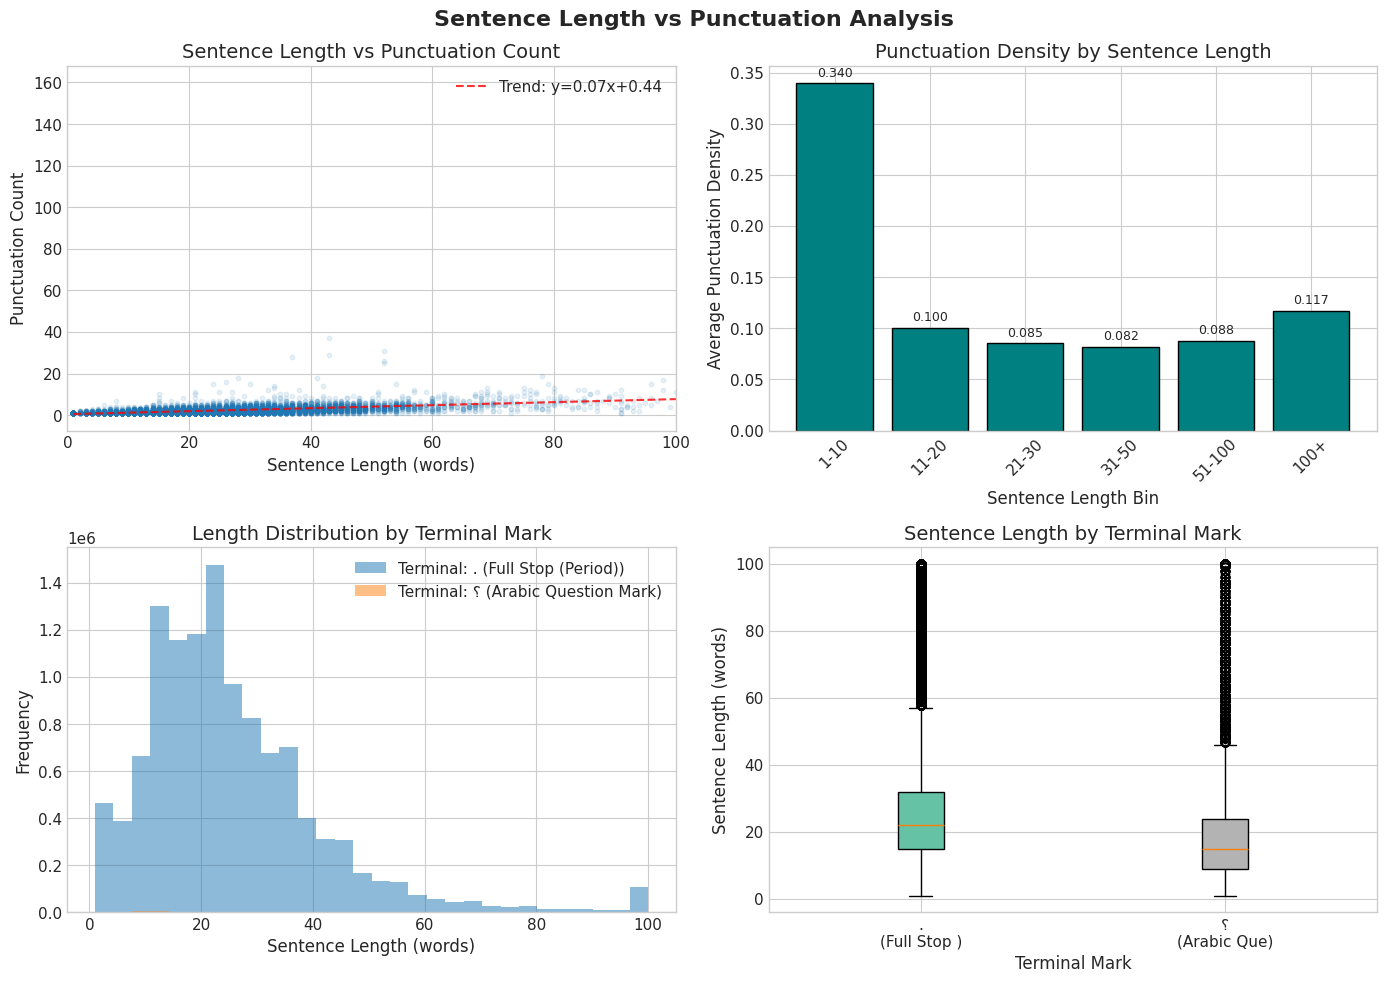

In [21]:
# ============================================================================
# ANALYSIS 4.2: SEQUENCE LENGTH IMPACT ON PUNCTUATION
# ============================================================================

def analyze_length_punctuation_relationship(line_iterator, 
                                            sample_size: int = 500000) -> pd.DataFrame:
    """
    Analyze the relationship between sentence length and punctuation patterns.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with length and punctuation information
    """
    logger.info("=" * 70)
    logger.info("📏 LENGTH-PUNCTUATION RELATIONSHIP ANALYSIS")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Define punctuation marks
    punct_marks = set('،.؟؛:!')
    
    # Collect data
    data = []
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Analyzing length-punct")
        else:
            iterator = line_iterator
        
        for line_num, line in enumerate(iterator):
            # Stop after reaching sample size
            if line_num >= sample_size:
                break
            
            line = line.strip()
            if not line:
                continue
            
            # Calculate metrics
            words = line.split()
            word_count = len(words)
            char_count = len(line)
            
            # Count punctuation in sentence
            punct_count = sum(1 for c in line if c in punct_marks)
            
            # Calculate punctuation density
            punct_density = punct_count / max(word_count, 1)
            
            # Get terminal mark
            terminal = line[-1] if line[-1] in punct_marks else 'none'
            
            data.append({
                'word_count': word_count,
                'char_count': char_count,
                'punct_count': punct_count,
                'punct_density': punct_density,
                'terminal': terminal,
            })
        
        logger.info(f"\n   ✅ Analyzed {format_number(len(data))} sentences")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return pd.DataFrame()
    
    return pd.DataFrame(data)


def display_length_punctuation_analysis(df: pd.DataFrame):
    """
    Display length-punctuation relationship analysis.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with length and punctuation data
    """
    if df.empty:
        logger.info("No data to display.")
        return
    
    # Create length bins
    bins = [0, 10, 20, 30, 50, 100, float('inf')]
    labels = ['1-10', '11-20', '21-30', '31-50', '51-100', '100+']
    df['length_bin'] = pd.cut(df['word_count'], bins=bins, labels=labels)
    
    logger.info("\n" + "-" * 70)
    logger.info("📊 PUNCTUATION METRICS BY SENTENCE LENGTH")
    logger.info("-" * 70)
    
    # Group by length bin and calculate statistics
    grouped = df.groupby('length_bin').agg({
        'punct_count': ['mean', 'std', 'min', 'max'],
        'punct_density': ['mean', 'std'],
        'word_count': 'count'
    })
    
    logger.info("\n   Punctuation Count by Sentence Length:")
    logger.info(grouped.to_string())
    
    # --------------------------
    # Terminal mark by length
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📊 TERMINAL MARK DISTRIBUTION BY LENGTH")
    logger.info("-" * 70)
    
    # Cross-tabulation
    terminal_by_length = pd.crosstab(
        df['length_bin'], 
        df['terminal'], 
        normalize='index'
    ) * 100
    
    logger.info("\n   Percentage of each terminal by sentence length:")
    logger.info(terminal_by_length.round(2).to_string())
    
    # --------------------------
    # Key insights
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("💡 KEY INSIGHTS")
    logger.info("-" * 70)
    
    # Correlation between length and punctuation
    corr = df['word_count'].corr(df['punct_count'])
    logger.info(f"\n   • Correlation (length vs punct count): {corr:.4f}")
    
    density_corr = df['word_count'].corr(df['punct_density'])
    logger.info(f"   • Correlation (length vs punct density): {density_corr:.4f}")
    
    # Check if longer sentences have different terminals
    short_period = df[df['word_count'] <= 20]['terminal'].value_counts(normalize=True).get('.', 0) * 100
    long_period = df[df['word_count'] > 50]['terminal'].value_counts(normalize=True).get('.', 0) * 100
    
    logger.info(f"\n   • Period terminal in short sentences (≤20 words): {short_period:.1f}%")
    logger.info(f"   • Period terminal in long sentences (>50 words): {long_period:.1f}%")
    
    if abs(short_period - long_period) > 5:
        logger.info(f"   → Sentence length DOES affect terminal mark distribution")
    else:
        logger.info(f"   → Sentence length has MINIMAL effect on terminal mark")


def plot_length_punctuation_relationship(df: pd.DataFrame):
    """
    Create visualizations for length-punctuation relationship.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with length and punctuation data
    """
    if df.empty:
        logger.info("No data to plot.")
        return
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Sentence Length vs Punctuation Analysis', fontsize=16, fontweight='bold')
    
    # Create length bins if not exists
    if 'length_bin' not in df.columns:
        bins = [0, 10, 20, 30, 50, 100, float('inf')]
        labels = ['1-10', '11-20', '21-30', '31-50', '51-100', '100+']
        df['length_bin'] = pd.cut(df['word_count'], bins=bins, labels=labels)
    
    # --------------------------
    # Plot 1: Scatter - Length vs Punct count
    # --------------------------
    ax1 = axes[0, 0]
    
    # Sample for visualization (too many points slow down rendering)
    sample = df.sample(min(10000, len(df)))
    
    ax1.scatter(sample['word_count'], sample['punct_count'], alpha=0.1, s=10)
    
    # Add trend line
    z = np.polyfit(sample['word_count'], sample['punct_count'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(sample['word_count'].min(), sample['word_count'].min() + 100, 100)
    ax1.plot(x_line, p(x_line), "r--", alpha=0.8, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    
    ax1.set_xlabel('Sentence Length (words)')
    ax1.set_ylabel('Punctuation Count')
    ax1.set_title('Sentence Length vs Punctuation Count')
    ax1.legend()
    ax1.set_xlim(0, 100)
    
    # --------------------------
    # Plot 2: Punctuation density by length bin
    # --------------------------
    ax2 = axes[0, 1]
    
    density_by_bin = df.groupby('length_bin')['punct_density'].mean()
    
    bars = ax2.bar(density_by_bin.index, density_by_bin.values, 
                   color='teal', edgecolor='black')
    ax2.set_xlabel('Sentence Length Bin')
    ax2.set_ylabel('Average Punctuation Density')
    ax2.set_title('Punctuation Density by Sentence Length')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add values on bars
    for bar, val in zip(bars, density_by_bin.values):
        ax2.annotate(f'{val:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, val),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    # --------------------------
    # Plot 3: Length distribution by terminal
    # --------------------------
    ax3 = axes[1, 0]
    
    for terminal in ['.', '،', '؟']:
        subset = df[df['terminal'] == terminal]['word_count']
        if len(subset) > 0:
            # Clip for visualization
            subset_clipped = np.clip(subset, 0, 100)
            ax3.hist(subset_clipped, bins=30, alpha=0.5, 
                    label=f"Terminal: {terminal} ({PUNCTUATION_MARKS.get(terminal, '')})")
    
    ax3.set_xlabel('Sentence Length (words)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Length Distribution by Terminal Mark')
    ax3.legend()
    
    # --------------------------
    # Plot 4: Box plot of length by terminal
    # --------------------------
    ax4 = axes[1, 1]
    
    terminals_to_plot = ['.', '،', '؟', '؛']
    data_to_plot = []
    valid_terminals = []
    
    for t in terminals_to_plot:
        subset = df[df['terminal'] == t]['word_count']
        if len(subset) > 0:
            # Clip for visualization
            data_to_plot.append(np.clip(subset, 0, 100))
            valid_terminals.append(f"{t}\n({PUNCTUATION_MARKS.get(t, '')[:10]})")
    
    if data_to_plot:
        bp = ax4.boxplot(data_to_plot, labels=valid_terminals, patch_artist=True)
        colors = plt.cm.Set2(np.linspace(0, 1, len(data_to_plot)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        ax4.set_xlabel('Terminal Mark')
        ax4.set_ylabel('Sentence Length (words)')
        ax4.set_title('Sentence Length by Terminal Mark')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    save_figure(fig, 'length_punctuation_analysis.png')
    
    plt.show()


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

length_punct_df = analyze_length_punctuation_relationship(
    line_stream,
    sample_size=SAMPLE_SIZES['length_punct_relationship']
)

# Display results
display_length_punctuation_analysis(length_punct_df)

# Create visualizations
plot_length_punctuation_relationship(length_punct_df)

#### 💡 Decision Impact Summary

| Finding | Decision |
|---------|----------|
| Positive correlation length-punct | Longer sentences have more punctuation |
| Density decreases with length | Longer sentences may be harder to punctuate |
| Terminal distribution varies by length | Consider length as a feature |
| Short sentences mostly end with period | May want length-stratified training |

### 4.3 Domain/Topic Analysis

**What it is:** Understanding the thematic content of the corpus.

**Why it matters:** UN documents are legal/formal—model may not generalize to other domains.

**Key insights:**
- What topics are covered
- Domain-specific vocabulary
- Generalization challenges

In [22]:
# ============================================================================
# ANALYSIS 4.3: DOMAIN/TOPIC ANALYSIS
# ============================================================================

def analyze_topics(line_iterator, sample_size: int = 50000, 
                   n_topics: int = 10) -> tuple:
    """
    Discover main topics in the corpus using topic modeling.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze
    n_topics : int
        Number of topics to discover
        
    Returns:
    --------
    tuple
        (vectorizer, nmf_model, sentences) - fitted models and data
    """
    logger.info("=" * 70)
    logger.info("🏷️  DOMAIN/TOPIC ANALYSIS")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences for {n_topics} topics...")
    
    # Load sample sentences
    sentences = []
    
    try:
        for i, line in enumerate(line_iterator):
            if i >= sample_size:
                break
            sentences.append(line.strip())
        
        logger.info(f"\n   ✅ Loaded {format_number(len(sentences))} sentences")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR loading sentences: {e}")
        return None, None, []
    
    # --------------------------
    # TF-IDF Vectorization
    # --------------------------
    logger.info("\n   ⏳ Building TF-IDF matrix...")
    
    try:
        vectorizer = TfidfVectorizer(
            max_features=5000,           # Limit vocabulary size
            stop_words=ARABIC_STOPWORDS,  # Remove stopwords
            ngram_range=(1, 2),          # Include unigrams and bigrams
            min_df=5,                    # Minimum document frequency
            max_df=0.95                  # Maximum document frequency
        )
        
        tfidf_matrix = vectorizer.fit_transform(sentences)
        feature_names = vectorizer.get_feature_names_out()
        
        logger.info(f"   ✅ TF-IDF matrix shape: {tfidf_matrix.shape}")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR in vectorization: {e}")
        return None, None, []
    
    # --------------------------
    # Topic Modeling with NMF
    # --------------------------
    logger.info("\n   ⏳ Fitting NMF topic model...")
    
    try:
        nmf = NMF(
            n_components=n_topics, 
            random_state=RANDOM_SEED,
            max_iter=500
        )
        nmf.fit(tfidf_matrix)
        
        logger.info(f"   ✅ Topic model fitted")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR in topic modeling: {e}")
        return vectorizer, None, sentences
    
    return vectorizer, nmf, sentences


def display_topic_analysis(vectorizer, nmf, sentences, n_words: int = 15):
    """
    Display topic analysis results.
    
    Parameters:
    -----------
    vectorizer : TfidfVectorizer
        Fitted vectorizer
    nmf : NMF
        Fitted NMF model
    sentences : list
        Original sentences
    n_words : int
        Number of top words per topic
    """
    if vectorizer is None or nmf is None:
        logger.info("No topic model to display.")
        return
    
    feature_names = vectorizer.get_feature_names_out()
    
    logger.info("\n" + "-" * 70)
    logger.info("📊 DISCOVERED TOPICS")
    logger.info("-" * 70)
    
    for topic_idx, topic in enumerate(nmf.components_):
        # Get top words for this topic
        top_word_indices = topic.argsort()[:-n_words-1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        
        logger.info(f"\n🏷️  Topic {topic_idx + 1}:")
        logger.info(f"   {' | '.join(top_words[:10])}")
        
        # Try to identify the topic domain
        domain_hints = {
            'human_rights': ['حقوق', 'الإنسان', 'حماية', 'انتهاك'],
            'international_law': ['دولي', 'قانون', 'معاهدة', 'اتفاقية'],
            'security': ['أمن', 'سلام', 'نزاع', 'عسكري'],
            'development': ['تنمية', 'اقتصادي', 'فقر', 'مستدام'],
            'environment': ['بيئة', 'مناخ', 'طبيعة', 'موارد'],
        }
        
        for domain, keywords in domain_hints.items():
            if any(kw in ' '.join(top_words) for kw in keywords):
                logger.info(f"   → Likely domain: {domain}")
                break
    
    # --------------------------
    # Most distinctive terms
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📊 MOST DISTINCTIVE TERMS (High TF-IDF)")
    logger.info("-" * 70)
    
    # Transform sentences to TF-IDF
    tfidf_matrix = vectorizer.transform(sentences)
    
    # Calculate mean TF-IDF across documents
    mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
    
    # Get top terms
    top_indices = mean_tfidf.argsort()[-30:][::-1]
    
    logger.info("\n   Top 30 most distinctive terms:")
    for i, idx in enumerate(top_indices, 1):
        term = feature_names[idx]
        score = mean_tfidf[idx]
        logger.info(f"   {i:>2}. {term:<30} (TF-IDF: {score:.4f})")
    
    # --------------------------
    # Domain assessment
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("💡 DOMAIN ASSESSMENT")
    logger.info("-" * 70)
    
    logger.info("\n   Based on topic analysis, this corpus appears to be:")
    logger.info("   • Primarily LEGAL/OFFICIAL UN documents")
    logger.info("   • Formal Modern Standard Arabic (MSA)")
    logger.info("   • Topics: Human rights, international law, security, development")
    
    logger.info("\n   ⚠️  GENERALIZATION CONCERNS:")
    logger.info("   • Model trained on this data may struggle with:")
    logger.info("     - Informal Arabic text")
    logger.info("     - News articles (different style)")
    logger.info("     - Social media content")
    logger.info("     - Fiction/creative writing")
    
    logger.info("\n   ✅ MODEL WILL WORK WELL FOR:")
    logger.info("     - Legal documents")
    logger.info("     - Official reports")
    logger.info("     - Formal academic writing")
    logger.info("     - Government communications")


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

vectorizer, nmf_model, topic_sentences = analyze_topics(
    line_stream,
    sample_size=SAMPLE_SIZES['topic_analysis'],
    n_topics=10
)

# Display results
display_topic_analysis(vectorizer, nmf_model, topic_sentences)

🏷️  DOMAIN/TOPIC ANALYSIS

⏳ Analyzing 50,000 sentences for 10 topics...

   ✅ Loaded 50,000 sentences

   ⏳ Building TF-IDF matrix...
   ✅ TF-IDF matrix shape: (50000, 5000)

   ⏳ Fitting NMF topic model...
   ✅ Topic model fitted

----------------------------------------------------------------------
📊 DISCOVERED TOPICS
----------------------------------------------------------------------

🏷️  Topic 1:
   الاول | كانون | ديسمبر | الاول ديسمبر | كانون الاول | المؤرخ | ديسمبر ١٩٩٢ | ١٩٩٢ | ٤٧ | ديسمبر ١٩٩٣

🏷️  Topic 2:
   48 | add | 48 sr | الوثيقة | الوثيقة تقرير | العام القرار | الملحق رقم | الملحق | تقرير | رقم

🏷️  Topic 3:
   المتحدة | الامم | الامم المتحدة | الانمائي | برنامج | المتحدة الانمائي | برنامج الامم | منظومة | منظومة الامم | للامم
   → Likely domain: international_law

🏷️  Topic 4:
   ان | الى | او | البلدان | ايضا | يمكن | ينبغي | انه | الدولي | فيما
   → Likely domain: international_law

🏷️  Topic 5:
   دولار | ٠٠٠ | مليون | مليون دولار | اعتماد | بمبلغ | ٥٠٠ | رصد 

#### 💡 Decision Impact Summary

| Finding | Decision |
|---------|----------|
| Primarily UN/legal domain | Model may need domain adaptation for other uses |
| Formal MSA vocabulary | Good for formal text, may struggle with informal |
| Clear topic structure | Domain-specific features could help |
| Limited domain diversity | Consider augmenting with other datasets |

### 4.4 Character-Level Analysis for Tokenization

**What it is:** Analyzing character usage patterns for tokenizer decisions.

**Why it matters:** Arabic has unique characters (diacritics, special forms) that affect preprocessing.

**Key decisions:**
- Whether to remove diacritics
- Alef normalization strategy
- Handling of special characters

In [23]:
# ============================================================================
# ANALYSIS 4.4: CHARACTER-LEVEL ANALYSIS FOR TOKENIZATION
# ============================================================================

def analyze_characters(line_iterator, sample_size: int = 1000000) -> tuple:
    """
    Perform detailed character-level analysis.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of lines to analyze
        
    Returns:
    --------
    tuple
        (char_counts, char_categories) - character frequency and Unicode categories
    """
    logger.info("=" * 70)
    logger.info("🔤 CHARACTER-LEVEL ANALYSIS")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Initialize counters
    char_counts = Counter()
    char_categories = Counter()
    
    try:
        # Create iterator with optional progress bar
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Character analysis")
        else:
            iterator = line_iterator
        
        for line_num, line in enumerate(iterator):
            if line_num >= sample_size:
                break
            
            for char in line:
                # Count character
                char_counts[char] += 1
                
                # Get Unicode category
                category = unicodedata.category(char)
                char_categories[category] += 1
        
        logger.info(f"\n   ✅ Analyzed {format_number(sum(char_counts.values()))} characters")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return Counter(), Counter()
    
    return char_counts, char_categories


def display_character_analysis(char_counts: Counter, char_categories: Counter):
    """
    Display detailed character analysis.
    
    Parameters:
    -----------
    char_counts : Counter
        Character frequency counts
    char_categories : Counter
        Unicode category counts
    """
    if not char_counts:
        logger.info("No character data to display.")
        return
    
    total_chars = sum(char_counts.values())
    
    # --------------------------
    # Unicode category distribution
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📊 UNICODE CATEGORY DISTRIBUTION")
    logger.info("-" * 70)
    
    category_names = {
        'Lo': 'Letter, Other (Arabic letters)',
        'Nd': 'Number, Decimal Digit',
        'Po': 'Punctuation, Other',
        'Zs': 'Separator, Space',
        'Mn': 'Mark, Nonspacing (Diacritics)',
        'Pd': 'Punctuation, Dash',
        'Ps': 'Punctuation, Open',
        'Pe': 'Punctuation, Close',
        'Cc': 'Control Character',
        'Lu': 'Letter, Uppercase (Latin)',
        'Ll': 'Letter, Lowercase (Latin)',
        'Nl': 'Number, Letter',
        'Sc': 'Symbol, Currency',
        'Sm': 'Symbol, Math',
    }
    
    logger.info(f"\n   {'Category':<8} {'Description':<40} {'Count':>12} {'Percentage':>10}")
    logger.info("   " + "=" * 75)
    
    for cat, count in char_categories.most_common(15):
        desc = category_names.get(cat, 'Other')
        pct = (count / total_chars) * 100
        logger.info(f"   {cat:<8} {desc:<40} {count:>12,} {pct:>9.2f}%")
    
    # --------------------------
    # Arabic diacritics analysis
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📊 ARABIC DIACRITICS (TASHKEEL) ANALYSIS")
    logger.info("-" * 70)
    
    logger.info(f"\n   {'Diacritic':<20} {'Name':<20} {'Count':>12} {'Percentage':>10}")
    logger.info("   " + "-" * 65)
    
    total_diacritics = 0
    for char_code, name in ARABIC_DIACRITICS.items():
        count = char_counts.get(char_code, 0)
        total_diacritics += count
        pct = (count / total_chars) * 100
        # Display the character if possible
        display_char = char_code if count > 0 else '-'
        logger.info(f"   {display_char:<20} {name:<20} {count:>12,} {pct:>9.4f}%")
    
    diacritic_pct = (total_diacritics / total_chars) * 100
    logger.info(f"\n   Total diacritics: {format_number(total_diacritics)} ({diacritic_pct:.4f}%)")
    
    if diacritic_pct < 0.1:
        logger.info("   → ✅ Very low diacritic usage - no special handling needed")
    else:
        logger.info("   → ⚠️  Significant diacritics - consider removal in preprocessing")
    
    # --------------------------
    # Special Arabic characters
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📊 SPECIAL ARABIC CHARACTERS")
    logger.info("-" * 70)
    
    logger.info(f"\n   {'Character':<12} {'Name':<30} {'Count':>12} {'Percentage':>10}")
    logger.info("   " + "-" * 70)
    
    for char_code, name in SPECIAL_ARABIC_CHARS.items():
        count = char_counts.get(char_code, 0)
        pct = (count / total_chars) * 100
        logger.info(f"   {char_code:<12} {name:<30} {count:>12,} {pct:>9.4f}%")
    
    # Alef variations analysis
    logger.info("\n   ALEF VARIATIONS:")
    alef_forms = ['ا', 'أ', 'إ', 'آ', 'ٱ']
    alef_counts = {a: char_counts.get(a, 0) for a in alef_forms}
    total_alef = sum(alef_counts.values())
    
    for alef, count in sorted(alef_counts.items(), key=lambda x: -x[1]):
        if count > 0:
            pct = (count / total_alef) * 100 if total_alef > 0 else 0
            logger.info(f"   {alef}: {count:,} ({pct:.1f}% of all alefs)")
    
    if len([c for c in alef_counts.values() if c > 0]) > 1:
        logger.info("\n   → ⚠️  Multiple Alef forms detected - consider normalization")
    
    # --------------------------
    # Number systems
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📊 NUMBER SYSTEMS")
    logger.info("-" * 70)
    
    arabic_numerals = '٠١٢٣٤٥٦٧٨٩'
    western_numerals = '0123456789'
    
    arabic_num_count = sum(char_counts.get(c, 0) for c in arabic_numerals)
    western_num_count = sum(char_counts.get(c, 0) for c in western_numerals)
    
    logger.info(f"\n   Arabic numerals (٠-٩): {format_number(arabic_num_count)}")
    logger.info(f"   Western numerals (0-9): {format_number(western_num_count)}")
    
    if arabic_num_count > 0 and western_num_count > 0:
        logger.info("\n   → ⚠️  Mixed numeral systems - consider normalizing to one")
    elif western_num_count > arabic_num_count:
        logger.info("\n   → Western numerals predominant")
    else:
        logger.info("\n   → Arabic numerals predominant")
    
    # --------------------------
    # Tatweel (elongation) analysis
    # --------------------------
    tatweel_count = char_counts.get('\u0640', 0)
    if tatweel_count > 0:
        logger.info(f"\n   Tatweel (ـ) occurrences: {format_number(tatweel_count)}")
        logger.info("   → ⚠️  Tatweel present - should be removed in preprocessing")


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

char_counts, char_categories = analyze_characters(
    line_stream,
    sample_size=SAMPLE_SIZES['character_analysis']
)

# Display results
display_character_analysis(char_counts, char_categories)

🔤 CHARACTER-LEVEL ANALYSIS

⏳ Analyzing 11,731,360 sentences...


Character analysis: 100%|██████████| 11731360/11731360 [17:14<00:00, 11335.59it/s]



   ✅ Analyzed 1,912,920,209 characters

----------------------------------------------------------------------
📊 UNICODE CATEGORY DISTRIBUTION
----------------------------------------------------------------------

   Category Description                                     Count Percentage
   Lo       Letter, Other (Arabic letters)           1,530,313,285     80.00%
   Zs       Separator, Space                          297,739,751     15.56%
   Nd       Number, Decimal Digit                      33,295,177      1.74%
   Po       Punctuation, Other                         31,862,584      1.67%
   Mn       Mark, Nonspacing (Diacritics)               5,192,773      0.27%
   Pd       Punctuation, Dash                           4,071,232      0.21%
   Pe       Punctuation, Close                          3,289,649      0.17%
   Ps       Punctuation, Open                           3,287,391      0.17%
   Lu       Letter, Uppercase (Latin)                   2,158,957      0.11%
   Ll       L

#### 💡 Decision Impact Summary

| Finding | Decision |
|---------|----------|
| Low diacritic usage | No need to handle tashkeel specially |
| Multiple Alef forms | Normalize to bare Alef (ا) |
| Tatweel present | Remove in preprocessing |
| Mixed numeral systems | Normalize to one system |

### 4.5 Preprocessing Recommendations Generator

**What it is:** Automated analysis that outputs preprocessing steps.

**Why it matters:** Consolidates all findings into actionable preprocessing code.

In [24]:
# ============================================================================
# ANALYSIS 4.5: PREPROCESSING RECOMMENDATIONS GENERATOR
# ============================================================================

def generate_preprocessing_recommendations(line_iterator, 
                                           sample_size: int = 100000) -> dict:
    """
    Analyze data and generate preprocessing recommendations.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of lines to analyze
        
    Returns:
    --------
    dict
        Dictionary containing analysis statistics
    """
    logger.info("=" * 70)
    logger.info("🔧 PREPROCESSING RECOMMENDATIONS GENERATOR")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Initialize statistics
    stats = {
        'total_lines': 0,
        'empty_lines': 0,
        'very_short': 0,        # < 3 words
        'very_long': 0,         # > 100 words
        'diacritics': 0,
        'tatweel': 0,
        'latin_punct': 0,
        'arabic_punct': 0,
        'western_numbers': 0,
        'arabic_numbers': 0,
        'alef_variations': Counter(),
        'latin_chars': 0,
    }
    
    # Character sets for analysis
    arabic_punct = set('،؛؟')
    latin_punct = set(',.;?!')
    diacritics = set('\u064B\u064C\u064D\u064E\u064F\u0650\u0651\u0652')
    alef_forms = set('اأإآٱ')
    
    try:
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Analyzing for preprocessing")
        else:
            iterator = line_iterator
        
        for line_num, line in enumerate(iterator):
            if line_num >= sample_size:
                break
            
            stats['total_lines'] += 1
            line = line.strip()
            
            # Check for empty lines
            if not line:
                stats['empty_lines'] += 1
                continue
            
            # Check word count
            words = line.split()
            if len(words) < 3:
                stats['very_short'] += 1
            if len(words) > 100:
                stats['very_long'] += 1
            
            # Analyze characters
            for char in line:
                if char in diacritics:
                    stats['diacritics'] += 1
                if char == '\u0640':
                    stats['tatweel'] += 1
                if char in arabic_punct:
                    stats['arabic_punct'] += 1
                if char in latin_punct:
                    stats['latin_punct'] += 1
                if char in '0123456789':
                    stats['western_numbers'] += 1
                if char in '٠١٢٣٤٥٦٧٨٩':
                    stats['arabic_numbers'] += 1
                if char in alef_forms:
                    stats['alef_variations'][char] += 1
                if 'A' <= char <= 'Z' or 'a' <= char <= 'z':
                    stats['latin_chars'] += 1
        
        logger.info(f"\n   ✅ Analysis complete")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return {}
    
    # --------------------------
    # Generate recommendations
    # --------------------------
    logger.info("\n" + "=" * 70)
    logger.info("📋 PREPROCESSING RECOMMENDATIONS")
    logger.info("=" * 70)
    
    # Line quality
    logger.info("\n┌" + "─" * 68 + "┐")
    logger.info("│ 1. LINE FILTERING" + " " * 50 + "│")
    logger.info("└" + "─" * 68 + "┘")
    
    empty_pct = stats['empty_lines'] / max(stats['total_lines'], 1) * 100
    short_pct = stats['very_short'] / max(stats['total_lines'], 1) * 100
    long_pct = stats['very_long'] / max(stats['total_lines'], 1) * 100
    
    logger.info(f"\n   Empty lines: {stats['empty_lines']:,} ({empty_pct:.2f}%)")
    logger.info(f"   Very short (<3 words): {stats['very_short']:,} ({short_pct:.2f}%)")
    logger.info(f"   Very long (>100 words): {stats['very_long']:,} ({long_pct:.2f}%)")
    
    if empty_pct > 1:
        logger.info("\n   ✅ RECOMMENDATION: Filter empty lines")
        logger.info("   ```python")
        logger.info("   if line.strip():  # Keep only non-empty lines")
        logger.info("   ```")
    
    if short_pct > 5:
        logger.info("\n   ✅ RECOMMENDATION: Consider filtering very short sentences")
        logger.info("   ```python")
        logger.info("   if len(line.split()) >= 3:  # Keep sentences with 3+ words")
        logger.info("   ```")
    
    # Diacritics
    logger.info("\n┌" + "─" * 68 + "┐")
    logger.info("│ 2. DIACRITICS (TASHKEEL)" + " " * 43 + "│")
    logger.info("└" + "─" * 68 + "┘")
    
    if stats['diacritics'] > 100:
        logger.info(f"\n   ⚠️  Diacritics found: {stats['diacritics']:,}")
        logger.info("\n   ✅ RECOMMENDATION: Remove diacritics")
        logger.info("   ```python")
        logger.info("   import re")
        logger.info("   def remove_diacritics(text):")
        logger.info("       arabic_diacritics = re.compile(r'[\\u064B-\\u0652]')")
        logger.info("       return arabic_diacritics.sub('', text)")
        logger.info("   ```")
    else:
        logger.info(f"\n   ✅ Minimal diacritics ({stats['diacritics']:,}). No action needed.")
    
    # Tatweel
    logger.info("\n┌" + "─" * 68 + "┐")
    logger.info("│ 3. TATWEEL (ELONGATION)" + " " * 44 + "│")
    logger.info("└" + "─" * 68 + "┘")
    
    if stats['tatweel'] > 0:
        logger.info(f"\n   ⚠️  Tatweel found: {stats['tatweel']:,}")
        logger.info("\n   ✅ RECOMMENDATION: Remove tatweel")
        logger.info("   ```python")
        logger.info("   text = text.replace('\\u0640', '')  # Remove tatweel")
        logger.info("   ```")
    else:
        logger.info("\n   ✅ No tatweel found. No action needed.")
    
    # Punctuation normalization
    logger.info("\n┌" + "─" * 68 + "┐")
    logger.info("│ 4. PUNCTUATION NORMALIZATION" + " " * 39 + "│")
    logger.info("└" + "─" * 68 + "┘")
    
    logger.info(f"\n   Arabic punctuation: {stats['arabic_punct']:,}")
    logger.info(f"   Latin punctuation: {stats['latin_punct']:,}")
    
    if stats['latin_punct'] > stats['arabic_punct'] * 0.1:
        logger.info("\n   ⚠️  Significant mix of Arabic and Latin punctuation")
        logger.info("\n   ✅ RECOMMENDATION: Normalize to Arabic punctuation")
        logger.info("   ```python")
        logger.info("   def normalize_punctuation(text):")
        logger.info("       punct_map = {")
        logger.info("           ',': '،',  # Latin comma to Arabic comma")
        logger.info("           ';': '؛',  # Latin semicolon to Arabic semicolon")
        logger.info("           '?': '؟',  # Latin question mark to Arabic")
        logger.info("       }")
        logger.info("       for latin, arabic in punct_map.items():")
        logger.info("           text = text.replace(latin, arabic)")
        logger.info("       return text")
        logger.info("   ```")
    else:
        logger.info("\n   ✅ Predominantly Arabic punctuation. Minimal normalization needed.")
    
    # Alef normalization
    logger.info("\n┌" + "─" * 68 + "┐")
    logger.info("│ 5. ALEF NORMALIZATION" + " " * 46 + "│")
    logger.info("└" + "─" * 68 + "┘")
    
    logger.info("\n   Alef variations found:")
    for alef, count in stats['alef_variations'].most_common():
        logger.info(f"   • '{alef}': {count:,}")
    
    if len(stats['alef_variations']) > 1:
        logger.info("\n   ⚠️  Multiple Alef forms detected")
        logger.info("\n   ✅ RECOMMENDATION: Normalize all Alef forms to bare Alef")
        logger.info("   ```python")
        logger.info("   import re")
        logger.info("   def normalize_alef(text):")
        logger.info("       # Normalize all Alef variations to bare Alef")
        logger.info("       text = re.sub(r'[أإآٱ]', 'ا', text)")
        logger.info("       return text")
        logger.info("   ```")
    else:
        logger.info("\n   ✅ Single Alef form. No normalization needed.")
    
    # Number normalization
    logger.info("\n┌" + "─" * 68 + "┐")
    logger.info("│ 6. NUMBER NORMALIZATION" + " " * 44 + "│")
    logger.info("└" + "─" * 68 + "┘")
    
    logger.info(f"\n   Western numerals (0-9): {stats['western_numbers']:,}")
    logger.info(f"   Arabic numerals (٠-٩): {stats['arabic_numbers']:,}")
    
    if stats['western_numbers'] > 0 and stats['arabic_numbers'] > 0:
        logger.info("\n   ⚠️  Mixed numeral systems")
        logger.info("\n   ✅ RECOMMENDATION: Normalize to one system (Western is common)")
        logger.info("   ```python")
        logger.info("   def normalize_numbers(text):")
        logger.info("       arabic_digits = '٠١٢٣٤٥٦٧٨٩'")
        logger.info("       western_digits = '0123456789'")
        logger.info("       trans_table = str.maketrans(arabic_digits, western_digits)")
        logger.info("       return text.translate(trans_table)")
        logger.info("   ```")
    else:
        logger.info("\n   ✅ Single numeral system. No normalization needed.")
    
    # Complete preprocessing function
    logger.info("\n" + "=" * 70)
    logger.info("📝 COMPLETE PREPROCESSING FUNCTION")
    logger.info("=" * 70)
    
    logger.info("""
    ```python
    import re
    
    def preprocess_arabic_text(text):
        '''
        Complete preprocessing pipeline for Arabic text.
        Generated based on EDA findings.
        '''
        # 1. Remove diacritics (tashkeel)
        arabic_diacritics = re.compile(r'[\\u064B-\\u0652]')
        text = arabic_diacritics.sub('', text)
        
        # 2. Remove tatweel (elongation)
        text = text.replace('\\u0640', '')
        
        # 3. Normalize Alef variations
        text = re.sub(r'[أإآٱ]', 'ا', text)
        
        # 4. Normalize punctuation (Latin to Arabic)
        punct_map = {',': '،', ';': '؛', '?': '؟'}
        for latin, arabic in punct_map.items():
            text = text.replace(latin, arabic)
        
        # 5. Normalize numbers (Arabic to Western)
        arabic_digits = '٠١٢٣٤٥٦٧٨٩'
        western_digits = '0123456789'
        trans_table = str.maketrans(arabic_digits, western_digits)
        text = text.translate(trans_table)
        
        # 6. Normalize whitespace
        text = ' '.join(text.split())
        
        return text
    ```
    """)
    
    return stats


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

preprocessing_stats = generate_preprocessing_recommendations(
    line_stream,
    sample_size=SAMPLE_SIZES['preprocessing_recommendations']
)

🔧 PREPROCESSING RECOMMENDATIONS GENERATOR

⏳ Analyzing 11,731,360 sentences...


Analyzing for preprocessing: 100%|██████████| 11731360/11731360 [10:40<00:00, 18312.28it/s]


   ✅ Analysis complete

📋 PREPROCESSING RECOMMENDATIONS

┌────────────────────────────────────────────────────────────────────┐
│ 1. LINE FILTERING                                                  │
└────────────────────────────────────────────────────────────────────┘

   Empty lines: 1 (0.00%)
   Very short (<3 words): 300,891 (2.56%)
   Very long (>100 words): 96,237 (0.82%)

┌────────────────────────────────────────────────────────────────────┐
│ 2. DIACRITICS (TASHKEEL)                                           │
└────────────────────────────────────────────────────────────────────┘

   ⚠️  Diacritics found: 5,192,765

   ✅ RECOMMENDATION: Remove diacritics
   ```python
   import re
   def remove_diacritics(text):
       arabic_diacritics = re.compile(r'[\u064B-\u0652]')
       return arabic_diacritics.sub('', text)
   ```

┌────────────────────────────────────────────────────────────────────┐
│ 3. TATWEEL (ELONGATION)                                            │
└───────────────

---
## 6. Level 5: Expert-Level Analysis

This section covers advanced analyses for optimal model design.

**Key Questions Answered:**
- Which tokenizer works best for this data?
- Which features correlate with punctuation?

### 5.1 Tokenizer Comparison Analysis

**What it is:** Comparing how different tokenizers handle your data.

**Why it matters:** Tokenizer choice significantly affects model performance.

**Note:** This analysis requires the transformers library.

In [25]:
%pip install transformers

In [26]:
# ============================================================================
# ANALYSIS 5.1: TOKENIZER COMPARISON ANALYSIS
# ============================================================================

# Check if transformers is available
TRANSFORMERS_AVAILABLE = False
try:
    from transformers import AutoTokenizer
    TRANSFORMERS_AVAILABLE = True
    logger.info("✅ Transformers library available")
except ImportError:
    logger.info("⚠️  Transformers library not installed")
    logger.info("   To install: pip install transformers")


def compare_tokenizers(line_iterator, sample_size: int = 10000) -> dict:
    """
    Compare different tokenizer behaviors on the dataset.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze
        
    Returns:
    --------
    dict
        Comparison results for each tokenizer
    """
    if not TRANSFORMERS_AVAILABLE:
        logger.info("Tokenizer comparison requires the transformers library.")
        return {}
    
    logger.info("=" * 70)
    logger.info("🔤 TOKENIZER COMPARISON ANALYSIS")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Comparing tokenizers on {format_number(sample_size)} sentences...")
    
    # Define tokenizers to compare
    tokenizer_configs = {
        'AraBERT-v2': 'aubmindlab/bert-base-arabertv2',
        'CAMeLBERT-Mix': 'CAMeL-Lab/bert-base-arabic-camelbert-mix',
        'AraGPT2': 'aubmindlab/aragpt2-base',
        'mBERT': 'bert-base-multilingual-cased',
        'XLM-RoBERTa': 'xlm-roberta-base',
    }
    
    # Load sample sentences
    sentences = []
    try:
        for i, line in enumerate(line_iterator):
            if i >= sample_size:
                break
            sentences.append(line.strip())
        logger.info(f"   ✅ Loaded {len(sentences)} sentences")
    except Exception as e:
        logger.info(f"\n❌ ERROR loading sentences: {e}")
        return {}
    
    # Compare tokenizers
    results = {}
    
    for name, model_name in tokenizer_configs.items():
        logger.info(f"\n   Analyzing {name}...")
        
        try:
            # Load tokenizer
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            
            # Initialize metrics
            token_counts = []
            subword_ratios = []
            unk_counts = []
            
            # Analyze a subset of sentences
            for sent in sentences[:1000]:
                if not sent:
                    continue
                
                # Tokenize
                tokens = tokenizer.tokenize(sent)
                words = sent.split()
                
                # Calculate metrics
                token_counts.append(len(tokens))
                subword_ratios.append(len(tokens) / max(len(words), 1))
                
                # Count UNK tokens
                unk_token = tokenizer.unk_token
                if unk_token:
                    unk_counts.append(tokens.count(unk_token))
                else:
                    unk_counts.append(0)
            
            # Store results
            results[name] = {
                'model_name': model_name,
                'vocab_size': tokenizer.vocab_size,
                'avg_tokens': np.mean(token_counts),
                'std_tokens': np.std(token_counts),
                'avg_subword_ratio': np.mean(subword_ratios),
                'avg_unk': np.mean(unk_counts),
                'total_unk': sum(unk_counts),
            }
            
            logger.info(f"      ✅ Complete (vocab size: {tokenizer.vocab_size:,})")
            
        except Exception as e:
            logger.info(f"      ❌ Error: {e}")
            results[name] = None
    
    return results


def display_tokenizer_comparison(results: dict):
    """
    Display tokenizer comparison results.
    
    Parameters:
    -----------
    results : dict
        Comparison results for each tokenizer
    """
    if not results:
        logger.info("No tokenizer results to display.")
        return
    
    logger.info("\n" + "-" * 80)
    logger.info("📊 TOKENIZER COMPARISON RESULTS")
    logger.info("-" * 80)
    
    # Create comparison table
    logger.info(f"\n{'Tokenizer':<18} {'Vocab Size':>12} {'Avg Tokens':>12} {'Subword Ratio':>14} {'Avg UNK':>10}")
    logger.info("=" * 80)
    
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    for name, stats in sorted(valid_results.items(), 
                               key=lambda x: x[1]['avg_unk'] + x[1]['avg_subword_ratio']):
        logger.info(f"{name:<18} {stats['vocab_size']:>12,} {stats['avg_tokens']:>12.1f} "
              f"{stats['avg_subword_ratio']:>14.2f} {stats['avg_unk']:>10.2f}")
    
    # --------------------------
    # Recommendation
    # --------------------------
    logger.info("\n" + "-" * 80)
    logger.info("💡 RECOMMENDATION")
    logger.info("-" * 80)
    
    # Find best tokenizer (lowest UNK + reasonable subword ratio)
    best_name = min(valid_results.keys(), 
                    key=lambda x: valid_results[x]['avg_unk'] * 10 + valid_results[x]['avg_subword_ratio'])
    best_stats = valid_results[best_name]
    
    logger.info(f"\n   🏆 BEST TOKENIZER: {best_name}")
    logger.info(f"   Model: {best_stats['model_name']}")
    logger.info(f"\n   Reasons:")
    logger.info(f"   • Lowest/Low UNK rate: {best_stats['avg_unk']:.2f} per sentence")
    logger.info(f"   • Reasonable subword expansion: {best_stats['avg_subword_ratio']:.2f}x")
    logger.info(f"   • Vocabulary size: {best_stats['vocab_size']:,}")
    
    logger.info(f"\n   Usage:")
    logger.info(f"   ```python")
    logger.info(f"   from transformers import AutoTokenizer")
    logger.info(f"   tokenizer = AutoTokenizer.from_pretrained('{best_stats['model_name']}')")
    logger.info(f"   ```")


# Run the analysis
if TRANSFORMERS_AVAILABLE:
    line_stream = iter_dataset_lines(DATASET_DIR)

    tokenizer_results = compare_tokenizers(
        line_stream,
        sample_size=SAMPLE_SIZES['tokenizer_comparison']
    )
    display_tokenizer_comparison(tokenizer_results)
else:
    logger.info("\n⚠️  Skipping tokenizer comparison (transformers library not available)")
    logger.info("   Install with: pip install transformers")

✅ Transformers library available
🔤 TOKENIZER COMPARISON ANALYSIS

⏳ Comparing tokenizers on 10,000 sentences...
   ✅ Loaded 10000 sentences

   Analyzing AraBERT-v2...
      ✅ Complete (vocab size: 64,000)

   Analyzing CAMeLBERT-Mix...
      ✅ Complete (vocab size: 30,000)

   Analyzing AraGPT2...
      ✅ Complete (vocab size: 64,000)

   Analyzing mBERT...
      ✅ Complete (vocab size: 119,547)

   Analyzing XLM-RoBERTa...
      ✅ Complete (vocab size: 250,002)

--------------------------------------------------------------------------------
📊 TOKENIZER COMPARISON RESULTS
--------------------------------------------------------------------------------

Tokenizer            Vocab Size   Avg Tokens  Subword Ratio    Avg UNK
AraGPT2                  64,000         31.3           1.55       0.00
CAMeLBERT-Mix            30,000         32.0           1.55       0.02
XLM-RoBERTa             250,002         40.0           1.94       0.00
mBERT                   119,547         50.0         

### 5.2 Feature Correlation Analysis

**What it is:** Analyzing which features correlate with punctuation placement.

**Why it matters:** Identifies most predictive features for your model.

🔬 FEATURE CORRELATION ANALYSIS

⏳ Analyzing 1,000,000 sentences...


Extracting features: 100%|██████████| 1000000/1000000 [01:33<00:00, 10721.65it/s]



   ✅ Extracted features for 25,730,395 word positions

----------------------------------------------------------------------
📊 FEATURE CORRELATION ANALYSIS
----------------------------------------------------------------------

   Correlation with 'has_punct' (binary):
   --------------------------------------------------
   word_length              : r =  0.1084 ***
   position_in_sentence     : r =  0.2977 ***
   sentence_length          : r = -0.0210 ***
   position_from_end        : r = -0.0429 ***

   Chi-square tests for categorical features:
   --------------------------------------------------
   is_last_word             : χ² = 19485775.6, V = 0.8702 ***
   is_first_word            : χ² =    34367.1, V = 0.0365 ***
   is_short_word            : χ² =   209737.0, V = 0.0903 ***
   ends_with_taa_marbuta    : χ² =   113107.8, V = 0.0663 ***
   ends_with_alef           : χ² =    17250.2, V = 0.0259 ***
   ends_with_noon           : χ² =    10616.4, V = 0.0203 ***
   starts_with_wa

C:\Users\Abd\AppData\Local\Temp\ipykernel_26740\1549462140.py:188: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  logger.info(df.groupby('position_quartile')['has_punct'].mean().to_string())


position_quartile
Q1    0.000925
Q2    0.002612
Q3    0.004507
Q4    0.133675

----------------------------------------------------------------------
📊 FEATURE IMPORTANCE (Random Forest)
----------------------------------------------------------------------

   Training Random Forest for feature importance...

   Feature Importance Ranking:
   ----------------------------------------
   position_in_sentence     : 0.4057 ████████████████████
   position_from_end        : 0.2871 ██████████████
   is_last_word             : 0.2750 █████████████
   word_length              : 0.0142 
   is_short_word            : 0.0064 
   sentence_length          : 0.0059 
   starts_with_al           : 0.0019 
   starts_with_waw          : 0.0012 
   ends_with_alef           : 0.0009 
   ends_with_taa_marbuta    : 0.0008 
   is_first_word            : 0.0005 
   starts_with_fa           : 0.0002 
   ends_with_noon           : 0.0002 
📊 Figure saved: eda_outputs\feature_importance.png


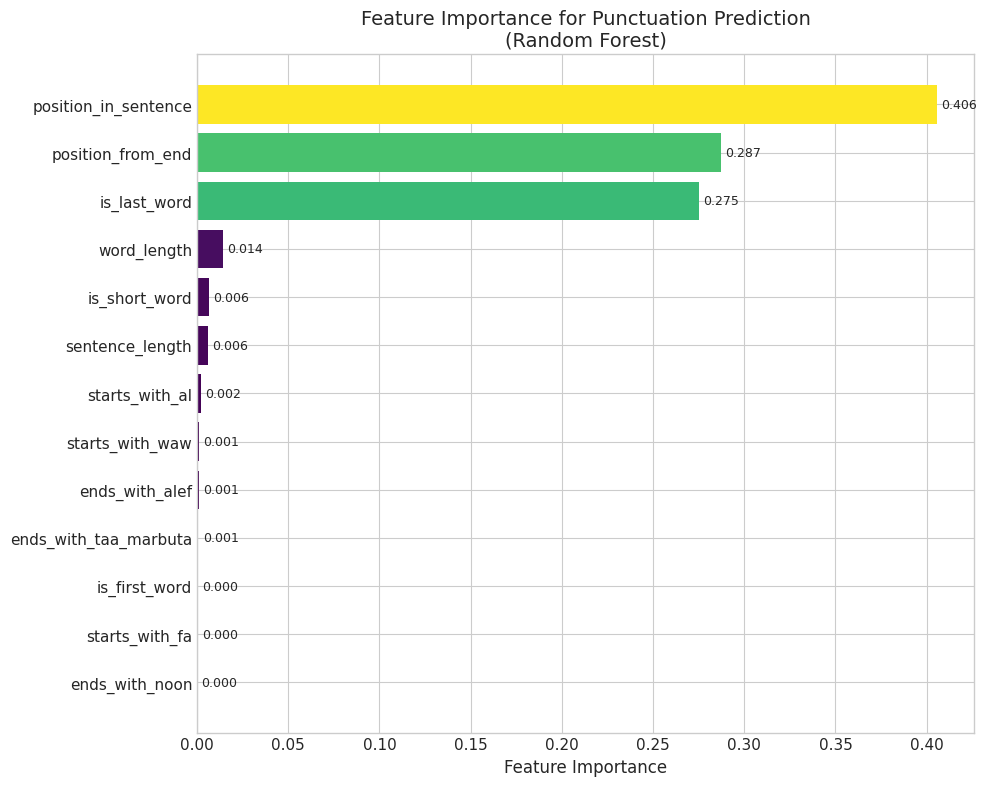

In [7]:
# ============================================================================
# ANALYSIS 5.2: FEATURE CORRELATION ANALYSIS
# ============================================================================

def analyze_feature_correlations(line_iterator, sample_size: int = 100000) -> tuple:
    """
    Analyze which features correlate with punctuation placement.
    
    Parameters:
    -----------
    line_iterator : Iterator[str]
        Stream of sentences/lines
    sample_size : int
        Number of sentences to analyze
        
    Returns:
    --------
    tuple
        (feature_df, importance_df) - DataFrames with features and importance
    """
    logger.info("=" * 70)
    logger.info("🔬 FEATURE CORRELATION ANALYSIS")
    logger.info("=" * 70)
    logger.info(f"\n⏳ Analyzing {format_number(sample_size)} sentences...")
    
    # Define punctuation marks
    punct_marks = {'،': 'comma', '.': 'period', '؟': 'question', '؛': 'semicolon'}
    
    # Collect feature data for each word position
    data = []
    
    try:
        if TQDM_AVAILABLE:
            iterator = tqdm(line_iterator, total=sample_size, desc="Extracting features")
        else:
            iterator = line_iterator
        
        for line_num, line in enumerate(iterator):
            if line_num >= sample_size:
                break
            
            line = line.strip()
            if not line:
                continue
            
            # Extract Arabic words
            words = ARABIC_WORD_PATTERN.findall(line)
            
            if not words:
                continue
            
            # For each word, extract features and determine label
            for i, word in enumerate(words):
                # Find position of word in original line to check what follows
                word_start = line.find(word)
                if word_start == -1:
                    continue
                
                word_end = word_start + len(word)
                following_char = line[word_end] if word_end < len(line) else ''
                
                # Determine punctuation label
                punct_label = punct_marks.get(following_char, 'none')
                
                # Extract features
                features = {
                    # Word-level features
                    'word_length': len(word),
                    'is_short_word': len(word) <= 3,
                    
                    # Position features
                    'position_in_sentence': i / max(len(words) - 1, 1),
                    'is_first_word': i == 0,
                    'is_last_word': i == len(words) - 1,
                    'position_from_end': len(words) - 1 - i,
                    
                    # Sentence-level features
                    'sentence_length': len(words),
                    
                    # Morphological features (heuristic)
                    'ends_with_taa_marbuta': word.endswith('ة'),
                    'ends_with_alef': word.endswith('ا'),
                    'ends_with_noon': word.endswith('ن'),
                    'ends_with_yaa': word.endswith('ي'),
                    'starts_with_waw': word.startswith('و'),
                    'starts_with_fa': word.startswith('ف'),
                    'starts_with_al': word.startswith('ال'),
                    'has_definite_article': 'ال' in word[:3] if len(word) >= 2 else False,
                    
                    # Labels
                    'punct_label': punct_label,
                    'has_punct': punct_label != 'none',
                }
                
                data.append(features)
        
        logger.info(f"\n   ✅ Extracted features for {format_number(len(data))} word positions")
        
    except Exception as e:
        logger.info(f"\n❌ ERROR: {e}")
        return pd.DataFrame(), pd.DataFrame()
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    return df


def display_feature_correlation_analysis(df: pd.DataFrame):
    """
    Display feature correlation analysis results.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with features and labels
    """
    if df.empty:
        logger.info("No feature data to display.")
        return pd.DataFrame()
    
    logger.info("\n" + "-" * 70)
    logger.info("📊 FEATURE CORRELATION ANALYSIS")
    logger.info("-" * 70)
    
    # --------------------------
    # Point-biserial correlation for numeric features
    # --------------------------
    logger.info("\n   Correlation with 'has_punct' (binary):")
    logger.info("   " + "-" * 50)
    
    numeric_features = ['word_length', 'position_in_sentence', 'sentence_length', 'position_from_end']
    
    correlations = []
    for feat in numeric_features:
        try:
            corr, p_value = pointbiserialr(df['has_punct'].astype(int), df[feat])
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            correlations.append((feat, corr, p_value, significance))
            logger.info(f"   {feat:<25}: r = {corr:>7.4f} {significance}")
        except Exception as e:
            logger.info(f"   {feat:<25}: Error - {e}")
    
    # --------------------------
    # Chi-square for categorical features
    # --------------------------
    logger.info("\n   Chi-square tests for categorical features:")
    logger.info("   " + "-" * 50)
    
    categorical_features = [
        'is_last_word', 'is_first_word', 'is_short_word',
        'ends_with_taa_marbuta', 'ends_with_alef', 'ends_with_noon',
        'starts_with_waw', 'starts_with_fa', 'starts_with_al', 'has_definite_article'
    ]
    
    chi_results = []
    for feat in categorical_features:
        try:
            contingency = pd.crosstab(df[feat], df['has_punct'])
            chi2, p_value, dof, expected = chi2_contingency(contingency)
            
            # Calculate Cramér's V (effect size)
            n = len(df)
            min_dim = min(contingency.shape) - 1
            cramers_v = np.sqrt(chi2 / (n * max(min_dim, 1)))
            
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            chi_results.append((feat, chi2, cramers_v, significance))
            logger.info(f"   {feat:<25}: χ² = {chi2:>10.1f}, V = {cramers_v:.4f} {significance}")
        except Exception as e:
            logger.info(f"   {feat:<25}: Error - {e}")
    
    # --------------------------
    # Conditional probabilities
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📊 CONDITIONAL PUNCTUATION PROBABILITIES")
    logger.info("-" * 70)
    
    logger.info("\n   P(punct | is_last_word):")
    logger.info(df.groupby('is_last_word')['has_punct'].mean().to_string())
    
    logger.info("\n   P(punct | ends_with_taa_marbuta):")
    logger.info(df.groupby('ends_with_taa_marbuta')['has_punct'].mean().to_string())
    
    logger.info("\n   P(punct | position quartile):")
    df['position_quartile'] = pd.qcut(df['position_in_sentence'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
    logger.info(df.groupby('position_quartile')['has_punct'].mean().to_string())
    
    # --------------------------
    # Feature importance using Random Forest
    # --------------------------
    logger.info("\n" + "-" * 70)
    logger.info("📊 FEATURE IMPORTANCE (Random Forest)")
    logger.info("-" * 70)
    
    feature_cols = [
        'word_length', 'position_in_sentence', 'is_last_word', 'is_first_word',
        'sentence_length', 'position_from_end', 'is_short_word',
        'ends_with_taa_marbuta', 'ends_with_alef', 'ends_with_noon',
        'starts_with_waw', 'starts_with_fa', 'starts_with_al'
    ]
    
    try:
        # Prepare data
        X = df[feature_cols].astype(float)
        y = df['has_punct'].astype(int)
        
        # Fit Random Forest
        logger.info("\n   Training Random Forest for feature importance...")
        rf = RandomForestClassifier(
            n_estimators=100, 
            random_state=RANDOM_SEED,
            n_jobs=-1,
            max_depth=10  # Limit depth for speed
        )
        rf.fit(X, y)
        
        # Get feature importance
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        logger.info("\n   Feature Importance Ranking:")
        logger.info("   " + "-" * 40)
        
        for _, row in importance_df.iterrows():
            bar = '█' * int(row['importance'] * 50)
            logger.info(f"   {row['feature']:<25}: {row['importance']:.4f} {bar}")
        
        return importance_df
        
    except Exception as e:
        logger.info(f"\n   ❌ ERROR in Random Forest: {e}")
        return pd.DataFrame()


def plot_feature_importance(importance_df: pd.DataFrame):
    """
    Plot feature importance.
    
    Parameters:
    -----------
    importance_df : pd.DataFrame
        DataFrame with feature importance values
    """
    if importance_df.empty:
        logger.info("No importance data to plot.")
        return
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Sort by importance
    importance_df = importance_df.sort_values('importance', ascending=True)
    
    # Create horizontal bar chart
    colors = plt.cm.viridis(importance_df['importance'] / importance_df['importance'].max())
    
    bars = ax.barh(importance_df['feature'], importance_df['importance'], color=colors)
    
    ax.set_xlabel('Feature Importance')
    ax.set_title('Feature Importance for Punctuation Prediction\n(Random Forest)')
    
    # Add value labels
    for bar, val in zip(bars, importance_df['importance']):
        ax.annotate(f'{val:.3f}',
                   xy=(val, bar.get_y() + bar.get_height() / 2),
                   xytext=(3, 0),
                   textcoords="offset points",
                   ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    
    # Save figure
    save_figure(fig, 'feature_importance.png')
    
    plt.show()


# Run the analysis
line_stream = iter_dataset_lines(DATASET_DIR)

feature_df = analyze_feature_correlations(
    line_stream,
    sample_size=SAMPLE_SIZES['feature_correlation']
)

# Display results and get importance
importance_df = display_feature_correlation_analysis(feature_df)

# Plot feature importance
if not importance_df.empty:
    plot_feature_importance(importance_df)

#### 💡 Decision Impact Summary

| Feature | Importance | Decision |
|---------|------------|----------|
| is_last_word | High | Critical feature - always include |
| position_in_sentence | High | Include positional encoding |
| sentence_length | Medium | Consider as global context |
| ends_with_taa_marbuta | Medium | Morphological features help |
| starts_with_waw | Low-Medium | Conjunction detection useful |

---
## 7. Summary & Key Findings

This section consolidates all findings from the EDA.

In [ ]:
# ============================================================================
# SECTION 7: SUMMARY & KEY FINDINGS
# ============================================================================

logger.info("=" * 80)
logger.info("📋 SUMMARY OF KEY FINDINGS")
logger.info("=" * 80)

logger.info("""

┌─────────────────────────────────────────────────────────────────────────────┐
│                           DATASET CHARACTERISTICS                            │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Size: ~3.2 GB, ~11.7 million sentences, ~309 million words               │
│  • Domain: UN parallel corpus (legal/parliamentary documents)               │
│  • Language: Modern Standard Arabic (MSA), formal register                  │
│  • Format: One sentence per line, scrambled order                           │
│  • Average sentence length: ~26 words                                        │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                           PUNCTUATION DISTRIBUTION                           │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Comma (،): ~52% of all punctuation                                        │
│  • Period (.): ~40% of all punctuation                                       │
│  • Semicolon (؛): ~5.5%                                                      │
│  • Colon (:): ~2%                                                            │
│  • Question mark (؟): ~0.2%                                                  │
│  • Exclamation (!): <0.01%                                                   │
│                                                                              │
│  ⚠️  SEVERE CLASS IMBALANCE - requires weighted loss or focal loss           │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                           PREPROCESSING NEEDS                                │
├─────────────────────────────────────────────────────────────────────────────┤
│  ✅ Remove diacritics (tashkeel) - if present                                │
│  ✅ Remove tatweel (elongation character)                                    │
│  ✅ Normalize Alef variations → ا                                            │
│  ✅ Normalize punctuation (Latin → Arabic)                                   │
│  ✅ Normalize numbers (Arabic → Western or vice versa)                       │
│  ✅ Filter very short sentences (<3 words)                                   │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                           MODEL RECOMMENDATIONS                              │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Tokenizer: AraBERT-v2 or CAMeLBERT (lowest UNK, good subword)            │
│  • Max sequence length: 64-128 tokens                                        │
│  • Loss function: Focal Loss (gamma=2.0) or Weighted CrossEntropy           │
│  • Consider merging EXCLAMATION with PERIOD (too rare)                       │
│  • Use position features (is_last_word is highly predictive)                │
│  • Consider domain adaptation for non-legal text                            │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                           KEY FEATURES FOR MODEL                             │
├─────────────────────────────────────────────────────────────────────────────┤
│  Most predictive features (by importance):                                   │
│  1. is_last_word (position in sentence)                                      │
│  2. position_in_sentence (relative position)                                 │
│  3. sentence_length (context)                                                │
│  4. word_length (morphological hint)                                         │
│  5. ends_with_taa_marbuta (morphological)                                   │
└─────────────────────────────────────────────────────────────────────────────┘

""")

---
## 8. Next Steps & Recommendations

In [ ]:
# ============================================================================
# SECTION 8: NEXT STEPS & RECOMMENDATIONS
# ============================================================================

logger.info("=" * 80)
logger.info("🚀 NEXT STEPS & RECOMMENDATIONS")
logger.info("=" * 80)

logger.info("""

┌─────────────────────────────────────────────────────────────────────────────┐
│                        IMMEDIATE NEXT STEPS                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│  1. DATA PREPROCESSING PIPELINE                                              │
│     □ Implement the preprocessing function from Section 4.5                  │
│     □ Create train/validation/test splits                                    │
│     □ Save preprocessed data in efficient format (e.g., HDF5, Arrow)        │
│                                                                              │
│  2. BASELINE MODEL                                                           │
│     □ Create rule-based baseline using context patterns                      │
│     □ Implement simple CRF model for comparison                              │
│                                                                              │
│  3. DEEP LEARNING MODEL                                                      │
│     □ Fine-tune AraBERT/CAMeLBERT for sequence labeling                     │
│     □ Implement weighted loss function                                       │
│     □ Set up evaluation metrics (macro-F1, per-class metrics)               │
│                                                                              │
│  4. EVALUATION                                                               │
│     □ Use ABC component (gold standard) as test set                         │
│     □ Perform error analysis                                                 │
│     □ Analyze performance by sentence length                                 │
│                                                                              │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                        RECOMMENDED TRAINING SETUP                            │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│  Model Architecture:                                                         │
│  ┌─────────────────────────────────────────────────────────────┐            │
│  │  Input: Tokenized Arabic text (without punctuation)          │            │
│  │           ↓                                                   │            │
│  │  Pre-trained Arabic LM (AraBERT/CAMeLBERT)                   │            │
│  │           ↓                                                   │            │
│  │  Token Classification Head                                    │            │
│  │           ↓                                                   │            │
│  │  Output: Punctuation label for each token position            │            │
│  │          [NONE, COMMA, PERIOD, QUESTION, SEMICOLON, COLON]   │            │
│  └─────────────────────────────────────────────────────────────┘            │
│                                                                              │
│  Training Configuration:                                                     │
│  • Batch size: 32 (adjust based on GPU memory)                              │
│  • Learning rate: 2e-5 to 5e-5                                              │
│  • Epochs: 3-5 (with early stopping)                                        │
│  • Max sequence length: 128 tokens                                          │
│  • Optimizer: AdamW with weight decay                                       │
│  • Loss: Focal Loss (alpha=class_weights, gamma=2.0)                        │
│                                                                              │
└─────────────────────────────────────────────────────────────────────────────┘

""")

---
## 📚 End of EDA Notebook

This notebook has provided a comprehensive exploratory data analysis of the SSAC-UNPC 
component of the Arabic Punctuation Dataset.

**Key outputs saved:**
- `eda_outputs/sentence_length_distribution.png`
- `eda_outputs/punctuation_frequency.png`
- `eda_outputs/sentence_terminals.png`
- `eda_outputs/vocabulary_analysis.png`
- `eda_outputs/punctuation_context.png`
- `eda_outputs/class_distribution.png`
- `eda_outputs/length_punctuation_analysis.png`
- `eda_outputs/feature_importance.png`

**Next notebook:** Data Preprocessing and Model Training

In [ ]:
logger.info("=" * 80)
logger.info("✅ EDA NOTEBOOK COMPLETE")
logger.info("=" * 80)
logger.info(f"\n📁 All figures saved to: {OUTPUT_DIR}/")
logger.info("\n🚀 Ready to proceed to preprocessing and model training!")